# [cknowledge.org/ai](http://cknowledge.org/ai): Crowdsourcing benchmarking and optimisation of AI

A suite of open-source tools for [collecting knowledge on optimising AI](http://bit.ly/hipeac49-ckdl):
* [Android app](https://play.google.com/store/apps/details?id=openscience.crowdsource.video.experiments&hl=en_GB)
* [Desktop app](https://github.com/dividiti/ck-crowdsource-dnn-optimization)
* [CK-Caffe](https://github.com/dividiti/ck-caffe)
* [CK-Caffe2](https://github.com/ctuning/ck-caffe2)
* [CK-TensorFlow](https://github.com/ctuning/ck-tensorflow)
* [CK-TensorRT](https://github.com/dividiti/ck-tensorrt)
* [CK-KaNN](https://github.com/dividiti/ck-kann)
* etc.

# [PUBLIC] Benchmarking Caffe on Firefly-RK3399

In [1]:
platform_id = 'Rockchip RK3399 Firefly Board (Linux Opensource)\x00'
platform_name = 'Firefly-RK3399'
platform_tag = 'firefly-rk3399'
platform_os = 'linux'
repo_uoa = 'ck-caffe-firefly-rk3399'

In [2]:
pretty_print_models = {
    'bvlc-alexnet':'AlexNet',
    'deepscale-squeezenet-1.1':'SqueezeNet',
    'bvlc-googlenet':'GoogleNet'
}

speedup_sort_models = [
    'AlexNet',
    'SqueezeNet',
    'GoogleNet'
]

In [3]:
if platform_os == 'linux':
    # All OpenCL BLAS libs and libDNN with OpenCL BLAS libs.
    opencl_libs = [ 
        # OpenCL BLAS libs.
        'opencl-clblas',
        'opencl-clblast',
        'opencl-clblast-tune',
        'opencl-viennacl',
        # libDNN with OpenCL BLAS libs.
        'opencl-libdnn-clblas',
        'opencl-libdnn-clblast',
        'opencl-libdnn-clblast-tune',
        'opencl-libdnn-viennacl'
    ]
    # libDNN with CLBlast-tune is typically the fastest, so the others can be omitted.
    libdnn_libs_to_drop = [
        'opencl-libdnn-clblas',
        'opencl-libdnn-clblast',
        'opencl-libdnn-viennacl'
    ]
    # Used by plot_max_num_images_per_second().
    pretty_print_libs = {
        'opencl-libdnn-clblast-tune': '[GPU] libDNN',
        'opencl-clblas':              '[GPU] clBLAS',
        'opencl-viennacl':            '[GPU] ViennaCL',
        'opencl-clblast':             '[GPU] CLBlast',
        'opencl-clblast-tune':        '[GPU] CLBlast (dv/dt)',
        'cpu':                        '[CPU] OpenBLAS'
    }
    speedup_sort_libs = [
        '[GPU] libDNN',
        '[GPU] clBLAS',
        '[GPU] ViennaCL',
        '[GPU] CLBlast',
        '[GPU] CLBlast (dv/dt)',
        '[CPU] OpenBLAS'
    ]    
else: # 'android'
    # As above but no clBLAS-based libs.
    opencl_libs = [
        # OpenCL BLAS libs.
        'opencl-clblast',
        'opencl-clblast-tune',
        'opencl-viennacl',
        # libDNN with OpenCL BLAS libs.
        'opencl-libdnn-clblast',
        'opencl-libdnn-clblast-tune',
        'opencl-libdnn-viennacl'
    ]
    # As above but no clBLAS-based libDNN.
    libdnn_libs_to_drop = [
        'opencl-libdnn-clblast',
        'opencl-libdnn-viennacl'
    ]
    # Used by plot_max_num_images_per_second().
    pretty_print_libs = {
        'opencl-libdnn-clblast-tune': '[GPU] libDNN',
        'opencl-viennacl':            '[GPU] ViennaCL',
        'opencl-clblast':             '[GPU] CLBlast',
        'opencl-clblast-tune':        '[GPU] CLBlast (dv/dt)',
        'cpu':                        '[CPU] OpenBLAS'
    }
    speedup_sort_libs = [
        '[GPU] libDNN',
        '[GPU] ViennaCL',
        '[GPU] CLBlast',
        '[GPU] CLBlast (dv/dt)',
        '[CPU] OpenBLAS'
    ]
# OpenBLAS.
cpu_libs = ['cpu']
all_libs = cpu_libs + opencl_libs

## Table of Contents

1. [Overview](#overview)
1. [See the code](#code) [for developers]
1. [Get the data](#data) [for developers]
1. [See the tables](#tables)
  1. [All data](#df_all)
  1. [All execution time data](#df_time)
  1. [Mean execution time per batch](#df_mean_time_per_batch)
  1. [Mean execution time per image](#df_mean_time_per_image)
  1. [Best mean execution time per image](#df_best_mean_time_per_image)
1. [See the graphs - grouped by models](#plot_models)
  1. [All libs](#plot_models_all)
  1. [GPU libs](#plot_models_gpu)
  1. [CLBlast-based libs](#plot_models_clblast)
  1. [libDNN-based libs](#plot_models_libdnn)
1. [See the graphs - grouped by libs](#plot_libs)
  1. [All models](#plot_libs_all)
  1. [All models, GPU libs](#plot_libs_gpu)
  1. [Models with AlexNet-level accuracy](#plot_libs_alexnet)
  1. [Models with AlexNet-level accuracy, CLBlast-based libs](#plot_libs_alexnet_clblast)
  1. [Models with AlexNet-level accuracy, libDNN-based libs](#plot_libs_alexnet_libdnn)
  1. [Models with AlexNet-level accuracy, CPU lib](#plot_libs_alexnet_cpu)
1. [See the graphs - per layer execution time profiling](#plot_per_layer)
1. [See the graphs - the ideal adaptive solution](#plot_ideal)
  1. [Using all libs for adaptation](#plot_ideal_all)
  1. [Using OpenBLAS and libDNN for adaptation](#plot_ideal_cpu_libdnn)
  1. [Using OpenBLAS and CLBlast for adaptation](#plot_ideal_cpu_clblast)
  1. [Using OpenBLAS and ViennaCL for adaptation](#plot_ideal_cpu_viennacl)
1. [See the memory consumption graph](#plot_memory)
  1. [Balance memory consumption and execution time per image](#balance_memory_time)
1. [Compare AlexNet and SqueezeNet 1.1](#alexnet_vs_squeezenet)
  1. [Memory consumption](#alexnet_vs_squeezenet_memory)
  1. [Execution time](#alexnet_vs_squeezenet_time)
1. [Summary](#summary)
  1. [Absolute performance](#performance_absolute)
  1. [Relative performance](#performance_relative)

<a id="overview"></a>
## Overview

This Jupyter Notebook studies the performance (execution time, memory consumption):
- on the [Firefly-RK3399](http://en.t-firefly.com/en/firenow/Firefly_RK3399/) development board:
  - Chip:
    - [Rockchip RK3399](http://rockchip.wikidot.com/rk3399)
  - CPU ("big"):
    - ARM&reg; Cortex&reg;-A72 architecture
    - Max clock 1800 MHz;
    - 2 cores;
  - CPU ("LITTLE"):
    - ARM&reg; Cortex&reg;-A53 architecture;
    - Max clock 1416 MHz;
    - 4 cores;
  - GPU:
    - ARM&reg; Mali&trade;-T860 architecture;
    - Max clock 800 MHz;
    - 4 cores;
    - OpenCL driver:
```
$ ck run program:tool-print-opencl-devices | grep "version:"
OpenCL 1.2 v1.r13p0-00rel0-git(a4271c9).1ad3fc5b648bfed782705ad469a9797a
```

  - RAM:
    - Samsung dual-channel DDR3;
    - 4 GB;
  - BSP:
    - [Firefly-rk3399_xubuntu1604_201704100952_Beta.7z](http://bbs.t-firefly.com/forum.php?mod=viewthread&tid=1876&extra=page%3D1)
```
$ cat /etc/lsb-release 
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=16.04
DISTRIB_CODENAME=xenial
DISTRIB_DESCRIPTION="Ubuntu 16.04.2 LTS"
$ uname -a
Linux firefly 4.4.52 #9 SMP Fri Mar 24 10:53:56 HKT 2017 aarch64 aarch64 aarch64 GNU/Linux
```

- of the following **Caffe models**:

```
$ ck show env --tags=caffemodel
Name:                                                      Version:                 Tags:

Caffe model (net and weights) (deepscale, squeezenet, 1.1) 1.1      32bits,bvlc,caffe,caffemodel,deepscale,host-os-linux-32,net,squeezenet,target-os-linux-32,v1,v1.1,weights

Caffe model (net and weights) (bvlc, googlenet)            trunk    32bits,bvlc,caffe,caffemodel,googlenet,host-os-linux-32,mirror,net,target-os-linux-32,v0,weights

Caffe model (net and weights) (bvlc, alexnet)              trunk    32bits,alexnet,bvlc,caffe,caffemodel,host-os-linux-32,mirror,net,target-os-linux-32,v0,weights
```

- with the following **Caffe libraries**:

```
$ ck show env --tags=lib,caffe
Name:                                             Version:       Tags:

BVLC Caffe framework (opencl,clblast,tune) trunk-880111e 32bits,bvlc,caffe,host-os-linux-32,lib,target-os-linux-32,v0,v0.0,vclblast,vopencl,vtune

BVLC Caffe framework (opencl,clblast)      trunk-880111e 32bits,bvlc,caffe,host-os-linux-32,lib,target-os-linux-32,v0,v0.0,vclblast,vopencl

BVLC Caffe framework (cpu)                 trunk-eeebdab 32bits,bvlc,caffe,host-os-linux-32,lib,target-os-linux-32,v0,v0.0,vcpu,vmaster

...
```

- built with the following **BLAS libraries**:

```
$ ck show env --tags=lib,blas
Name:            Version:            Tags:

clBLAS library   2.10-d16f7b3        32bits,blas,clblas,host-os-linux-32,lib,opencl-blas,target-os-linux-32,v2,v2.10,v2.10.0

ViennaCL library dvdt-master-5494bef 32bits,blas,host-os-linux-32,lib,opencl-blas,src,target-os-linux-32,v0,v0.0,v0.0.0,vdvdt,viennacl,vsrc

ViennaCL library master-5494bef      32bits,blas,host-os-linux-32,lib,opencl-blas,target-os-linux-32,v0,v0.0,vcpu,viennacl,vmaster

ViennaCL library master-5494bef      32bits,blas,host-os-linux-32,lib,opencl-blas,src,target-os-linux-32,v0,v0.0,viennacl,vmaster,vsrc

OpenBLAS library 0.2.19-85636ff      32bits,blas,cblas,host-os-linux-32,lib,openblas,target-os-linux-32,v0,v0.2,v0.2.19,v0.2.19.0

CLBlast library  development-3ec14df 32bits,blas,clblast,host-os-linux-32,lib,no-tune,opencl-blas,target-os-linux-32,v0,v0.0,vdev,vmaster

CLBlast library  development-c9f39ed 32bits,blas,clblast,clblast-tune,host-os-linux-32,lib,opencl-blas,target-os-linux-32,tune,v0,v0.0,vdev,vmaster

```

- with the **batch size** varying from 2 to 16 with step 2.

<a id="code"></a>
## Data wrangling code

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook.

### Includes

#### Standard

In [4]:
import os
import sys
import json
import re

#### Scientific

If some of the scientific packages are missing, please install them using:
```
# pip install jupyter pandas numpy matplotlib
```

In [5]:
import IPython as ip
import pandas as pd
import numpy as np
import matplotlib as mp

In [6]:
print ('IPython version: %s' % ip.__version__)
print ('Pandas version: %s' % pd.__version__)
print ('NumPy version: %s' % np.__version__)
print ('Matplotlib version: %s' % mp.__version__)

IPython version: 5.3.0
Pandas version: 0.20.1
NumPy version: 1.12.1
Matplotlib version: 2.0.0


In [7]:
from IPython.display import Image, display
def display_in_full(df):
    pd.options.display.max_columns = len(df.columns)
    pd.options.display.max_rows = len(df.index)
    display(df)

In [8]:
# import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [9]:
default_title = platform_name
default_ylabel = 'Execution time (ms)'
default_colormap = cm.autumn
default_figsize = [16, 8]
default_dpi = 200
default_fontsize = 16

In [10]:
if mp.__version__[0]=='2': mp.style.use('classic')
mp.rcParams['figure.figsize'] = default_figsize
mp.rcParams['figure.dpi'] = default_dpi
mp.rcParams['font.size'] = default_fontsize
mp.rcParams['legend.fontsize'] = 'medium'

#### Collective Knowledge

If CK is not installed, please install it using:
```
# pip install ck
```

In [11]:
import ck.kernel as ck
print ('CK version: %s' % ck.__version__)

CK version: 1.9.1.1


### Access the experimental data

In [12]:
def get_experimental_results(repo_uoa='local', default_tag='explore-batch-size-libs-models', time_ms='time_fw_ms'):
    module_uoa = 'experiment'
    r = ck.access({'action':'search', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'tags':default_tag})
    if r['return']>0:
        print ("Error: %s" % r['error'])
        exit(1)
    experiments = r['lst']
    
    dfs = []
    for experiment in experiments:
        data_uoa = experiment['data_uoa']
        r = ck.access({'action':'list_points', 'repo_uoa':repo_uoa, 'module_uoa':module_uoa, 'data_uoa':data_uoa})
        if r['return']>0:
            print ("Error: %s" % r['error'])
            exit(1)

        # Get (lib_tag, model_tag) from a list of tags in r['dict']['tags'].
        # This list includes a couple of irrelevant tags (e.g. cmd key), a model tag and a lib tag.
        # NB: Since it's typically easier to list all model tags than all lib tags, only the list
        # of models is specified explicitly.
        tags = r['dict']['tags']
        cmd_key = 'default'
        irrelevant_tags = [ cmd_key, default_tag, platform_tag ]
        model_tags = [ 'bvlc-alexnet', 'bvlc-googlenet', 'deepscale-squeezenet-1.1' ]
        lib_model_tags = [ tag for tag in tags if tag not in irrelevant_tags ]
        model_tags = [ tag for tag in lib_model_tags if tag in model_tags ]
        lib_tags = [ tag for tag in lib_model_tags if tag not in model_tags ]
        # print (tags, model_tags, lib_tags)
        if len(lib_tags)==1 and len(model_tags)==1:
            (lib, model) = (lib_tags[0], model_tags[0])
        else:
            continue
        
        for point in r['points']:
            with open(os.path.join(r['path'], 'ckp-%s.0001.json' % point)) as point_file:
                point_data_raw = json.load(point_file)
            characteristics_list = point_data_raw['characteristics_list']
            num_repetitions = len(characteristics_list)
            platform = point_data_raw['features']['platform']['platform']['model']
            batch_size = np.int64(point_data_raw['choices']['env'].get('CK_CAFFE_BATCH_SIZE',-1))
            # Obtain column data.
            data = [
                {
                    # features
                    'platform' : platform,
                    # choices
                    'lib' : lib,
                    'model' : model,
                    'batch_size' : batch_size,
                    # statistical repetition
                    'repetition_id': repetition_id,
                    # runtime characteristics
                    'time (ms)'   : characteristics['run'].get(time_ms, 1e+9), # 1e+9 is like "positive infinity"
                    'memory (MB)' : characteristics['run'].get('memory_mbytes', -1),
                    'success?'    : characteristics['run'].get('run_success', 'n/a'),
                    'per layer info' : characteristics['run'].get('per_layer_info', []),
                }
                for (repetition_id, characteristics) in zip(range(num_repetitions), characteristics_list) 
            ]
            # Deal with missing column data (resulting from failed runs).
            if len(data)==1:                
                print ('[Warning] Missing data for: lib=%s, model=%s, batch_size=%d' % (lib, model, batch_size))
                data = data * num_repetitions
            # Construct a DataFrame.
            df = pd.DataFrame(data)
            # Set columns and index names.
            df.columns.name = 'run characteristic'
            df.index.name = 'index'
            df = df.set_index([ 'platform', 'lib', 'model', 'batch_size', 'repetition_id' ])
            # Append to the list of similarly constructed DataFrames.
            dfs.append(df)
    # Concatenate all constructed DataFrames (i.e. stack on top of each other).    
    result = pd.concat(dfs)
    return result.sort_index(level=result.index.names)

### Plot execution time per image or memory consumption

In [13]:
def plot(mean, std, title=default_title, ylabel=default_ylabel, rot=0, ymax=0):
    ymax = mean.max().max() if ymax==0 else ymax
    ax = mean.plot(kind='bar', yerr=std, grid=True, legend=True, rot=rot, ylim=[0,ymax*1.05],
                   fontsize=default_fontsize, figsize=default_figsize, colormap=default_colormap)
    ax.set_title(title, fontsize=default_fontsize)
    ax.set_xlabel(mean.index.name, fontsize=default_fontsize)
    ax.set_ylabel(ylabel, fontsize=default_fontsize)
    return ax

### Plot maximum number of images per second (FPS)

In [14]:
def plot_max_num_images_per_second(df_mean_time_per_image, libs_to_drop=libdnn_libs_to_drop, rot=0, fontsize=None):
    min_time_per_image = df_mean_time_per_image.min(axis=1).unstack('lib')
    images_per_second = 1e+3 / min_time_per_image
    max_num_images_per_second = images_per_second \
        .drop(libs_to_drop, axis=1) \
        .rename(columns=pretty_print_libs, index=pretty_print_models) \
        .reindex(columns=speedup_sort_libs, index=speedup_sort_models)
    ax = max_num_images_per_second \
        .plot(kind='bar', rot=rot, width=0.95, grid=True, legend=True,
              fontsize=default_fontsize, figsize=default_figsize, colormap=default_colormap)
    ax.set_title(default_title, fontsize=default_fontsize)
    ax.set_xlabel(max_num_images_per_second.index.name, fontsize=default_fontsize)
    ax.set_ylabel('Images/second (with the best even batch size from 2 to 16)', fontsize=default_fontsize)
    ax.legend(loc='upper left');
    for patch in ax.patches:
        text = '{0:.2f}'.format(patch.get_height())[0:4]
        ax.annotate(text, (patch.get_x()*1.00, patch.get_height()*1.01), fontsize=fontsize)

### Plot the speedup over a given baseline

In [15]:
def plot_speedup_over_baseline(df_mean_time_per_image, baseline='opencl-clblast-tune', 
                               libs_to_drop=libdnn_libs_to_drop, rot=0, fontsize=None):
    speedup_over_baseline = df_mean_time_per_image.min(axis=1).unstack('model').loc[baseline] / \
                            df_mean_time_per_image.min(axis=1).unstack('model')
    speedup_over_baseline = speedup_over_baseline.T \
        .drop(libs_to_drop, axis=1) \
        .rename(index=pretty_print_models, columns=pretty_print_libs) \
        .reindex(columns=speedup_sort_libs)
    ax = speedup_over_baseline \
        .plot(kind='bar', rot=rot, width=0.95, grid=True, legend=True,
              fontsize=default_fontsize, figsize=default_figsize, colormap=default_colormap)
    ax.set_title(default_title, fontsize=default_fontsize)
    ax.set_xlabel(speedup_over_baseline.index.name, fontsize=default_fontsize)
    ax.set_ylabel('Speedup over the given baseline (%s)' % pretty_print_libs[baseline], fontsize=default_fontsize)
    for patch in ax.patches:
        text = '{0:.2f}'.format(patch.get_height())[0:4]
        ax.annotate(text, (patch.get_x()*1.00, patch.get_height()*1.01), fontsize=fontsize)

### Plot execution time per image per layer

In [16]:
# This transformation is time consuming, hence only call it once for multiple plots.
def get_per_layer_info(df_all):
    df_per_layer_info = df_all['per layer info']
    row_dfs = []
    for (row_info, row_id) in zip(df_per_layer_info, range(len(df_per_layer_info))):
        # Skip constructing a DataFrame when no layer info is available.
        if not row_info: continue
        # Augment each layer info with the row index: (model, lib, batch_size, repetition_id).
        for layer_info in row_info:
            layer_info.update({ k : v for k, v in zip(df_per_layer_info.index.names, df_per_layer_info.index[row_id]) })
        # Construct a DataFrame and move the row index to where it belongs.
        row_df = pd.DataFrame(data=row_info).set_index(df_per_layer_info.index.names)
        row_dfs.append(row_df)
    return pd.concat(row_dfs)

In [17]:
def plot_time_per_image_per_layer(df_per_layer_info, model, libs, batch_sizes,
                                  direction=['forward'], lower=0.0, upper=1.0, ymax=0, rot=90):
    df_time_per_batch = df_per_layer_info.loc[model, libs, batch_sizes] \
        .set_index(['direction', 'label'], append=True) \
        .reorder_levels(['direction', 'label', 'model', 'lib', 'batch_size', 'repetition_id']) \
        .loc[direction] \
        .reorder_levels(['label', 'model', 'lib', 'batch_size', 'repetition_id', 'direction']) \
        .groupby(level=['label', 'model', 'lib', 'batch_size', 'repetition_id']).sum() \
        ['time_ms']
    df_time_per_image = df_time_per_batch.unstack('batch_size') / batch_sizes
    df = df_time_per_image.unstack(['lib', 'model'])
    df = df.reorder_levels(['model', 'lib', 'batch_size'], axis=1)
    mean = df.groupby(level='label').mean()
    std = df.groupby(level='label').std()
    select = (lower*mean.sum() <= mean).any(axis=1) & (mean <= upper*mean.sum()).any(axis=1)
    ymax = mean[select].max().max() if ymax==0 else ymax
    ax = plot(mean=mean[select], std=std[select], ylabel='Execution per image time per layer (ms)', ymax=ymax, rot=rot)
    ax.set_xlabel('Layer', fontsize=default_fontsize)

### Plot the ideal adaptive solution

In [18]:
# The ideal adaptive solution for each layer selects the best performing library from the 'libs_for_adaptation' list.
def get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation, direction=['forward']):
    df_for_adaptation = df_per_layer_info \
        .set_index(['direction', 'label'], append=True) \
        .reorder_levels(['direction', 'lib', 'model', 'label', 'batch_size', 'repetition_id']) \
        .loc[direction] \
        .sort_index() \
        .reorder_levels(['lib', 'model', 'label', 'batch_size', 'repetition_id', 'direction']) \
        .loc[libs_for_adaptation] \
        .reorder_levels(['model', 'label', 'lib', 'batch_size', 'repetition_id', 'direction']) \
        ['time_ms']
    # With every step, reduce the rightmost dimension until the min time per model is reached.
    df_cum_time_per_repetition = df_for_adaptation.groupby(level=df_for_adaptation.index.names[:-1]).sum()
    df_min_time_per_repetition = df_cum_time_per_repetition.groupby(level=df_cum_time_per_repetition.index.names[:-1]).min()
    batch_sizes = df_per_layer_info.index.levels[df_per_layer_info.index.names.index('batch_size')].values
    df_min_time_per_batch = df_min_time_per_repetition.unstack('batch_size') / batch_sizes
    df_min_time_per_image = df_min_time_per_batch.min(axis=1)
    df_min_time_per_layer = df_min_time_per_image.groupby(level=df_min_time_per_image.index.names[:-1]).min()
    #df_min_time_per_model = df_min_time_per_layer.groupby(level=df_min_time_per_layer.index.names[:-1]).sum()
    # Transform to get the models in the index and the libs in the columns.
    df_min_time_per_layer_idx = df_min_time_per_image.groupby(level=df_min_time_per_image.index.names[:-1]).idxmin()
    df_ideal = df_min_time_per_image[df_min_time_per_layer_idx] \
        .reorder_levels(['model', 'lib', 'label']) \
        .groupby(level=['model', 'lib']).sum() \
        .unstack('lib')
    # Sort in the order of increasing time per model.
    df_ideal_sorted = df_ideal.loc[df_ideal.sum(axis=1).sort_values(ascending=True).index]
    return df_ideal_sorted

In [19]:
def plot_ideal_adaptive_solution(df_ideal, df_real, tag=''):
    figsize=[15, 3]
    if not tag=='': figsize=[10, 2] # good for dumping png (e.g. 3 graphs fit well onto a slide).
    for model in df_ideal.index:
        df_data = {}; df_data['adaptive'] = df_ideal.loc[model]
        for lib in df_ideal.columns:
            df_data[lib] = pd.Series(index=df_ideal.columns)
            df_data[lib][lib] = df_real.loc[model, lib]
        df = pd.DataFrame(df_data).T \
            .rename(
                columns=pretty_print_libs,
                index={ 
                    key : pretty_print_libs[key].replace('[CPU]', 'Only').replace('[GPU]', 'Only')
                    for key in pretty_print_libs.keys()
                })
        ax = df.loc[df.sum(axis=1).sort_values(ascending=True).index] \
            .plot(kind='barh', stacked=True, width=0.9, grid=True, legend=True,
                  fontsize=default_fontsize, figsize=figsize, colormap=cm.summer_r)
            #.legend(loc='lower right')
        ax.set_title('%s - execution time per image (ms)' % model, fontsize=default_fontsize)
        if not tag=='': ax.get_figure().savefig('%s.%s.png' % (tag, model))

### Plot execution time per image and memory consumption

In [20]:
def plot_time_per_image_and_memory_consumption(df_all, model, lib):
    df = df_all[['time (ms)', 'memory (MB)']] \
        .groupby(level=df_all.index.names[:-1]).mean() \
        .loc[lib, model]
    df['time per image (ms)'] = df['time (ms)'].divide(df.index, axis=0)
    df['memory per image (MB)'] = df['memory (MB)'].divide(df.index, axis=0)
    df = df.drop('time (ms)', axis=1).sort_index()
    ax = df.plot(secondary_y=['memory (MB)', 'memory per image (MB)'], mark_right=False, grid=True,
                 figsize=[12, 8], fontsize=default_fontsize, colormap=cm.winter)
    ax.set_title('%s w/ %s' % (model, lib), fontsize=default_fontsize)
    ax.set_xlabel(df.index.name, fontsize=default_fontsize)
    ax.set_ylabel('execution time (ms)', fontsize=default_fontsize); ax.legend(loc='center left'); ax.set_ylim(0)
    ax.right_ax.set_ylabel('memory consumption (MB)', fontsize=default_fontsize); ax.right_ax.legend(loc='center right')

<a id="data"></a>
## Get the experimental data

**NB:** Please ignore this section if you are not interested in re-running or modifying this notebook. 

The Caffe experimental data was collected on the experimental platform (after installing all Caffe libraries and models of interest) as follows:
```
$ cd `ck find ck-caffe:script:explore-batch-size-libs-models`
$ python explore-batch-size-libs-models-benchmark.py
```

It can be downloaded and registered with CK as follows:
```
$ ck add repo:ck-caffe-firefly-rk3399 --url=https://github.com/dividiti/ck-caffe-firefly-rk3399 --quiet
```

<a id="tables"></a>
## Tables

<a id="df_all"></a>
### All data

In [21]:
df_all = get_experimental_results(repo_uoa)
display_in_full(df_all)

run characteristic                                                                                                              memory (MB)  \
platform                                          lib                        model                    batch_size repetition_id                
Rockchip RK3399 Firefly Board (Linux Opensource)  cpu                        bvlc-alexnet             2          0                16.646488   
                                                                                                                 1                16.646488   
                                                                                                                 2                16.646488   
                                                                                                      4          0                33.292976   
                                                                                                                 1                33.292976   
                                                                                                                 2                33.292976   
                                                                                                      6          0                49.939464   
                                                                                                                 1                49.939464   
                                                                                                                 2                49.939464   
                                                                                                      8          0                66.585952   
                                                                                                                 1                66.585952   
                                                                                                                 2                66.585952   
                                                                                                      10         0                83.232440   
                                                                                                                 1                83.232440   
                                                                                                                 2                83.232440   
                                                                                                      12         0                99.878928   
                                                                                                                 1                99.878928   
                                                                                                                 2                99.878928   
                                                                                                      14         0               116.525416   
                                                                                                                 1               116.525416   
                                                                                                                 2               116.525416   
                                                                                                      16         0               133.171904   
                                                                                                                 1               133.171904   
                                                                                                                 2               133.171904   
                                                                             bvlc-googlenet           2          0               110.306688   
                                                                                                                 1               110.306688

<a id="df_time"></a>
### All execution time data indexed by repetitions

In [22]:
df_time = df_all['time (ms)'].unstack(df_all.index.names[:-1])
display_in_full(df_time)

platform      Rockchip RK3399 Firefly Board (Linux Opensource)            \
lib                                                         cpu            
model                                              bvlc-alexnet            
batch_size                                                   2        4    
repetition_id                                                              
0                                                       696.081  1021.68   
1                                                       692.967  1021.85   
2                                                       694.931  1021.48   

platform                                                             \
lib                                                                   
model                                                                 
batch_size          6        8        10       12       14       16   
repetition_id                                                         
0              1432.68  1851.28  2281.11  2719.28  3099.74  3457.39   
1              1436.30  1847.25  2281.76  2718.07  3096.30  3458.00   
2              1466.81  1842.83  2286.40  2728.06  3100.51  3457.70   

platform                                                                   \
lib                                                                         
model         bvlc-googlenet                                                
batch_size                2        4        6        8        10       12   
repetition_id                                                               
0                    1156.18  2297.33  3448.69  4598.89  5707.03  6846.76   
1                    1542.93  2293.55  3442.86  4577.89  5733.81  6877.85   
2                    1153.90  2295.91  3443.64  4576.61  5712.51  6889.41   

platform                                                                     \
lib                                                                           
model                            deepscale-squeezenet-1.1                     
batch_size          14        16                       2        4        6    
repetition_id                                                                 
0              8895.40  10179.30                  268.374  537.391  799.161   
1              7978.87  10174.10                  268.214  534.154  796.585   
2              7977.15   9128.31                  267.982  536.091  800.099   

platform                                                                  \
lib                                                        opencl-clblas   
model                                                       bvlc-alexnet   
batch_size          8        10       12       14       16            2    
repetition_id                                                              
0              1064.90  1328.73  1594.10  1859.91  2123.80       3667.75   
1              1063.01  1330.18  1597.00  1856.77  2131.58       3729.72   
2              1069.42  1329.46  1592.29  1865.05  2120.80       3732.55   

platform                                                                      \
lib                                                                            
model                                                                          
batch_size          4        6        8        10       12       14       16   
repetition_id                                                                  
0              5673.65  7623.63  9549.93  8802.05  13498.8  15578.0  15794.9   
1              5682.20  6144.67  8778.12  8803.49  13568.6  15525.1  15771.5   
2              5656.22  7614.73  8764.36  8803.96  13605.6  15477.2  17487.2   

platform                                                                   \
lib                                                                         
model         bvlc-googlenet                                                
batch_size                2        4        6        8        10       12   
repetition_id 

<a id="df_mean_time_per_batch"></a>
### Mean execution time per batch

In [23]:
df_mean_time_per_batch = df_all['time (ms)'] \
    .unstack('batch_size') \
    .reorder_levels(['platform', 'model', 'lib', 'repetition_id']) \
    .groupby(['platform', 'model', 'lib']).mean() \
    .sort_index()
display_in_full(df_mean_time_per_batch)

batch_size                                                                                                      2   \
platform                                          model                    lib                                       
Rockchip RK3399 Firefly Board (Linux Opensource)  bvlc-alexnet             cpu                          694.659667   
                                                                           opencl-clblas               3710.006667   
                                                                           opencl-clblast              4540.390000   
                                                                           opencl-clblast-tune         1337.960000   
                                                                           opencl-libdnn-clblas        5388.870000   
                                                                           opencl-libdnn-clblast       2165.070000   
                                                                           opencl-libdnn-clblast-tune  2994.290000   
                                                                           opencl-libdnn-viennacl      3925.313333   
                                                                           opencl-viennacl             3658.920000   
                                                  bvlc-googlenet           cpu                         1284.336667   
                                                                           opencl-clblas               4954.506667   
                                                                           opencl-clblast              5626.383333   
                                                                           opencl-clblast-tune         1708.510000   
                                                                           opencl-libdnn-clblas        5758.913333   
                                                                           opencl-libdnn-clblast       5865.280000   
                                                                           opencl-libdnn-clblast-tune  5792.800000   
                                                                           opencl-libdnn-viennacl      5803.660000   
                                                                           opencl-viennacl             4973.856667   
                                                  deepscale-squeezenet-1.1 cpu                          268.190000   
                                                                           opencl-clblas               1321.260000   
                                                                           opencl-clblast              1917.030000   
                                                                           opencl-clblast-tune          572.815333   
                                                                           opencl-libdnn-clblas        1500.550000   
                                                                           opencl-libdnn-clblast       1468.653333   
                                                                           opencl-libdnn-clblast-tune  1469.533333   
                                                                           opencl-libdnn-viennacl      1509.330000   
                                                                           opencl-viennacl             1322.146667   

batch_size                                                                                                       4   \
platform                                          model                    lib                                        
Rockchip RK3399 Firefly Board (Linux Opensource)  bvlc-alexnet             cpu                          1021.670000   
                                                                           opencl-clblas                5670.690000   
                                                                           opencl-clblast            

<a id="df_mean_time_per_image"></a>
### Mean execution time per image

In [24]:
batch_sizes = df_mean_time_per_batch.columns.tolist()
df_mean_time_per_image = df_mean_time_per_batch / batch_sizes
display_in_full(df_mean_time_per_image)

batch_size                                                                                                      2   \
platform                                          model                    lib                                       
Rockchip RK3399 Firefly Board (Linux Opensource)  bvlc-alexnet             cpu                          347.329833   
                                                                           opencl-clblas               1855.003333   
                                                                           opencl-clblast              2270.195000   
                                                                           opencl-clblast-tune          668.980000   
                                                                           opencl-libdnn-clblas        2694.435000   
                                                                           opencl-libdnn-clblast       1082.535000   
                                                                           opencl-libdnn-clblast-tune  1497.145000   
                                                                           opencl-libdnn-viennacl      1962.656667   
                                                                           opencl-viennacl             1829.460000   
                                                  bvlc-googlenet           cpu                          642.168333   
                                                                           opencl-clblas               2477.253333   
                                                                           opencl-clblast              2813.191667   
                                                                           opencl-clblast-tune          854.255000   
                                                                           opencl-libdnn-clblas        2879.456667   
                                                                           opencl-libdnn-clblast       2932.640000   
                                                                           opencl-libdnn-clblast-tune  2896.400000   
                                                                           opencl-libdnn-viennacl      2901.830000   
                                                                           opencl-viennacl             2486.928333   
                                                  deepscale-squeezenet-1.1 cpu                          134.095000   
                                                                           opencl-clblas                660.630000   
                                                                           opencl-clblast               958.515000   
                                                                           opencl-clblast-tune          286.407667   
                                                                           opencl-libdnn-clblas         750.275000   
                                                                           opencl-libdnn-clblast        734.326667   
                                                                           opencl-libdnn-clblast-tune   734.766667   
                                                                           opencl-libdnn-viennacl       754.665000   
                                                                           opencl-viennacl              661.073333   

batch_size                                                                                                      4   \
platform                                          model                    lib                                       
Rockchip RK3399 Firefly Board (Linux Opensource)  bvlc-alexnet             cpu                          255.417500   
                                                                           opencl-clblas               1417.672500   
                                                                           opencl-clblast              13

<a id="df_best_mean_time_per_image"></a>
### Best mean execution time per image

In [25]:
df_mean_time_per_image = df_mean_time_per_image.loc[platform_id]

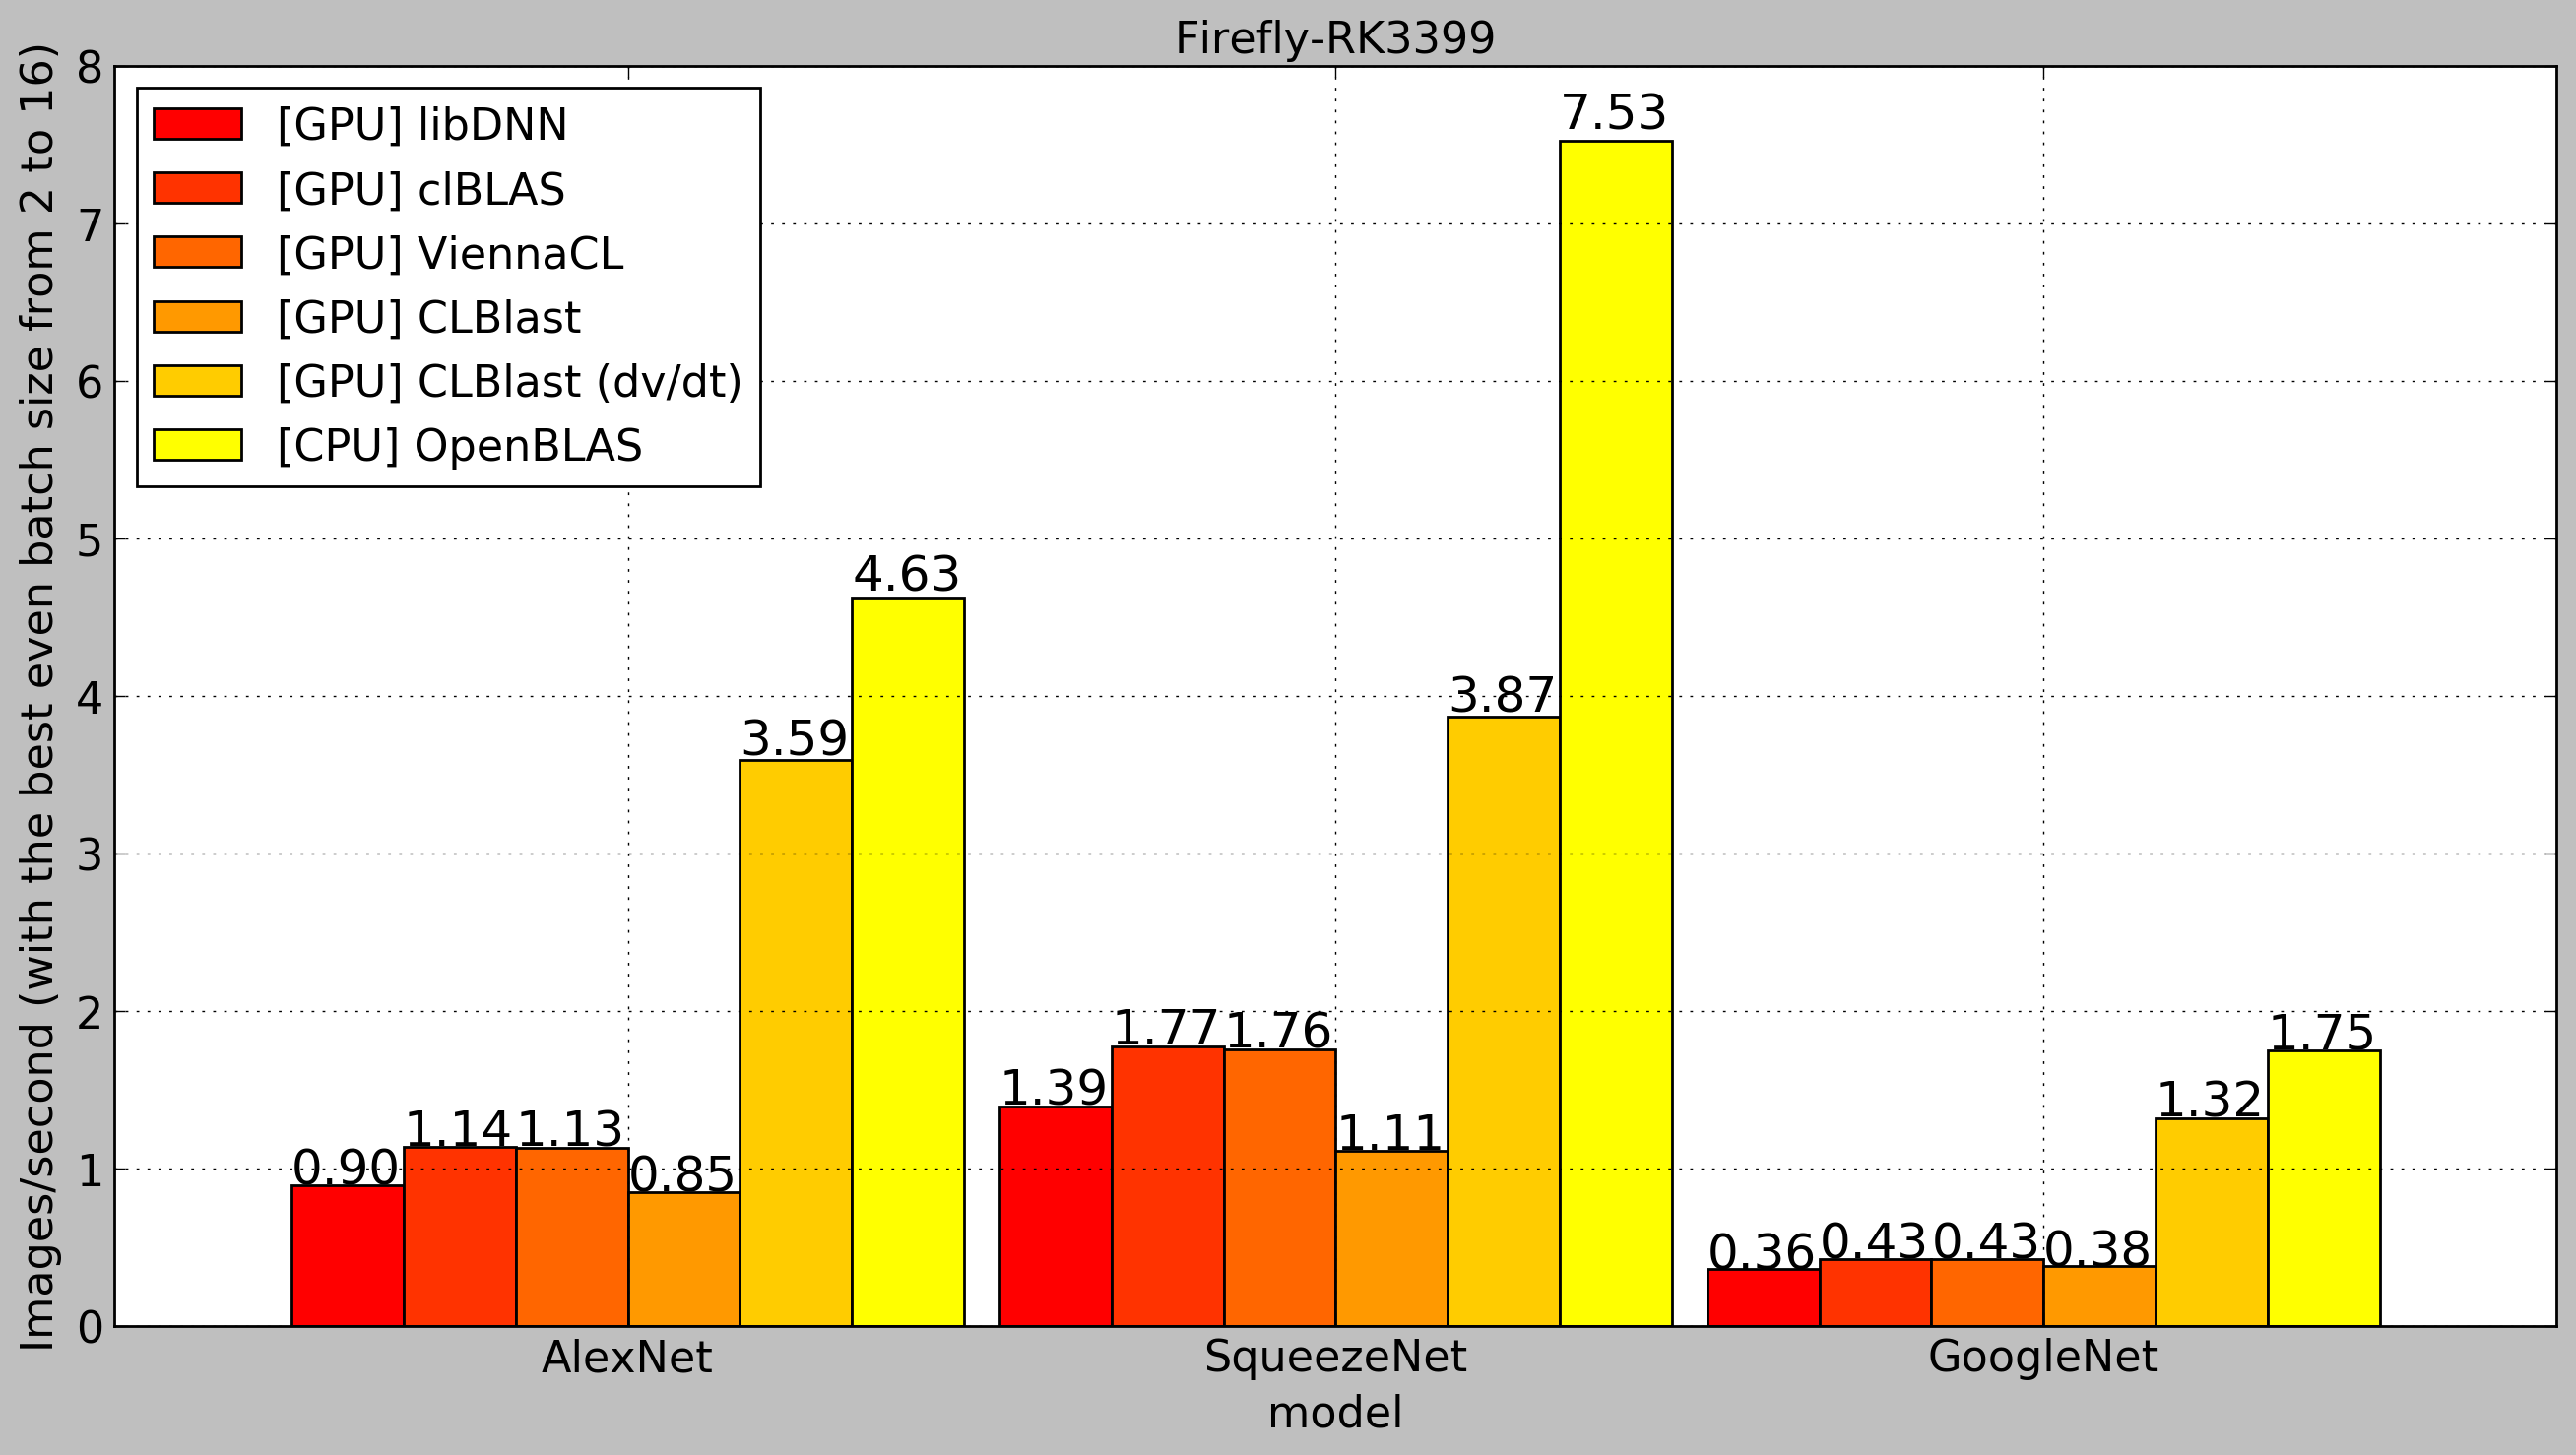

In [26]:
plot_max_num_images_per_second(df_mean_time_per_image, libs_to_drop=[], fontsize=18)

In [27]:
df_mean_time_per_image.min(axis=1)

model                     lib                       
bvlc-alexnet              cpu                            216.106042
                          opencl-clblas                  880.316667
                          opencl-clblast                1178.252083
                          opencl-clblast-tune            278.244583
                          opencl-libdnn-clblas          1283.939583
                          opencl-libdnn-clblast         1082.535000
                          opencl-libdnn-clblast-tune    1117.183333
                          opencl-libdnn-viennacl        1177.054167
                          opencl-viennacl                882.731000
bvlc-googlenet            cpu                            571.778333
                          opencl-clblas                 2345.326667
                          opencl-clblast                2629.436667
                          opencl-clblast-tune            757.242857
                          opencl-libdnn-clblas          2766.52

In [28]:
df_mean_time_per_image.idxmin(axis=1)

model                     lib                       
bvlc-alexnet              cpu                           16
                          opencl-clblas                 10
                          opencl-clblast                16
                          opencl-clblast-tune           16
                          opencl-libdnn-clblas          16
                          opencl-libdnn-clblast          2
                          opencl-libdnn-clblast-tune    16
                          opencl-libdnn-viennacl        16
                          opencl-viennacl               10
bvlc-googlenet            cpu                           10
                          opencl-clblas                 10
                          opencl-clblast                10
                          opencl-clblast-tune           14
                          opencl-libdnn-clblas          16
                          opencl-libdnn-clblast         16
                          opencl-libdnn-clblast-tune    16
   

In [29]:
df_time = df_time[platform_id].reorder_levels(['model', 'lib', 'batch_size'], axis=1)
display_in_full(df_time)

model         bvlc-alexnet                                               \
lib                    cpu                                                
batch_size              2        4        6        8        10       12   
repetition_id                                                             
0                  696.081  1021.68  1432.68  1851.28  2281.11  2719.28   
1                  692.967  1021.85  1436.30  1847.25  2281.76  2718.07   
2                  694.931  1021.48  1466.81  1842.83  2286.40  2728.06   

model                           bvlc-googlenet                             \
lib                                        cpu                              
batch_size          14       16             2        4        6        8    
repetition_id                                                               
0              3099.74  3457.39        1156.18  2297.33  3448.69  4598.89   
1              3096.30  3458.00        1542.93  2293.55  3442.86  4577.89   
2              3100.51  3457.70        1153.90  2295.91  3443.64  4576.61   

model                                              deepscale-squeezenet-1.1  \
lib                                                                     cpu   
batch_size          10       12       14        16                       2    
repetition_id                                                                 
0              5707.03  6846.76  8895.40  10179.30                  268.374   
1              5733.81  6877.85  7978.87  10174.10                  268.214   
2              5712.51  6889.41  7977.15   9128.31                  267.982   

model                                                                         \
lib                                                                            
batch_size          4        6        8        10       12       14       16   
repetition_id                                                                  
0              537.391  799.161  1064.90  1328.73  1594.10  1859.91  2123.80   
1              534.154  796.585  1063.01  1330.18  1597.00  1856.77  2131.58   
2              536.091  800.099  1069.42  1329.46  1592.29  1865.05  2120.80   

model          bvlc-alexnet                                               \
lib           opencl-clblas                                                
batch_size               2        4        6        8        10       12   
repetition_id                                                              
0                   3667.75  5673.65  7623.63  9549.93  8802.05  13498.8   
1                   3729.72  5682.20  6144.67  8778.12  8803.49  13568.6   
2                   3732.55  5656.22  7614.73  8764.36  8803.96  13605.6   

model                           bvlc-googlenet                             \
lib                              opencl-clblas                              
batch_size          14       16             2        4        6        8    
repetition_id                                                               
0              15578.0  15794.9        4942.31  9590.50  14250.0  19081.8   
1              15525.1  15771.5        4959.83  9579.35  14210.9  19051.7   
2              15477.2  17487.2        4961.38  9577.53  14310.0  18870.7   

model                                             deepscale-squeezenet-1.1  \
lib                                                          opencl-clblas   
batch_size          10       12       14       16                       2    
repetition_id                                                                
0              23445.9  28370.6  32840.7  37597.0                  1325.07   
1              23440.6  28347.3  32879.0  37563.1                  1329.41   
2              23473.3  28198.9  33107.2  37584.0                  1309.30   

model                                                                         \
lib                                                                            
batch_size          4        6        8

In [30]:
df_time_per_image = df_time / (batch_sizes*(len(df_time.columns)/len(batch_sizes)))
display_in_full(df_time_per_image)

model         bvlc-alexnet                                            \
lib                    cpu                                             
batch_size              2         4           6          8        10   
repetition_id                                                          
0                 348.0405  255.4200  238.780000  231.41000  228.111   
1                 346.4835  255.4625  239.383333  230.90625  228.176   
2                 347.4655  255.3700  244.468333  230.35375  228.640   

model                                             bvlc-googlenet            \
lib                                                          cpu             
batch_size             12          14          16             2         4    
repetition_id                                                                
0              226.606667  221.410000  216.086875        578.090  574.3325   
1              226.505833  221.164286  216.125000        771.465  573.3875   
2              227.338333  221.465000  216.106250        576.950  573.9775   

model                                                                  \
lib                                                                     
batch_size             6          8        10          12          14   
repetition_id                                                           
0              574.781667  574.86125  570.703  570.563333  635.385714   
1              573.810000  572.23625  573.381  573.154167  569.919286   
2              573.940000  572.07625  571.251  574.117500  569.796429   

model                     deepscale-squeezenet-1.1                         \
lib                                            cpu                          
batch_size             16                       2          4           6    
repetition_id                                                               
0              636.206250                  134.187  134.34775  133.193500   
1              635.881250                  134.107  133.53850  132.764167   
2              570.519375                  133.991  134.02275  133.349833   

model                                                                 \
lib                                                                    
batch_size            8        10          12          14         16   
repetition_id                                                          
0              133.11250  132.873  132.841667  132.850714  132.73750   
1              132.87625  133.018  133.083333  132.626429  133.22375   
2              133.67750  132.946  132.690833  133.217857  132.55000   

model          bvlc-alexnet                                               \
lib           opencl-clblas                                                
batch_size               2          4            6           8        10   
repetition_id                                                              
0                  1833.875  1418.4125  1270.605000  1193.74125  880.205   
1                  1864.860  1420.5500  1024.111667  1097.26500  880.349   
2                  1866.275  1414.0550  1269.121667  1095.54500  880.396   

model                                               bvlc-googlenet             \
lib                                                  opencl-clblas              
batch_size              12           14          16             2          4    
repetition_id                                                                   
0              1124.900000  1112.714286   987.18125       2471.155  2397.6250   
1              1130.716667  1108.935714   985.71875       2479.915  2394.8375   
2              1133.800000  1105.514286  1092.95000       2480.690  2394.3825   

model                                                                     \
lib                                                                        
batch_size              6          8        10           12           14   
repetition_id                                                 

In [31]:
df_min_time_per_image_index = pd.DataFrame(df_mean_time_per_image.idxmin(axis=1)).set_index(0, append=True).index.values
df_min_time_per_image_index

array([(u'bvlc-alexnet', u'cpu', 16),
       (u'bvlc-alexnet', u'opencl-clblas', 10),
       (u'bvlc-alexnet', u'opencl-clblast', 16),
       (u'bvlc-alexnet', u'opencl-clblast-tune', 16),
       (u'bvlc-alexnet', u'opencl-libdnn-clblas', 16),
       (u'bvlc-alexnet', u'opencl-libdnn-clblast', 2),
       (u'bvlc-alexnet', u'opencl-libdnn-clblast-tune', 16),
       (u'bvlc-alexnet', u'opencl-libdnn-viennacl', 16),
       (u'bvlc-alexnet', u'opencl-viennacl', 10),
       (u'bvlc-googlenet', u'cpu', 10),
       (u'bvlc-googlenet', u'opencl-clblas', 10),
       (u'bvlc-googlenet', u'opencl-clblast', 10),
       (u'bvlc-googlenet', u'opencl-clblast-tune', 14),
       (u'bvlc-googlenet', u'opencl-libdnn-clblas', 16),
       (u'bvlc-googlenet', u'opencl-libdnn-clblast', 16),
       (u'bvlc-googlenet', u'opencl-libdnn-clblast-tune', 16),
       (u'bvlc-googlenet', u'opencl-libdnn-viennacl', 16),
       (u'bvlc-googlenet', u'opencl-viennacl', 12),
       (u'deepscale-squeezenet-1.1', u'cpu', 16

In [32]:
df_model_lib = df_time_per_image[df_min_time_per_image_index] \
    .stack(['model', 'lib']) \
    .sum(axis=1)

<a id="plot_models"></a>
## Plot by Caffe models

In [33]:
df_model_lib_mean = df_model_lib.groupby(level=['model', 'lib']).mean()
df_model_lib_std  = df_model_lib.groupby(level=['model', 'lib']).std()

<a id="plot_models_all"></a>
### All libs

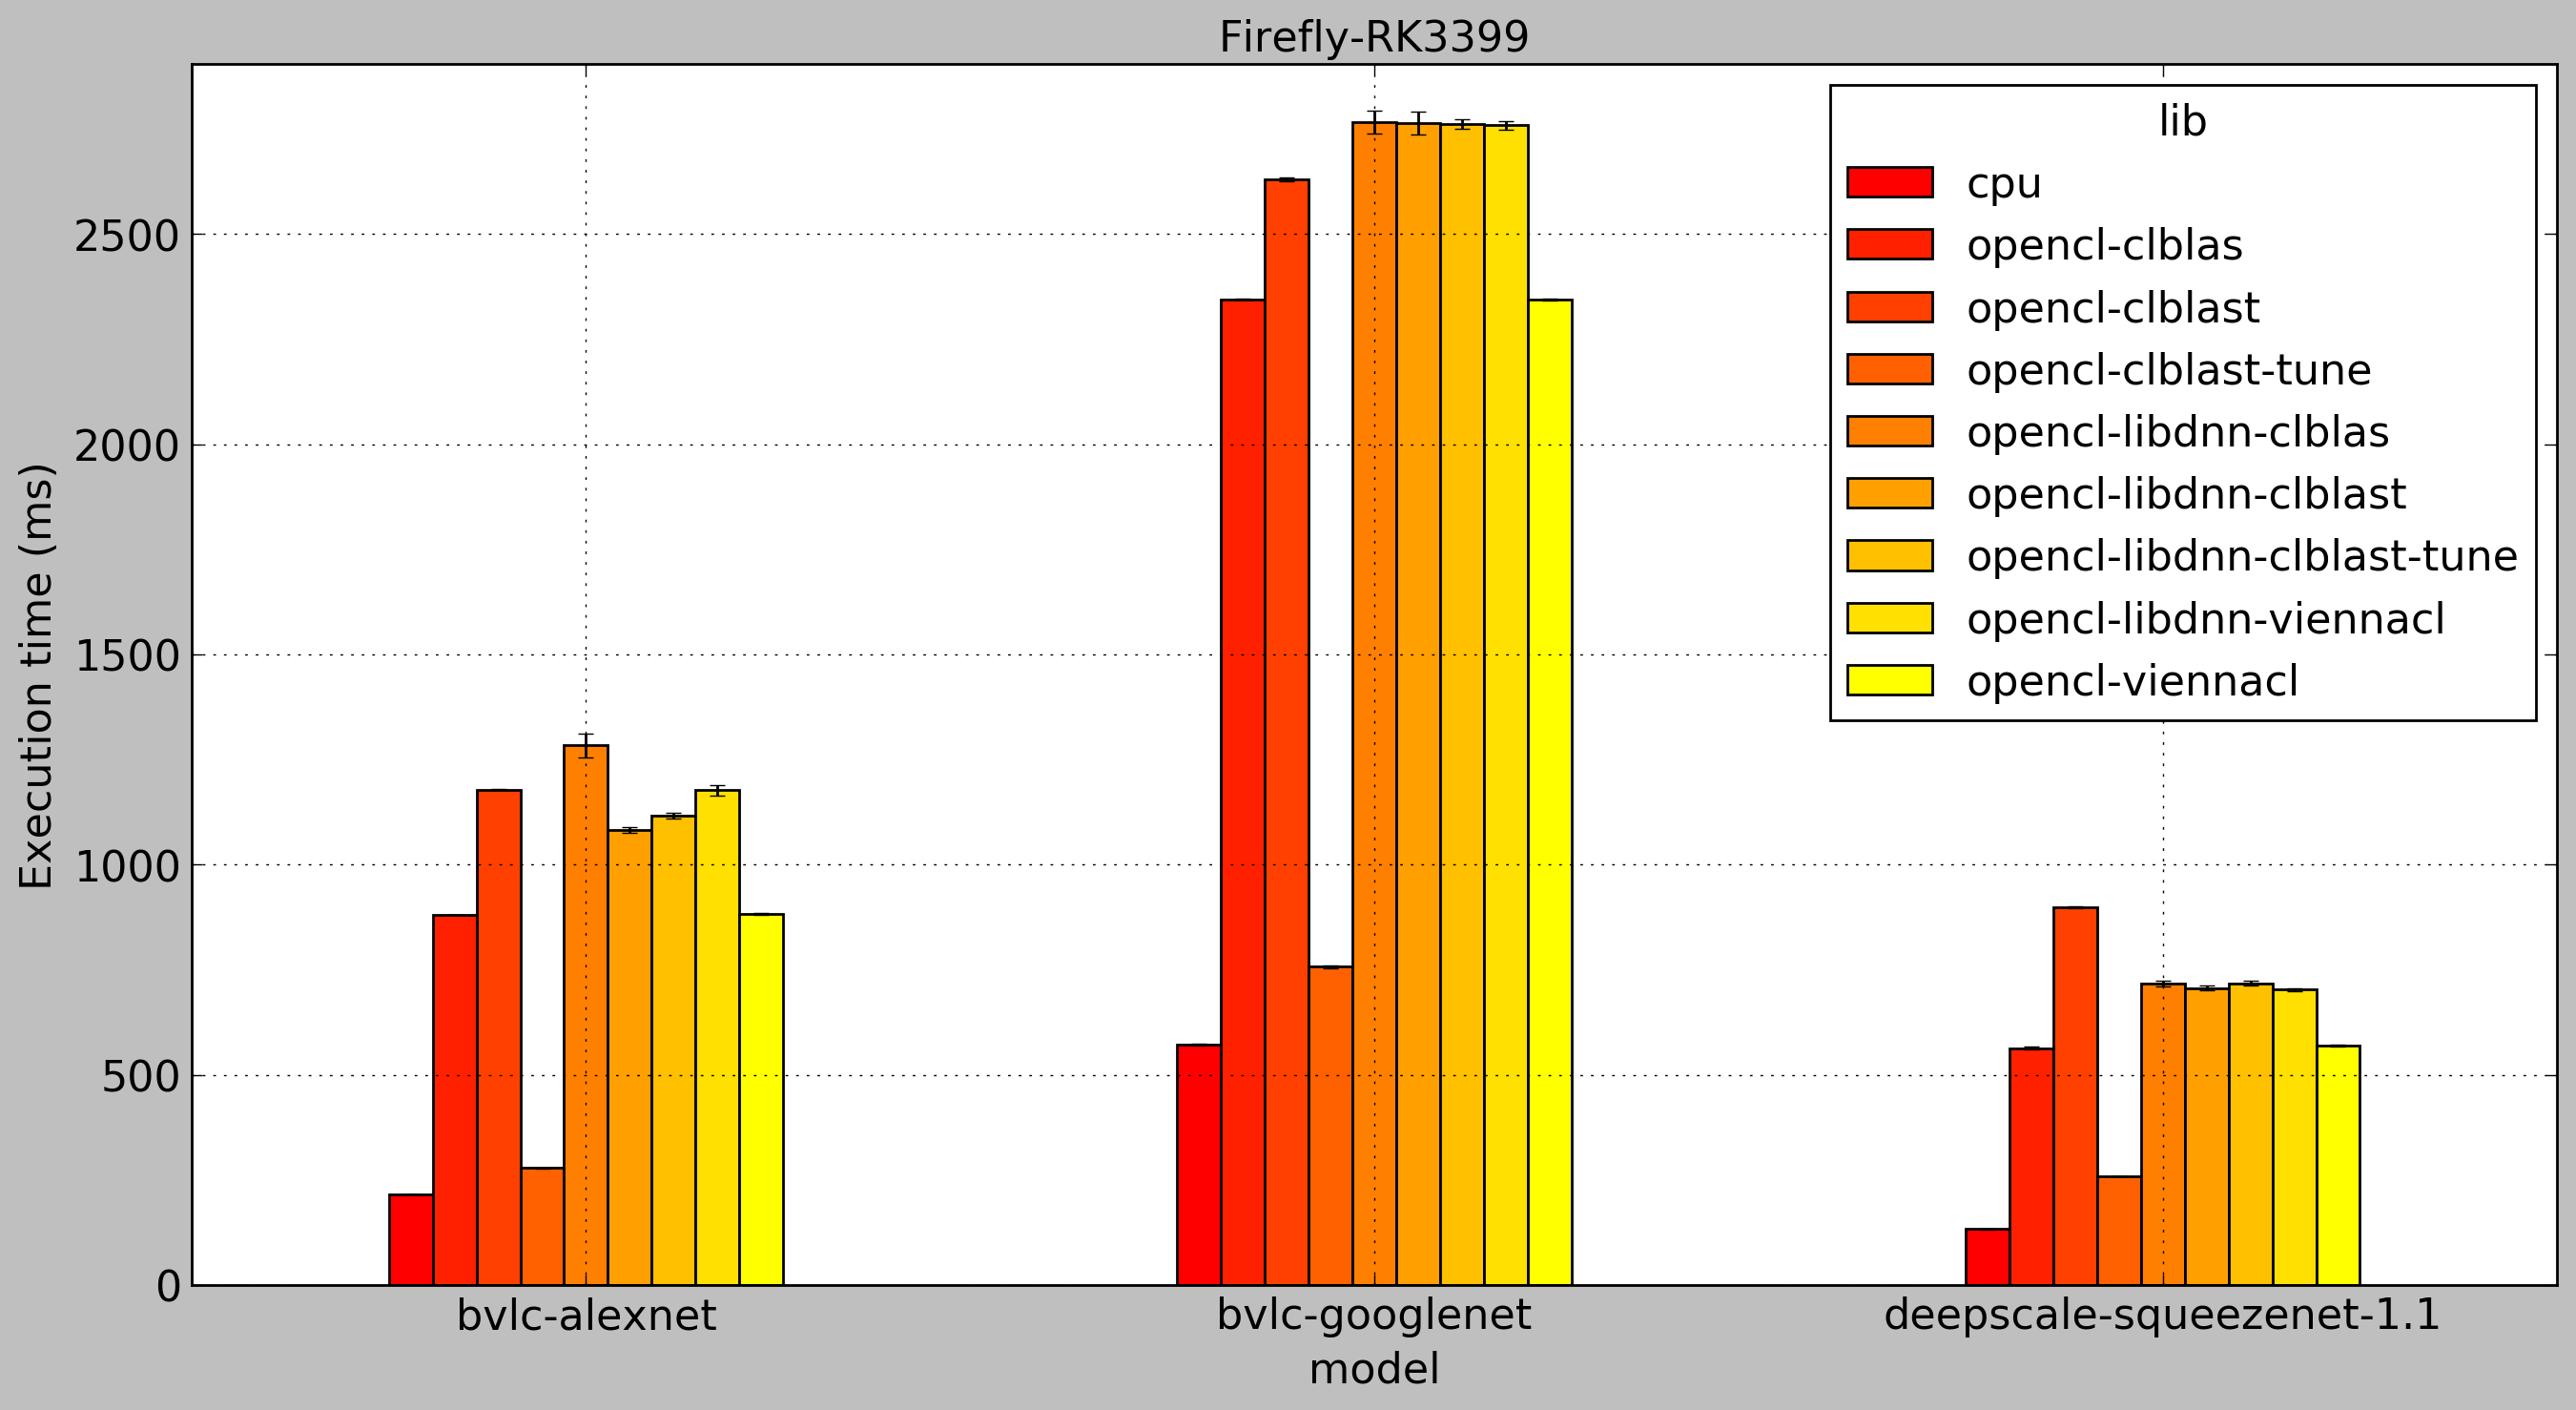

In [34]:
mean = df_model_lib_mean.unstack('lib')
std  = df_model_lib_std.unstack('lib')
plot(mean, std)

<a id="plot_models_gpu"></a>
### Only GPU libs

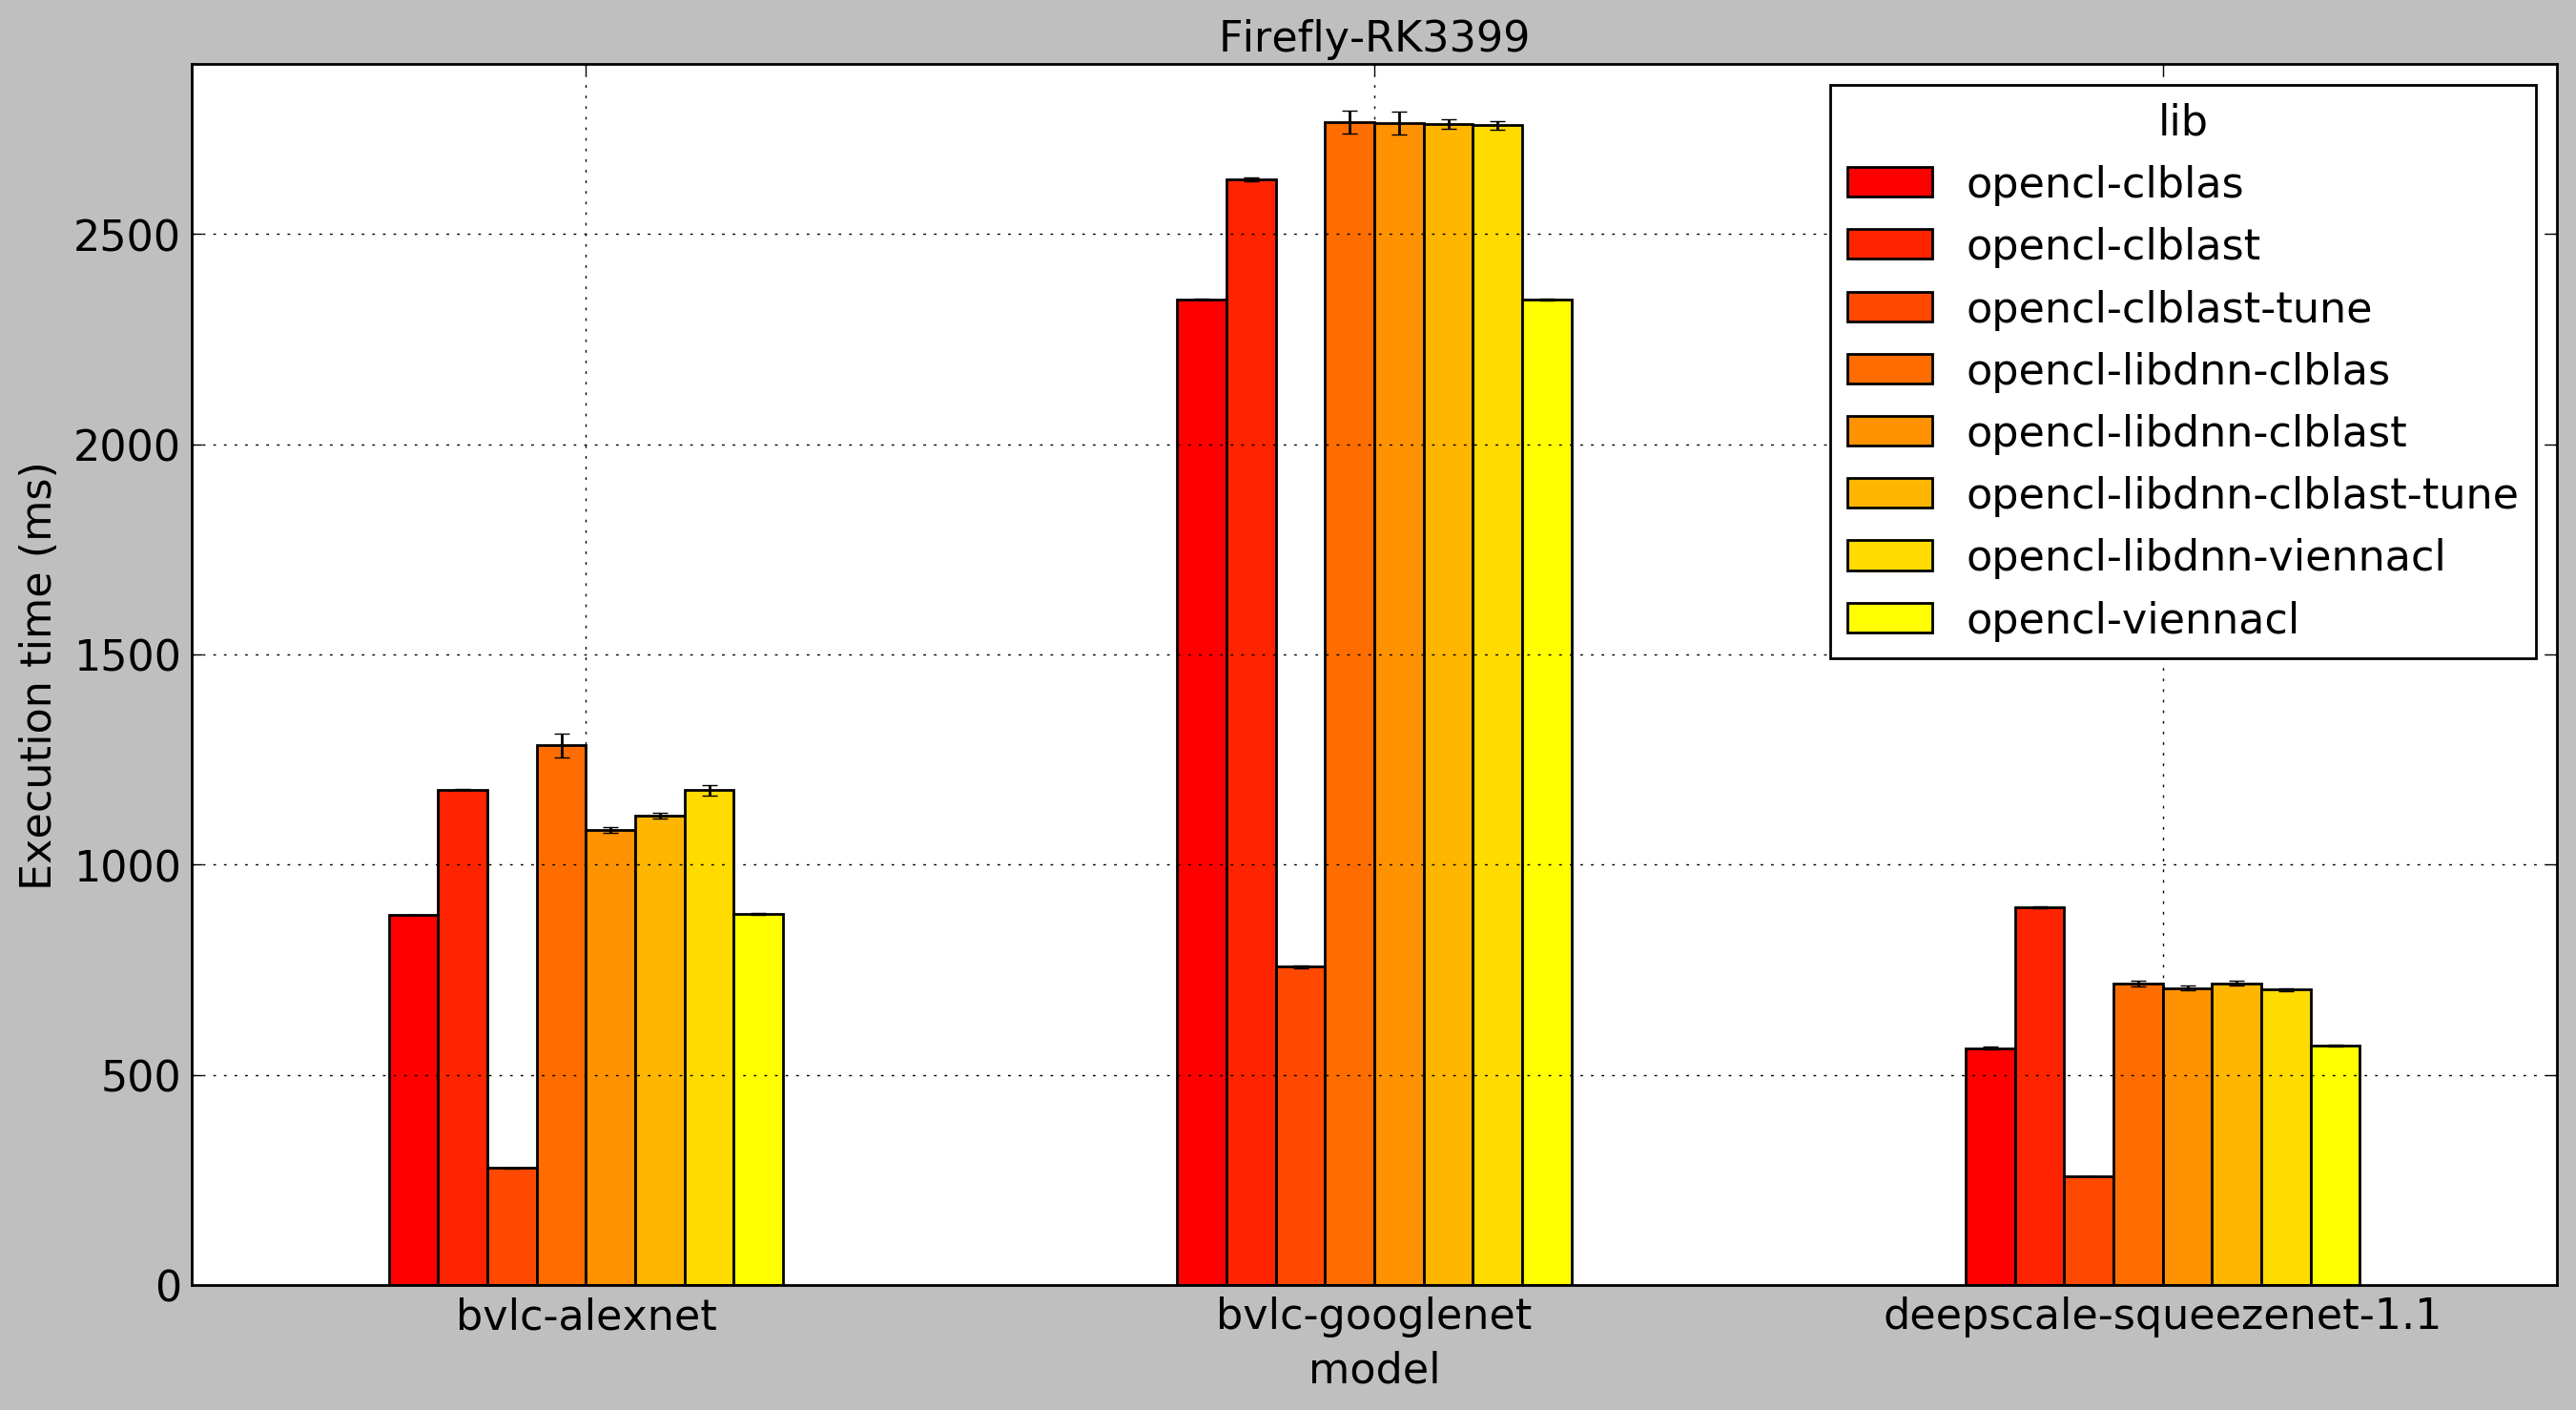

In [35]:
mean = df_model_lib_mean.unstack('lib').drop('cpu', axis=1, errors='ignore')
std  = df_model_lib_std.unstack('lib').drop('cpu', axis=1, errors='ignore')
plot(mean, std)

<a id="plot_models_clblast"></a>
### Only CLBlast-based libs (default vs tuned)

In [36]:
clblast_libs = [ 'opencl-clblast', 'opencl-clblast-tune' ]

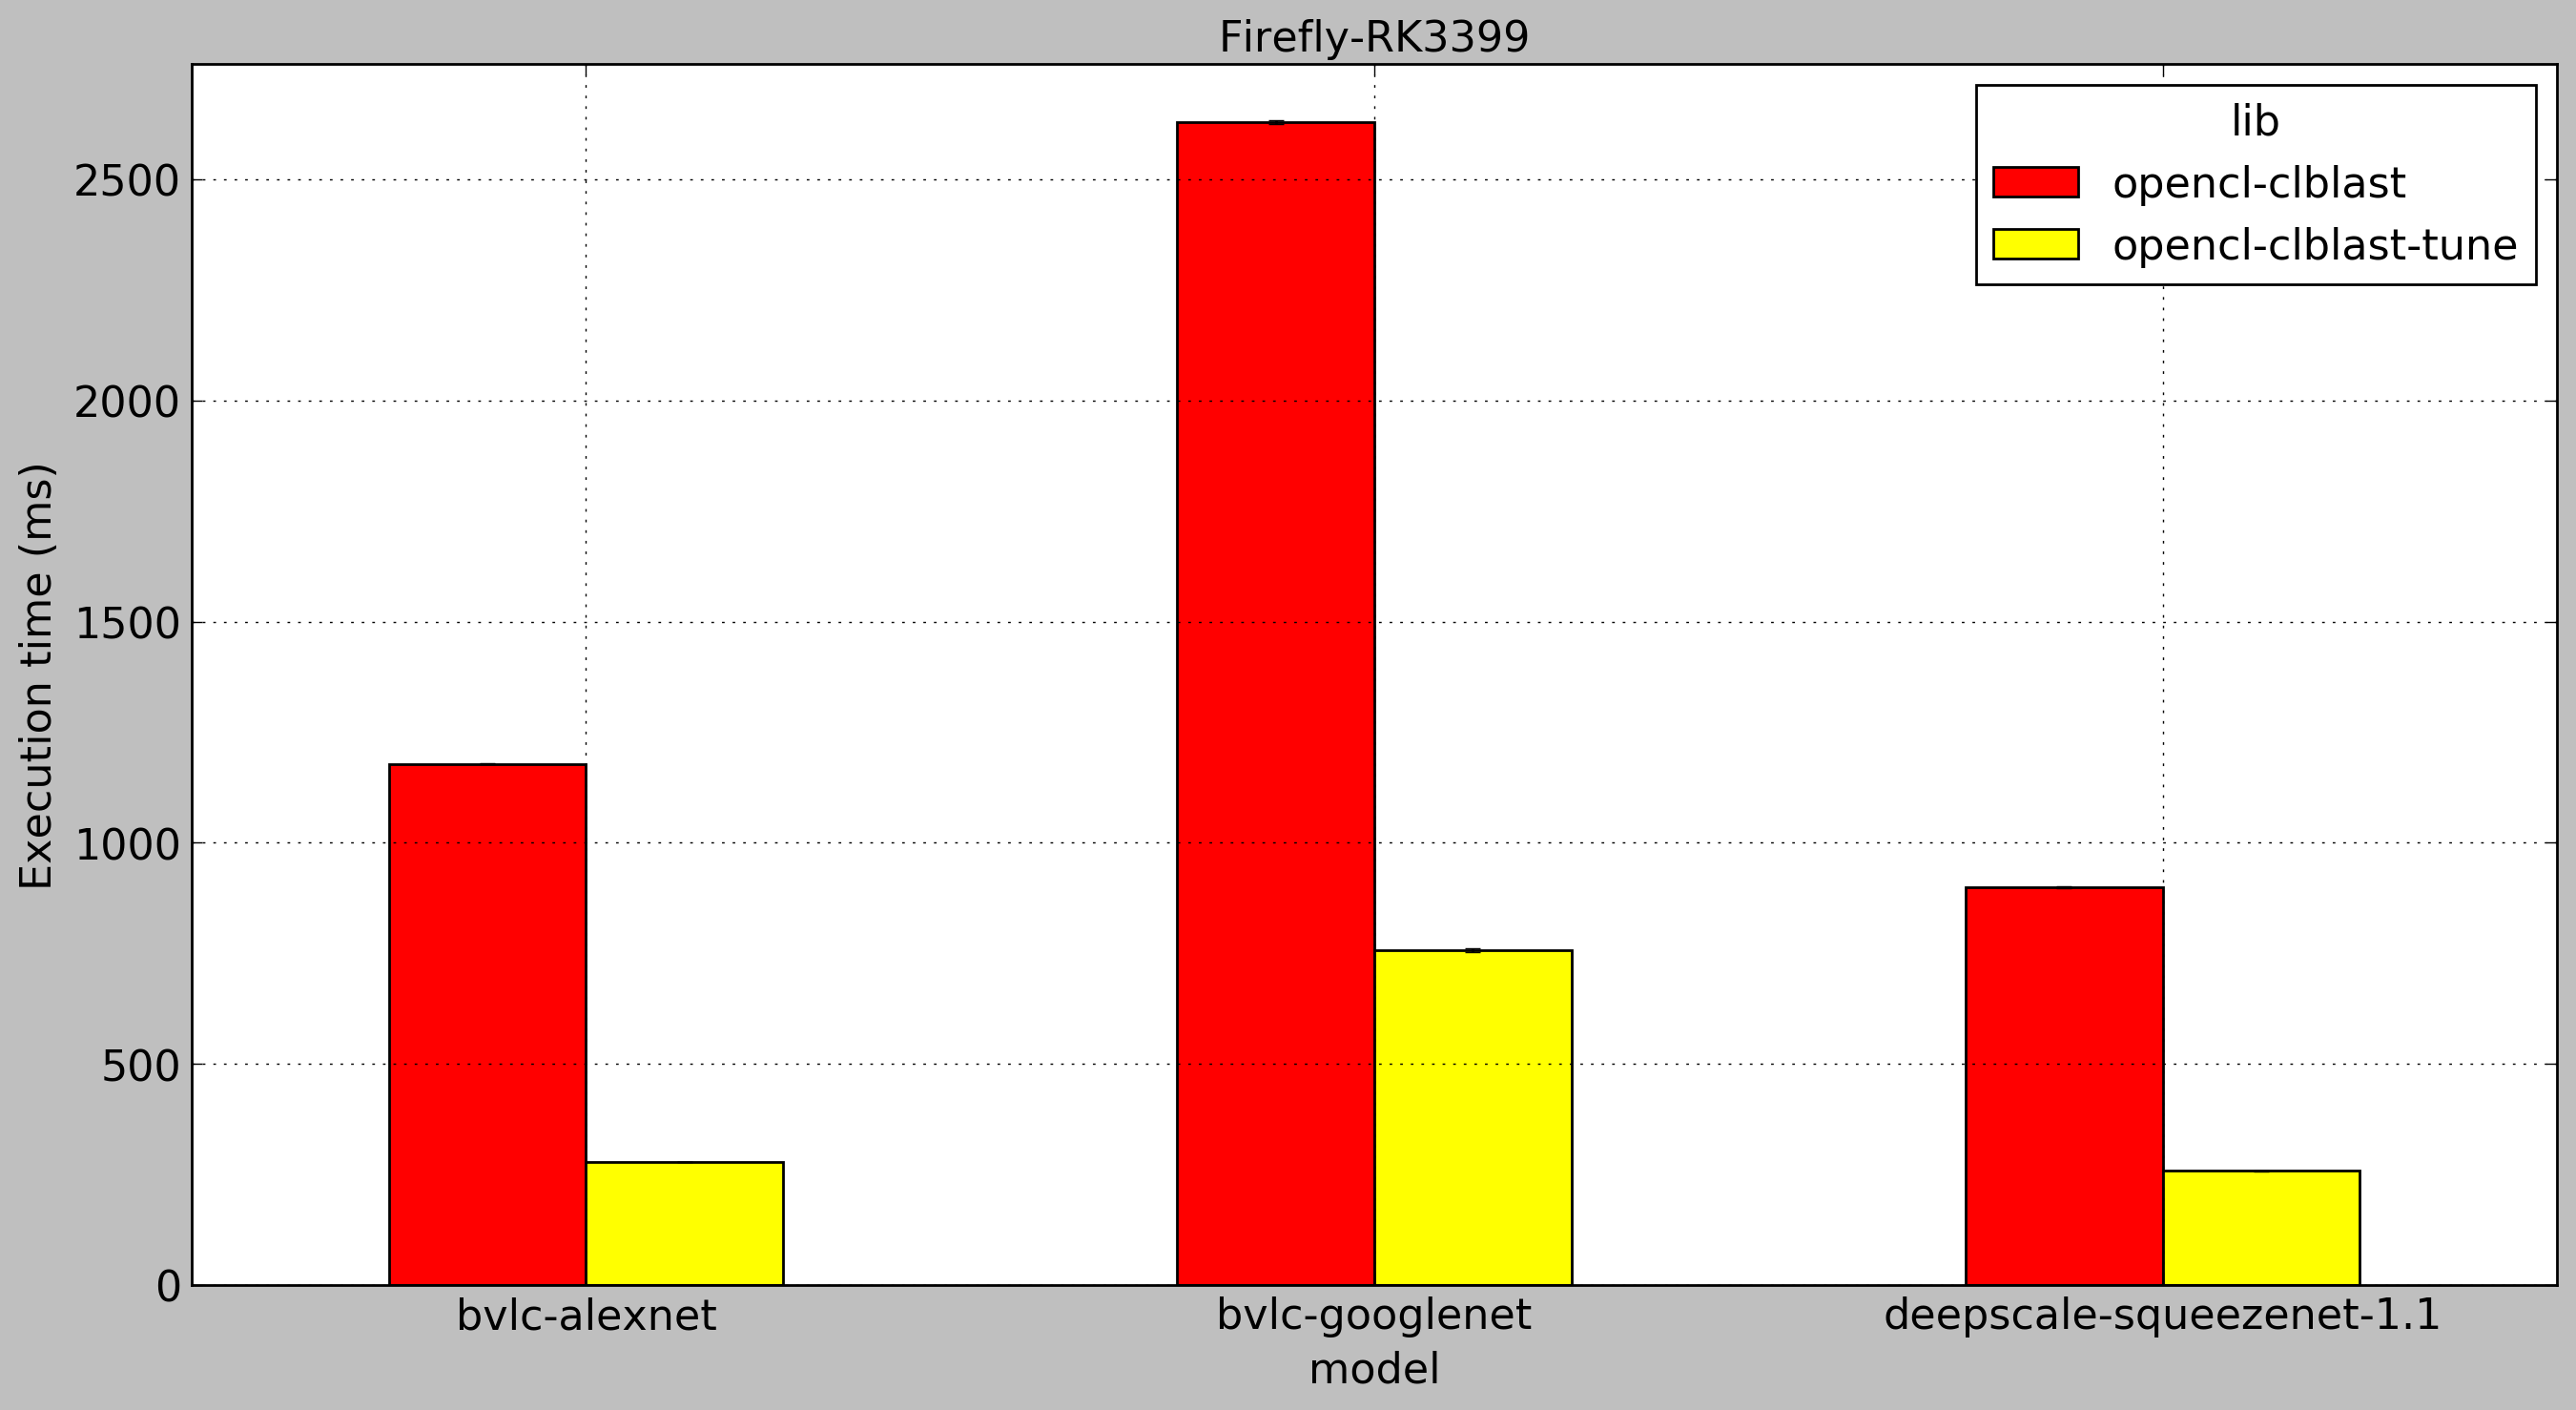

In [37]:
df_model_clblast_libs = df_model_lib \
    .reorder_levels(['lib', 'model','repetition_id']) \
    .sort_index() \
    .loc[clblast_libs]
mean = df_model_clblast_libs.groupby(level=['lib', 'model']).mean().unstack('lib')
std = df_model_clblast_libs.groupby(level=['lib', 'model']).std().unstack('lib')
plot(mean, std)

In [38]:
mean.div(mean['opencl-clblast-tune'], axis='index')

lib                       opencl-clblast  opencl-clblast-tune
model                                                        
bvlc-alexnet                    4.234591                  1.0
bvlc-googlenet                  3.472382                  1.0
deepscale-squeezenet-1.1        3.477162                  1.0

<a id="plot_models_libdnn"></a>
### Only libDNN-based libs

In [39]:
libdnn_libs = libdnn_libs_to_drop + [ 'opencl-libdnn-clblast-tune' ]
libdnn_libs

['opencl-libdnn-clblas',
 'opencl-libdnn-clblast',
 'opencl-libdnn-viennacl',
 'opencl-libdnn-clblast-tune']

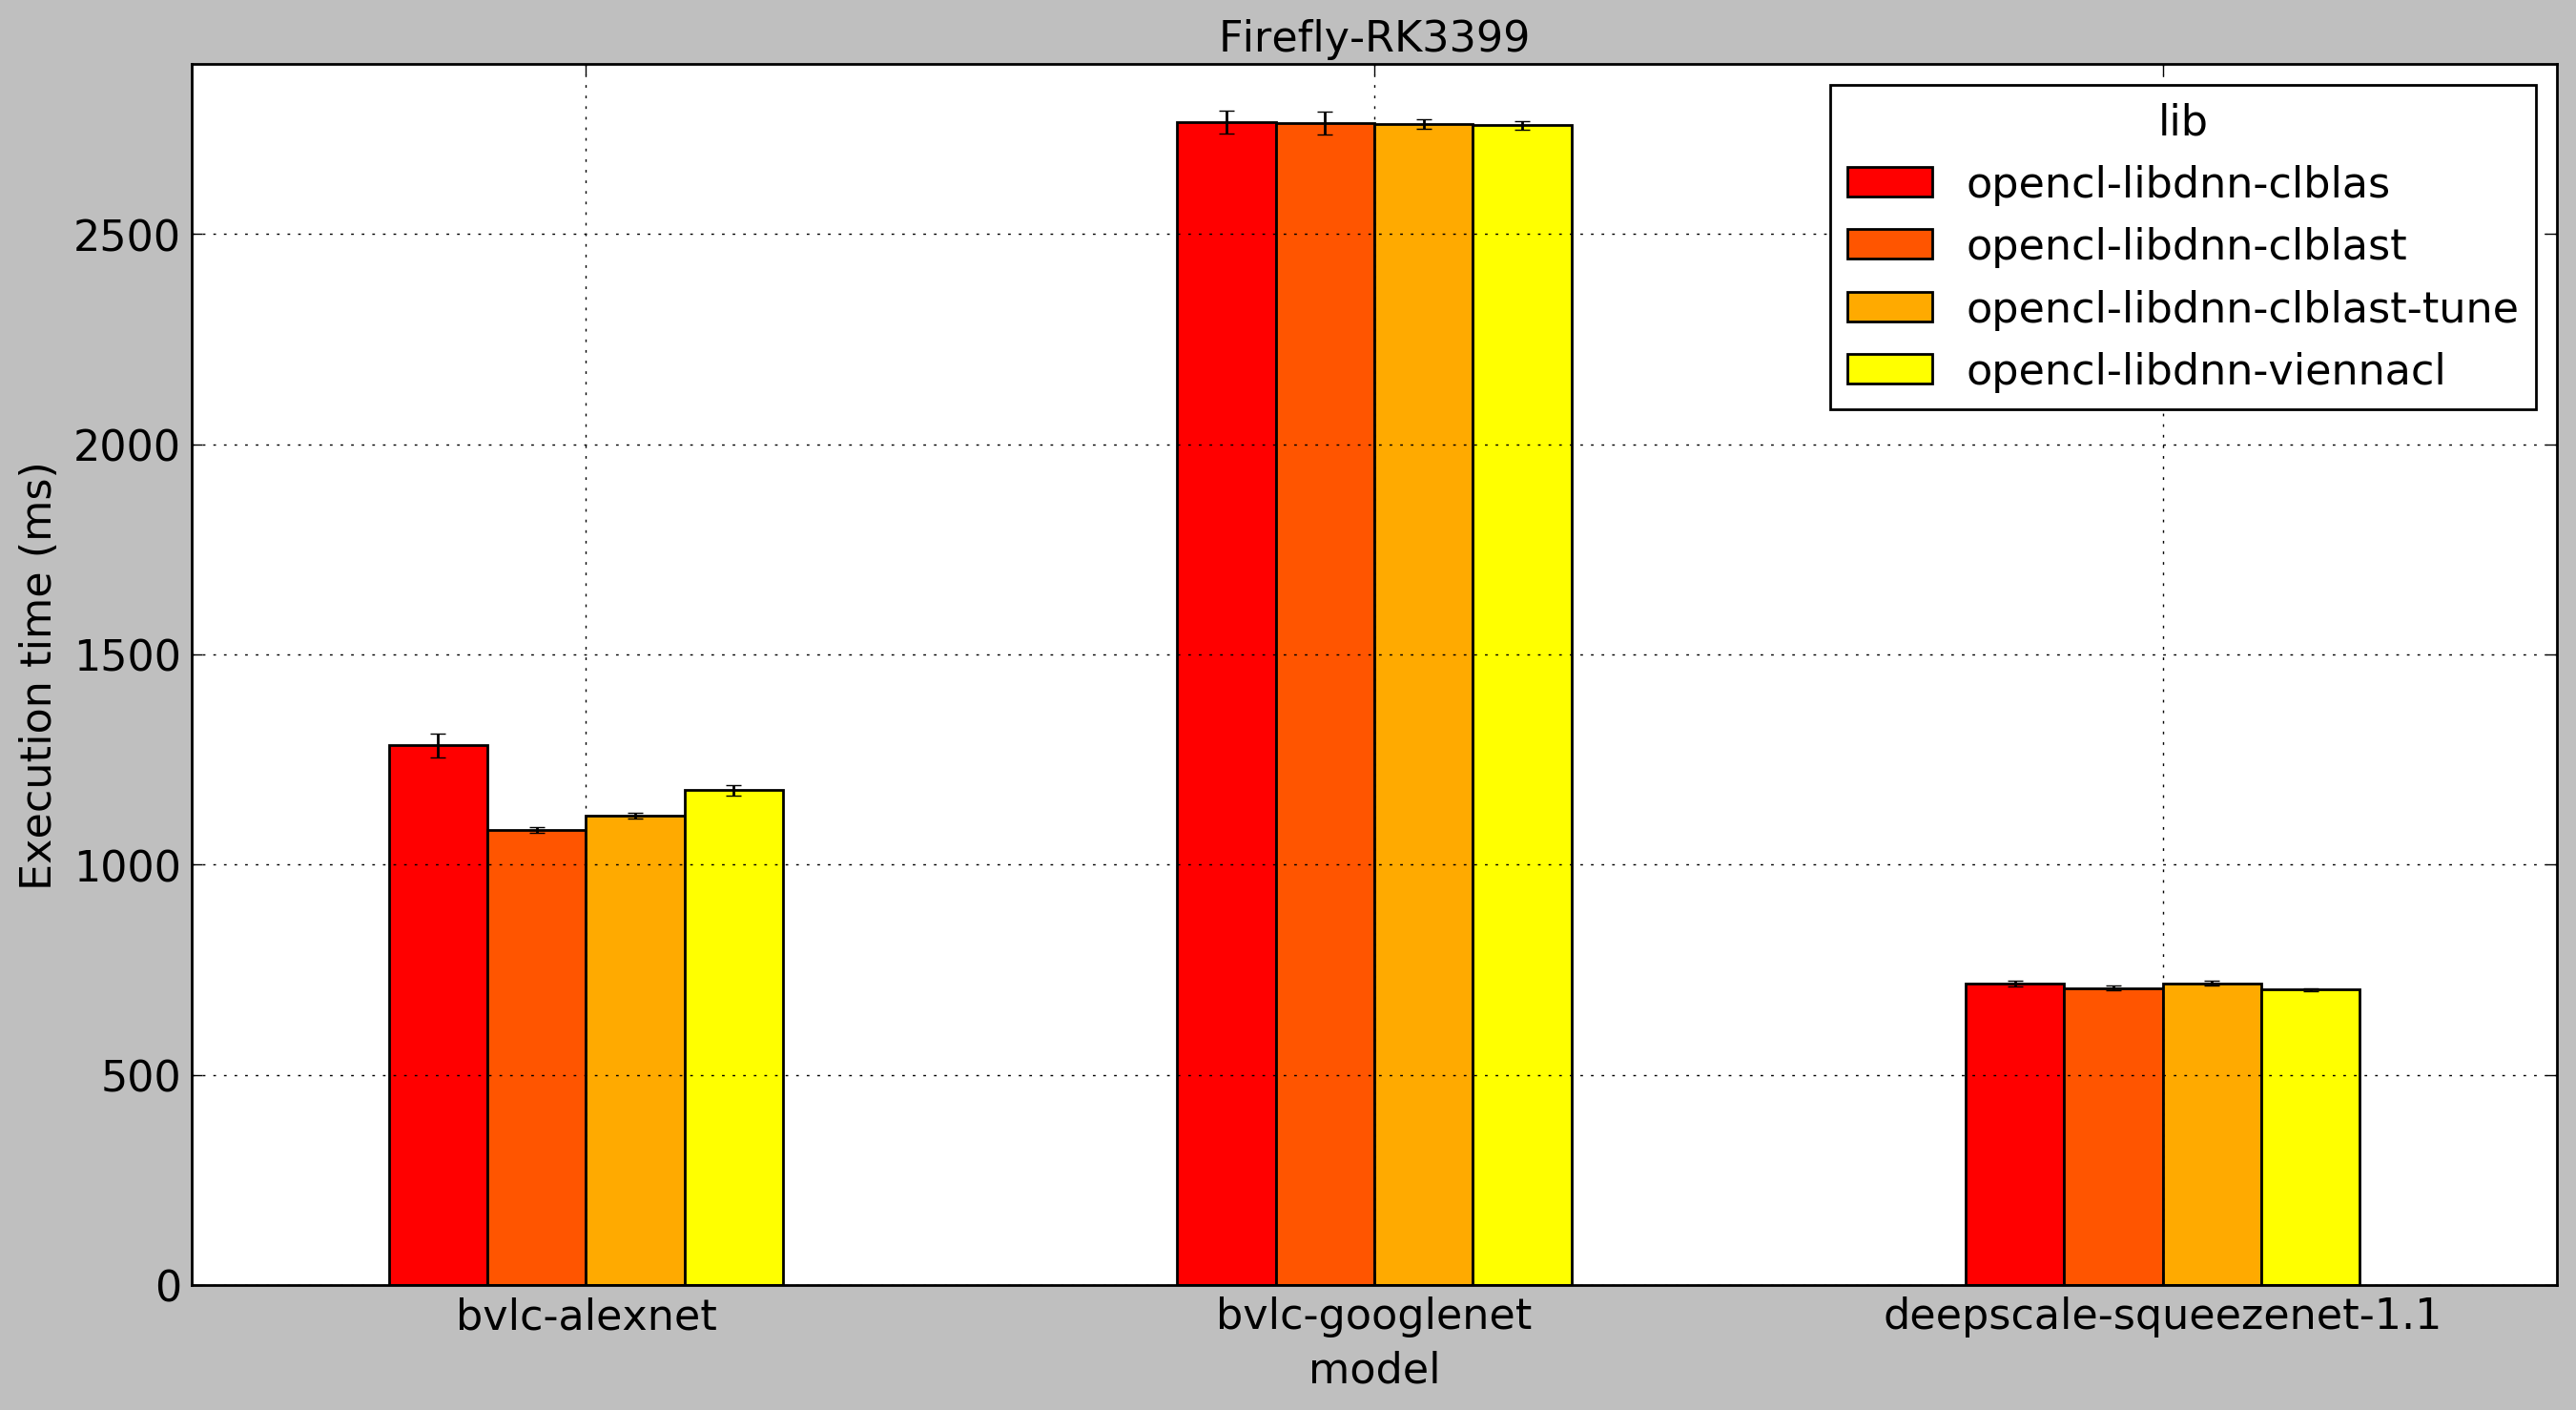

In [40]:
df_model_libdnn_libs = df_model_lib \
    .reorder_levels(['lib', 'model','repetition_id']) \
    .sort_index() \
    .loc[libdnn_libs]
mean = df_model_libdnn_libs.groupby(level=['lib', 'model']).mean().unstack('lib')
std = df_model_libdnn_libs.groupby(level=['lib', 'model']).std().unstack('lib')
plot(mean, std)

In [41]:
mean.div(mean['opencl-libdnn-clblast-tune'], axis='index')

lib                       opencl-libdnn-clblas  opencl-libdnn-clblast  \
model                                                                   
bvlc-alexnet                          1.149265               0.968986   
bvlc-googlenet                        1.001912               1.001148   
deepscale-squeezenet-1.1              0.998963               0.983650   

lib                       opencl-libdnn-clblast-tune  opencl-libdnn-viennacl  
model                                                                         
bvlc-alexnet                                     1.0                1.053591  
bvlc-googlenet                                   1.0                0.999054  
deepscale-squeezenet-1.1                         1.0                0.979084

<a id="plot_libs"></a>
## Plot by Caffe libs

<a id="plot_libs_all"></a>
### All models, all libs

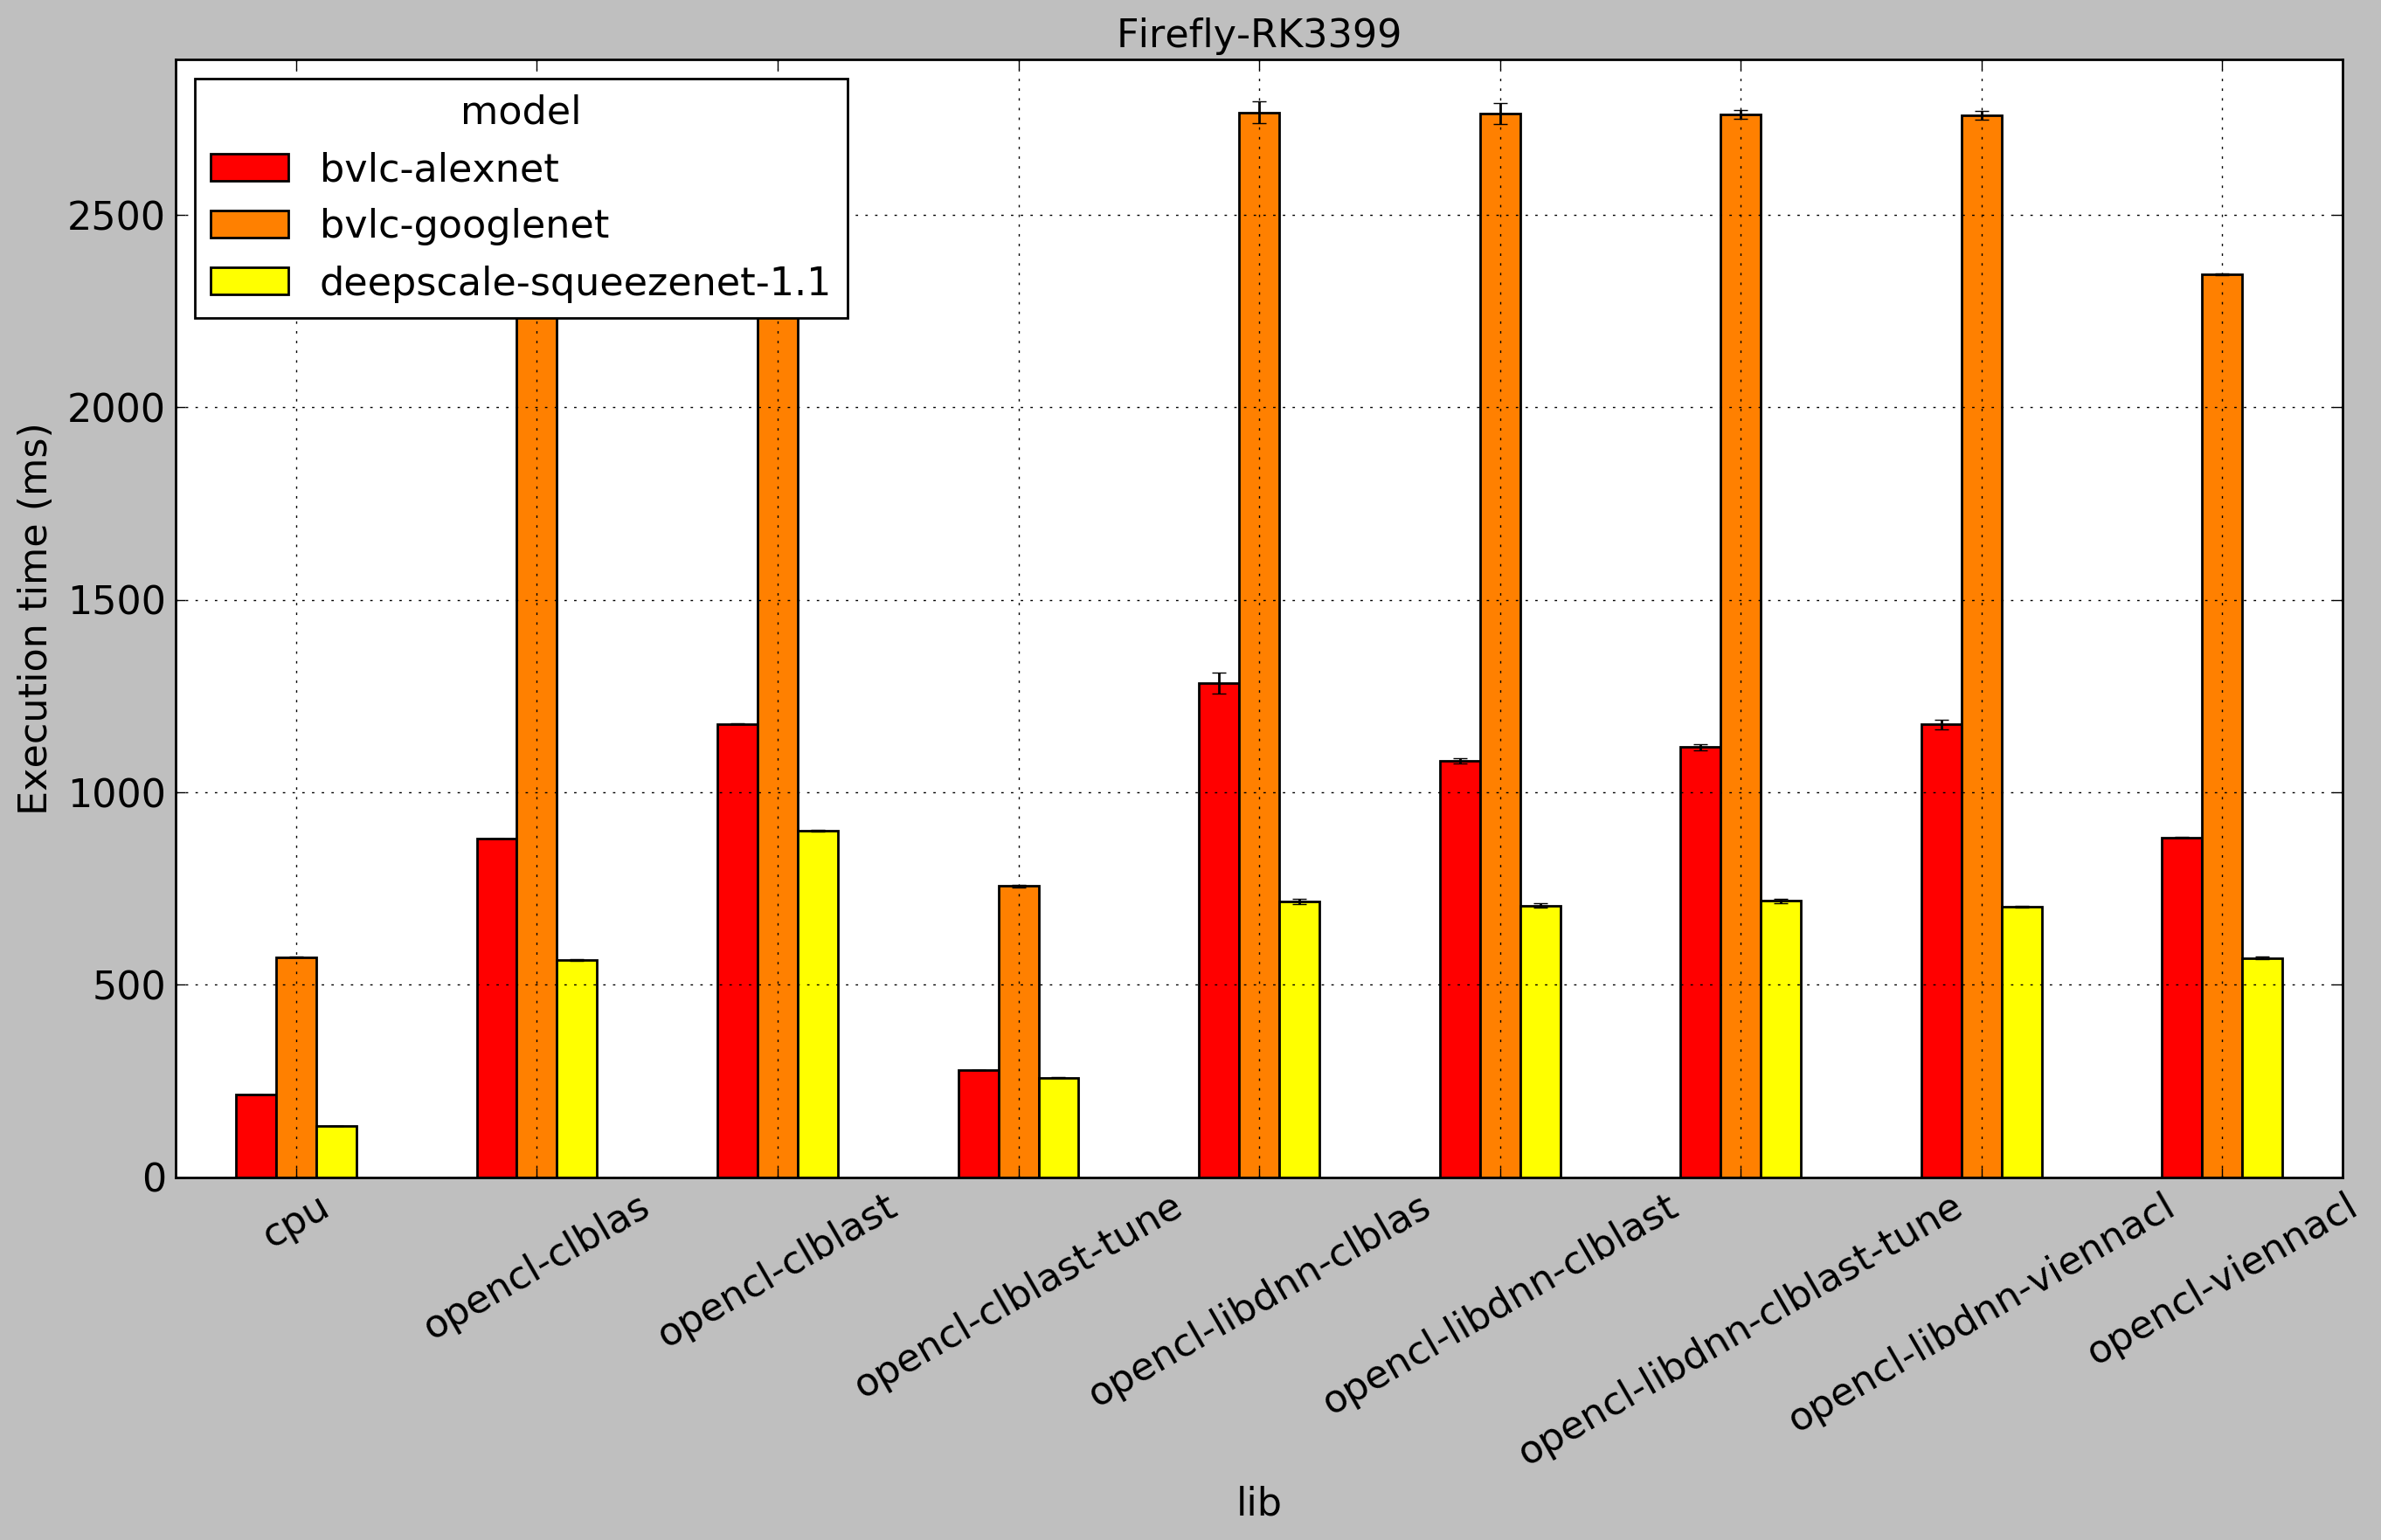

In [42]:
mean = df_model_lib_mean.unstack('model')
std  = df_model_lib_std.unstack('model')
plot(mean, std, rot=30)

<a id="plot_libs_gpu"></a>
### All models, only GPU libs

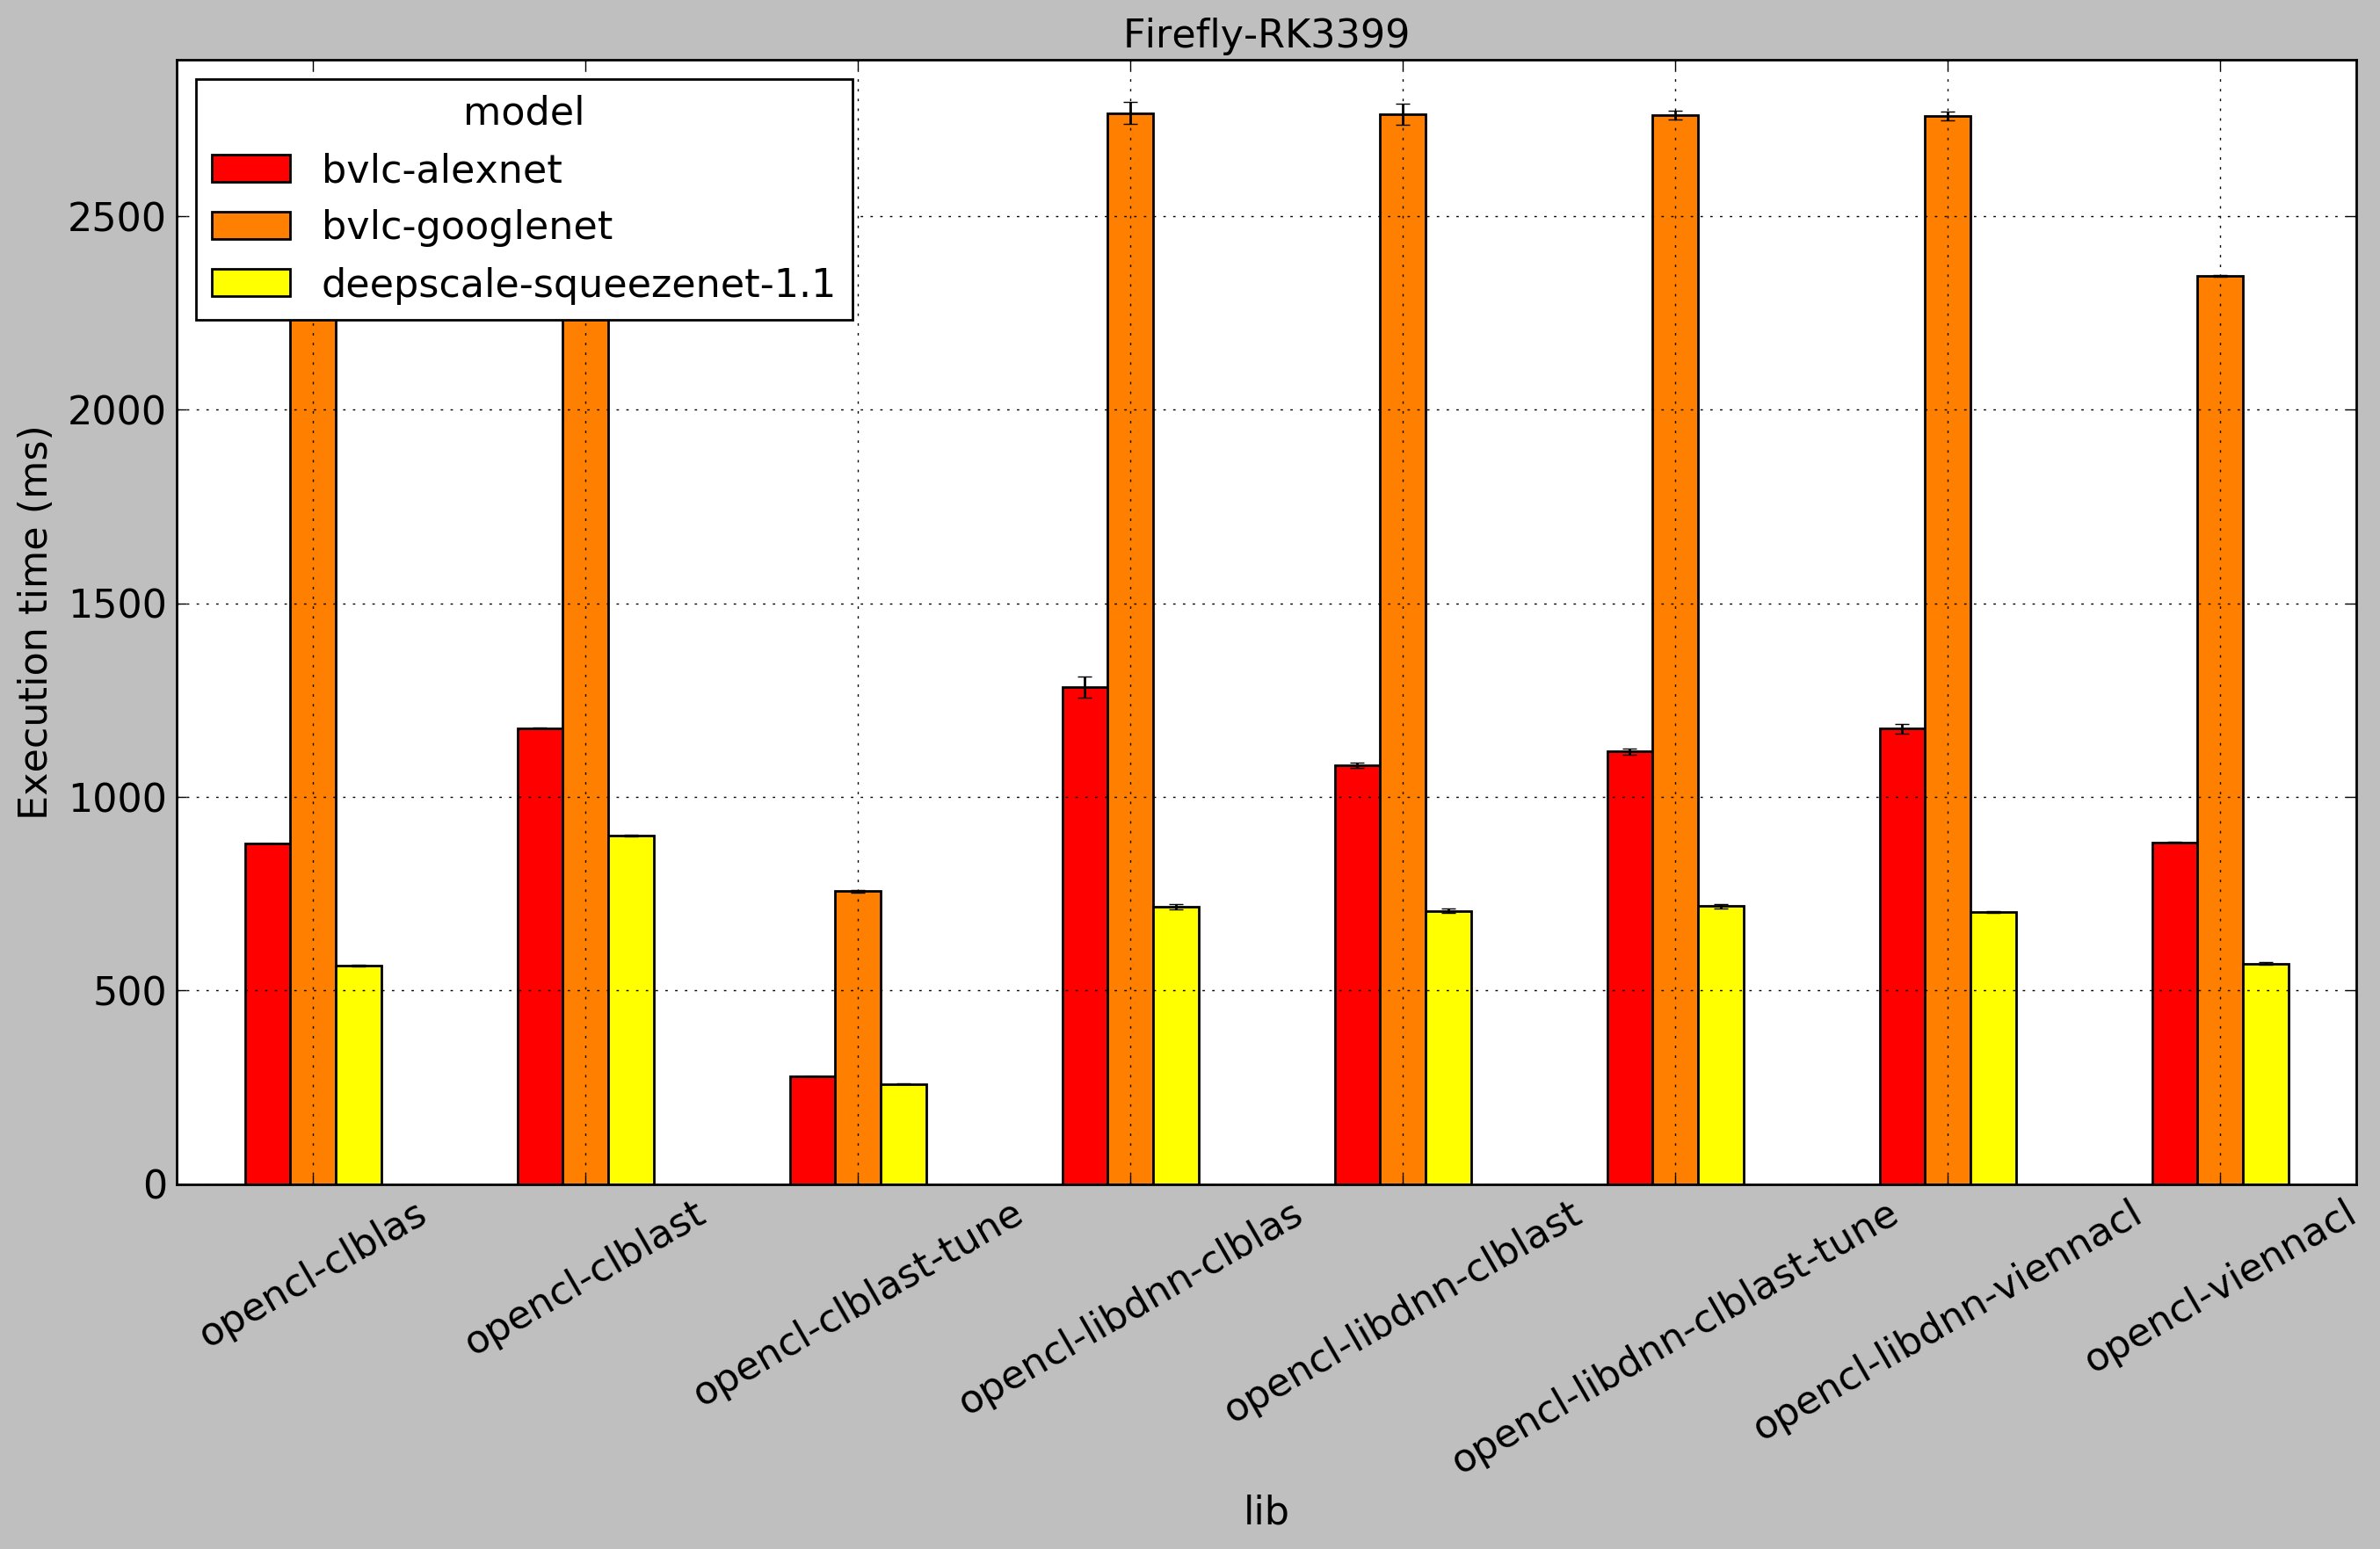

In [43]:
mean = df_model_lib_mean.unstack('model').drop('cpu', axis=0, errors='ignore')
std  = df_model_lib_std.unstack('model').drop('cpu', axis=0, errors='ignore')
plot(mean, std, rot=30)

<a id="plot_libs_alexnet"></a>
### Only models with AlexNet-level accuracy

In [44]:
alexnet_level_accuracy = [ 'bvlc-alexnet', 'deepscale-squeezenet-1.1' ]

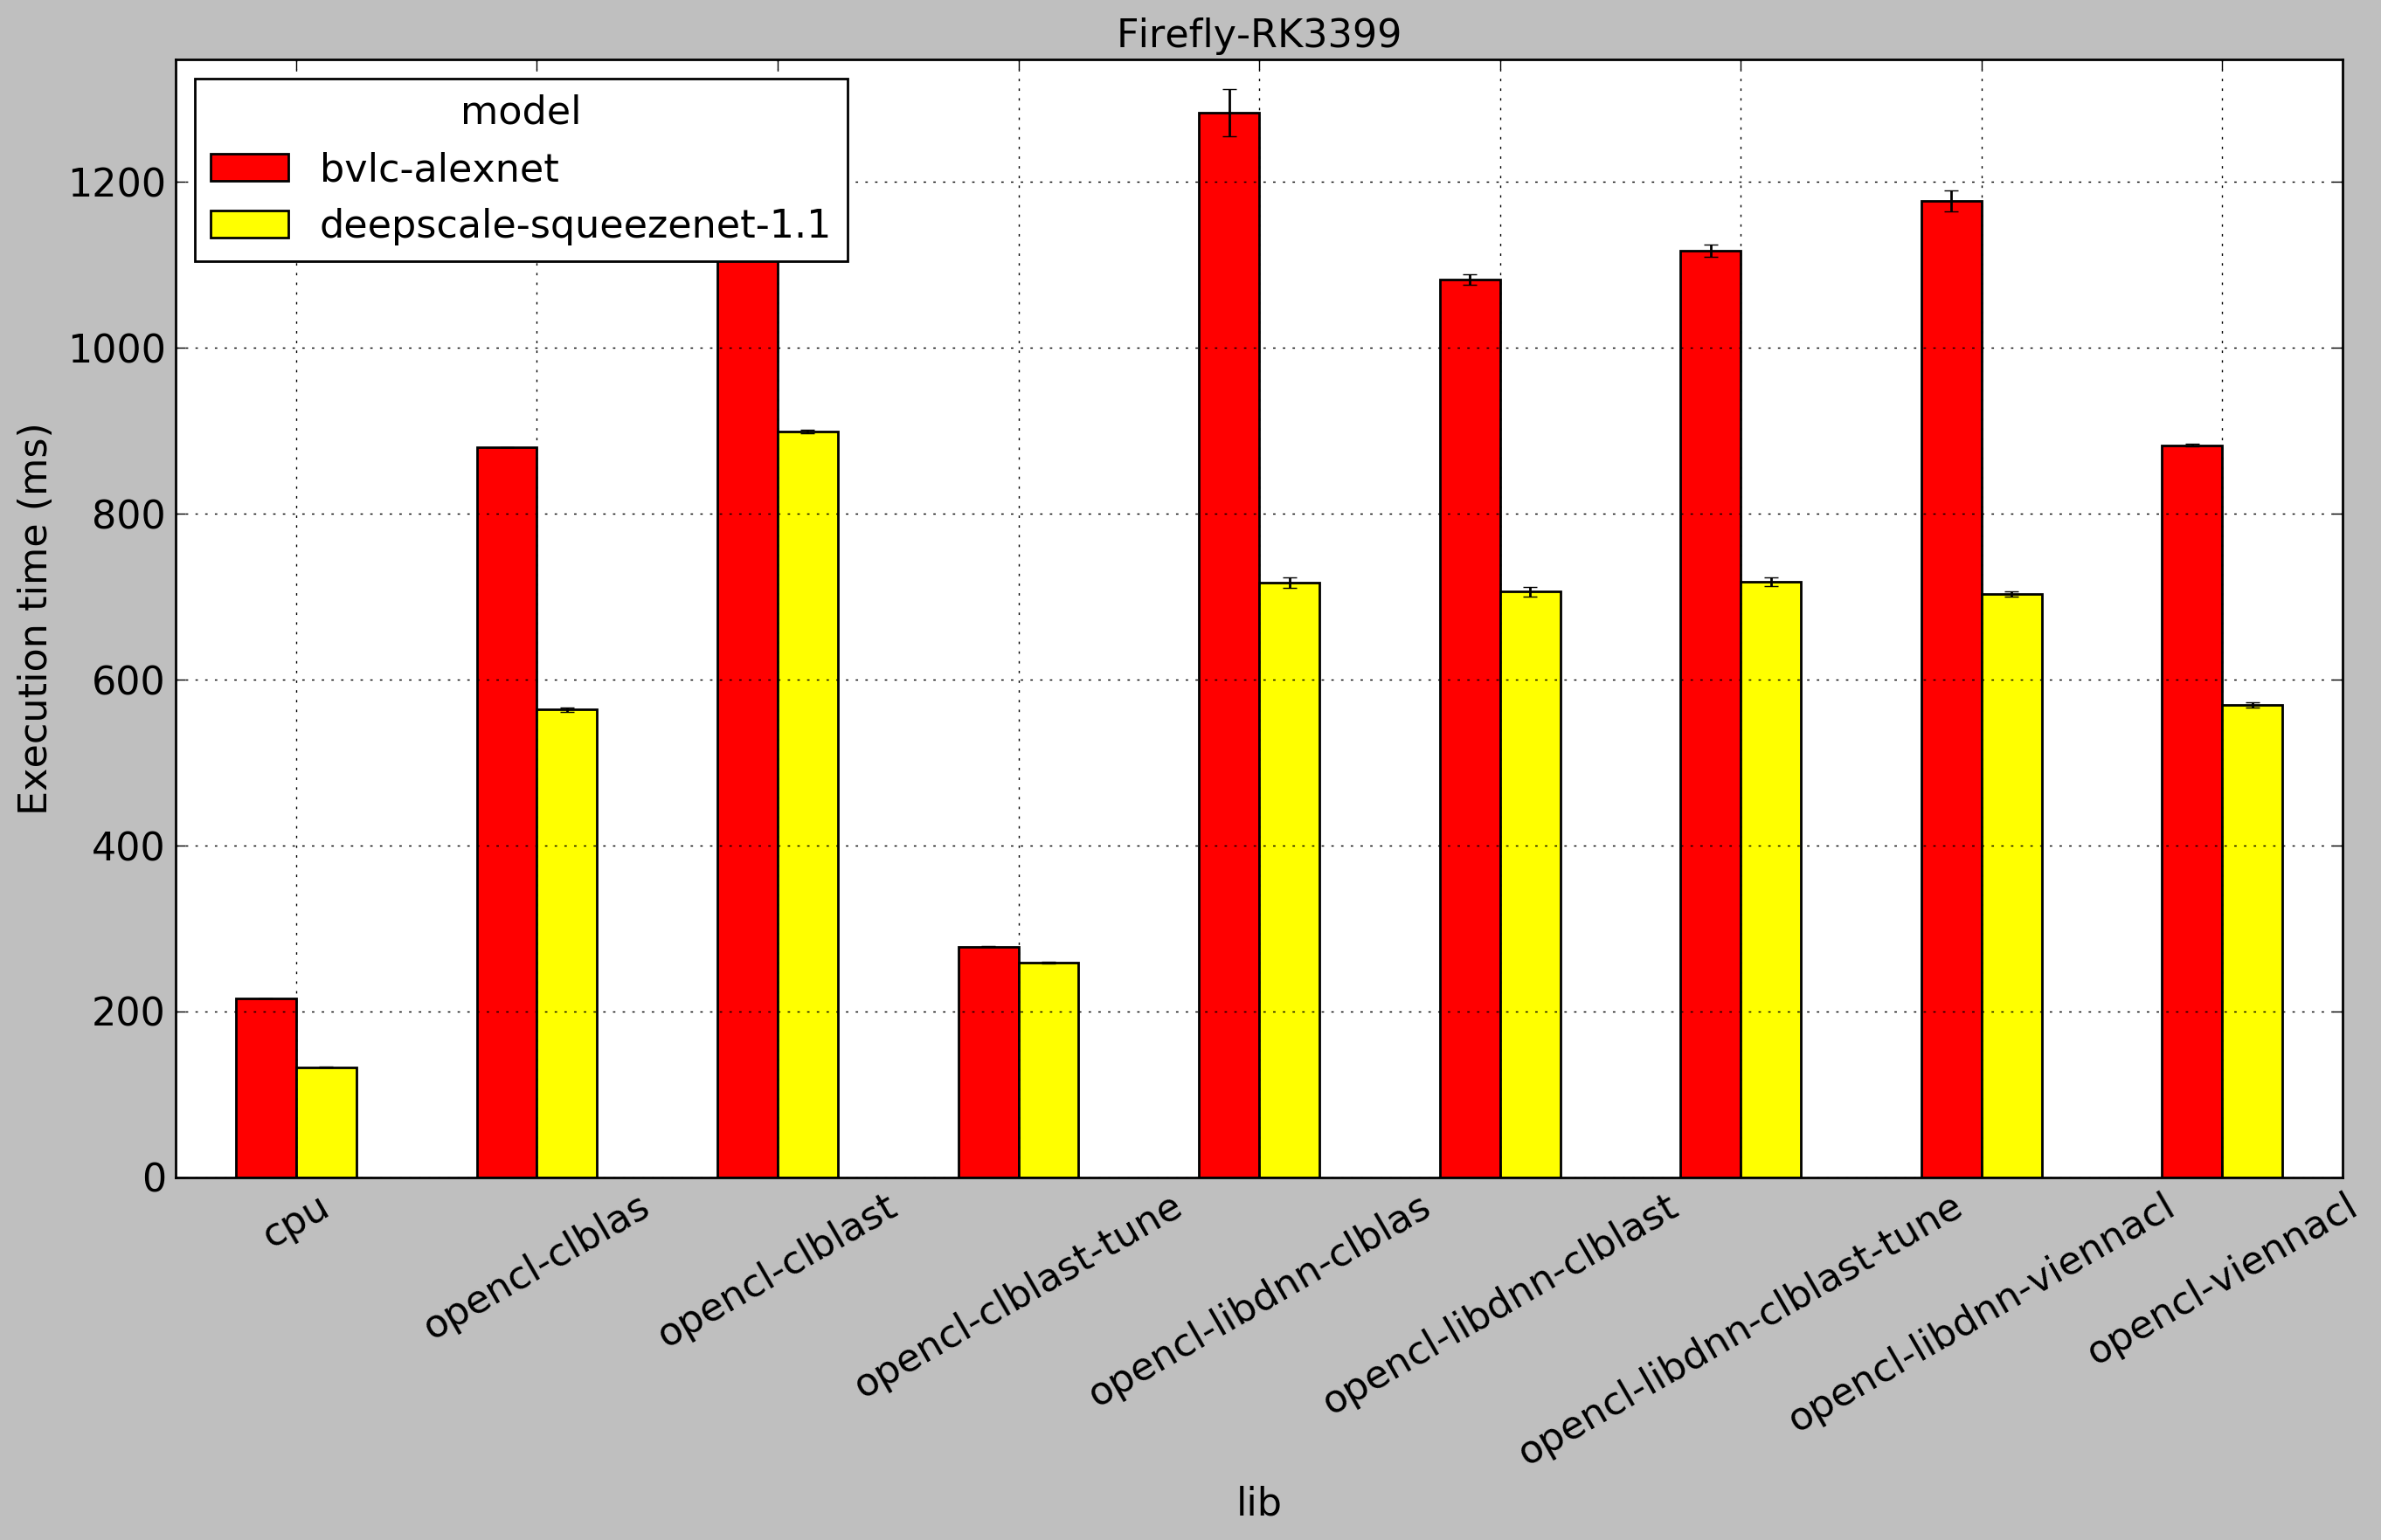

In [45]:
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model')
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model')
plot(mean, std, rot=30)

In [46]:
pd.options.display.max_rows=mean.index.size
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
cpu                           0.614685
opencl-clblas                 0.640569
opencl-clblast                0.763364
opencl-clblast-tune           0.929647
opencl-libdnn-clblas          0.558631
opencl-libdnn-clblast         0.652408
opencl-libdnn-clblast-tune    0.642682
opencl-libdnn-viennacl        0.597233
opencl-viennacl               0.645296
dtype: float64

<a id="plot_libs_alexnet_clblast"></a>
### Only models with AlexNet-level accuracy, only CLBlast-based libs

In [47]:
clblast_libs

['opencl-clblast', 'opencl-clblast-tune']

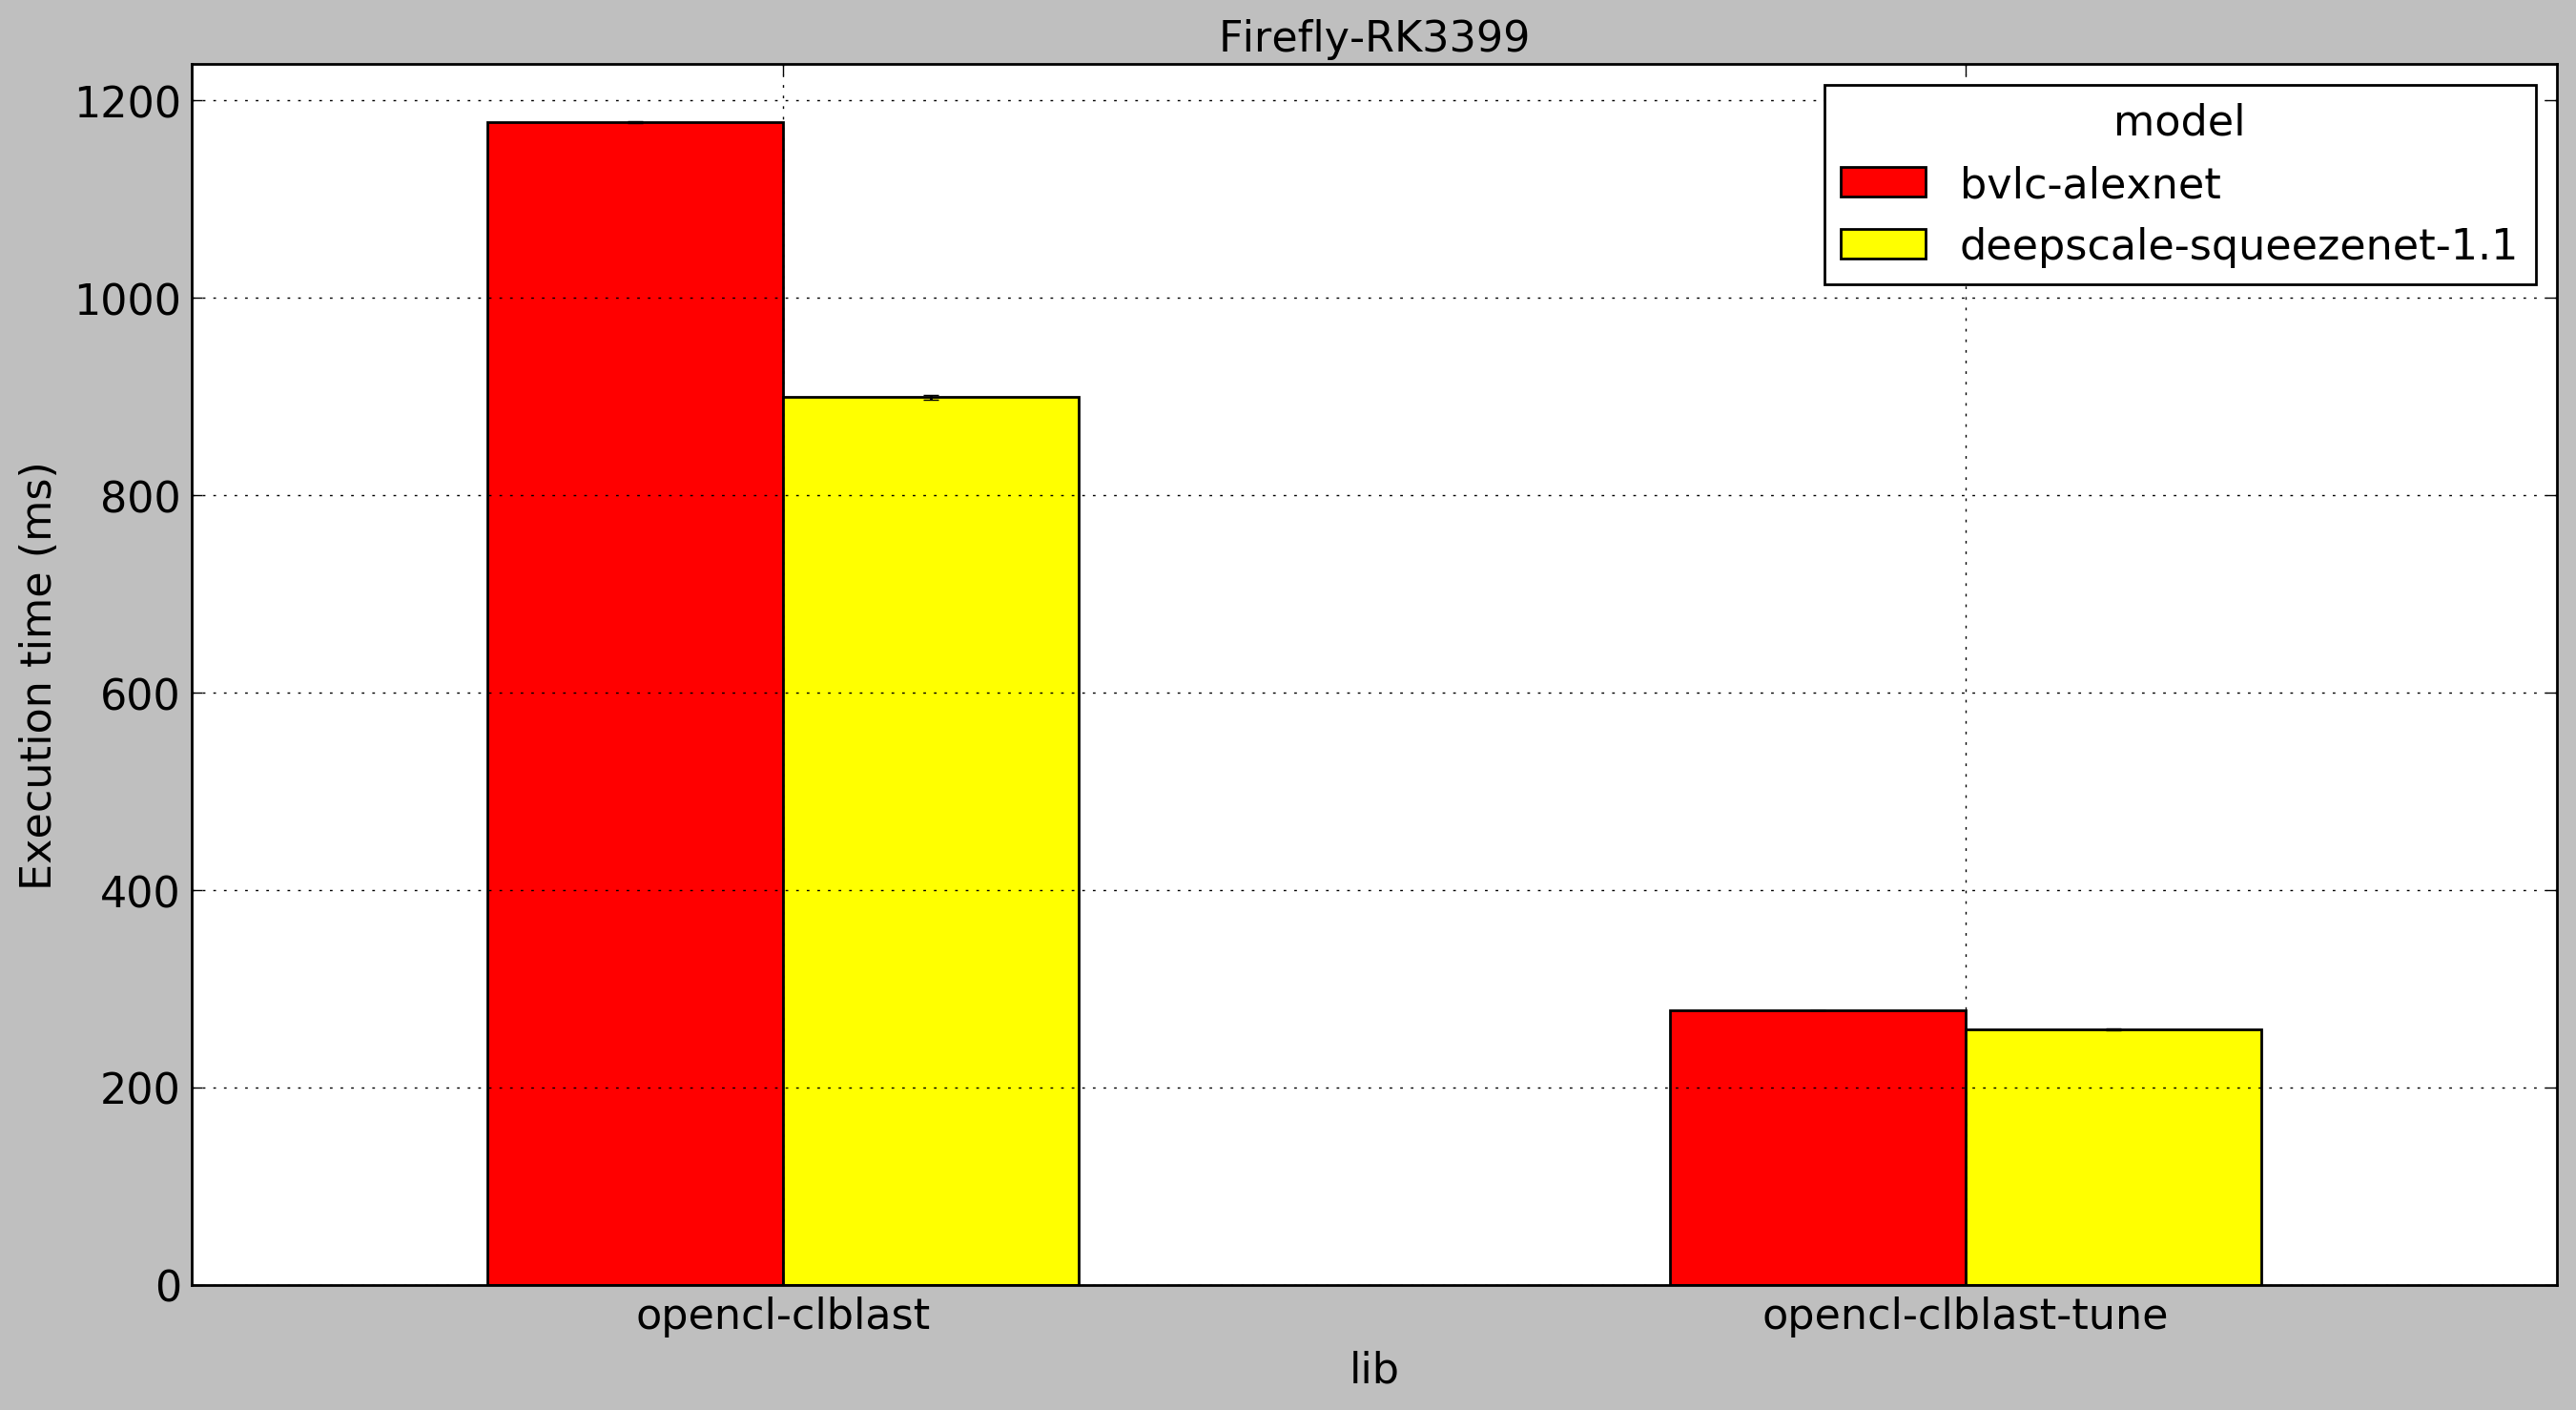

In [48]:
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').loc[clblast_libs]
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').loc[clblast_libs]
plot(mean, std)

In [49]:
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
opencl-clblast         0.763364
opencl-clblast-tune    0.929647
dtype: float64

<a id="plot_libs_alexnet_libdnn"></a>
### Only models with AlexNet-level accuracy, only libDNN libs

In [50]:
libdnn_libs

['opencl-libdnn-clblas',
 'opencl-libdnn-clblast',
 'opencl-libdnn-viennacl',
 'opencl-libdnn-clblast-tune']

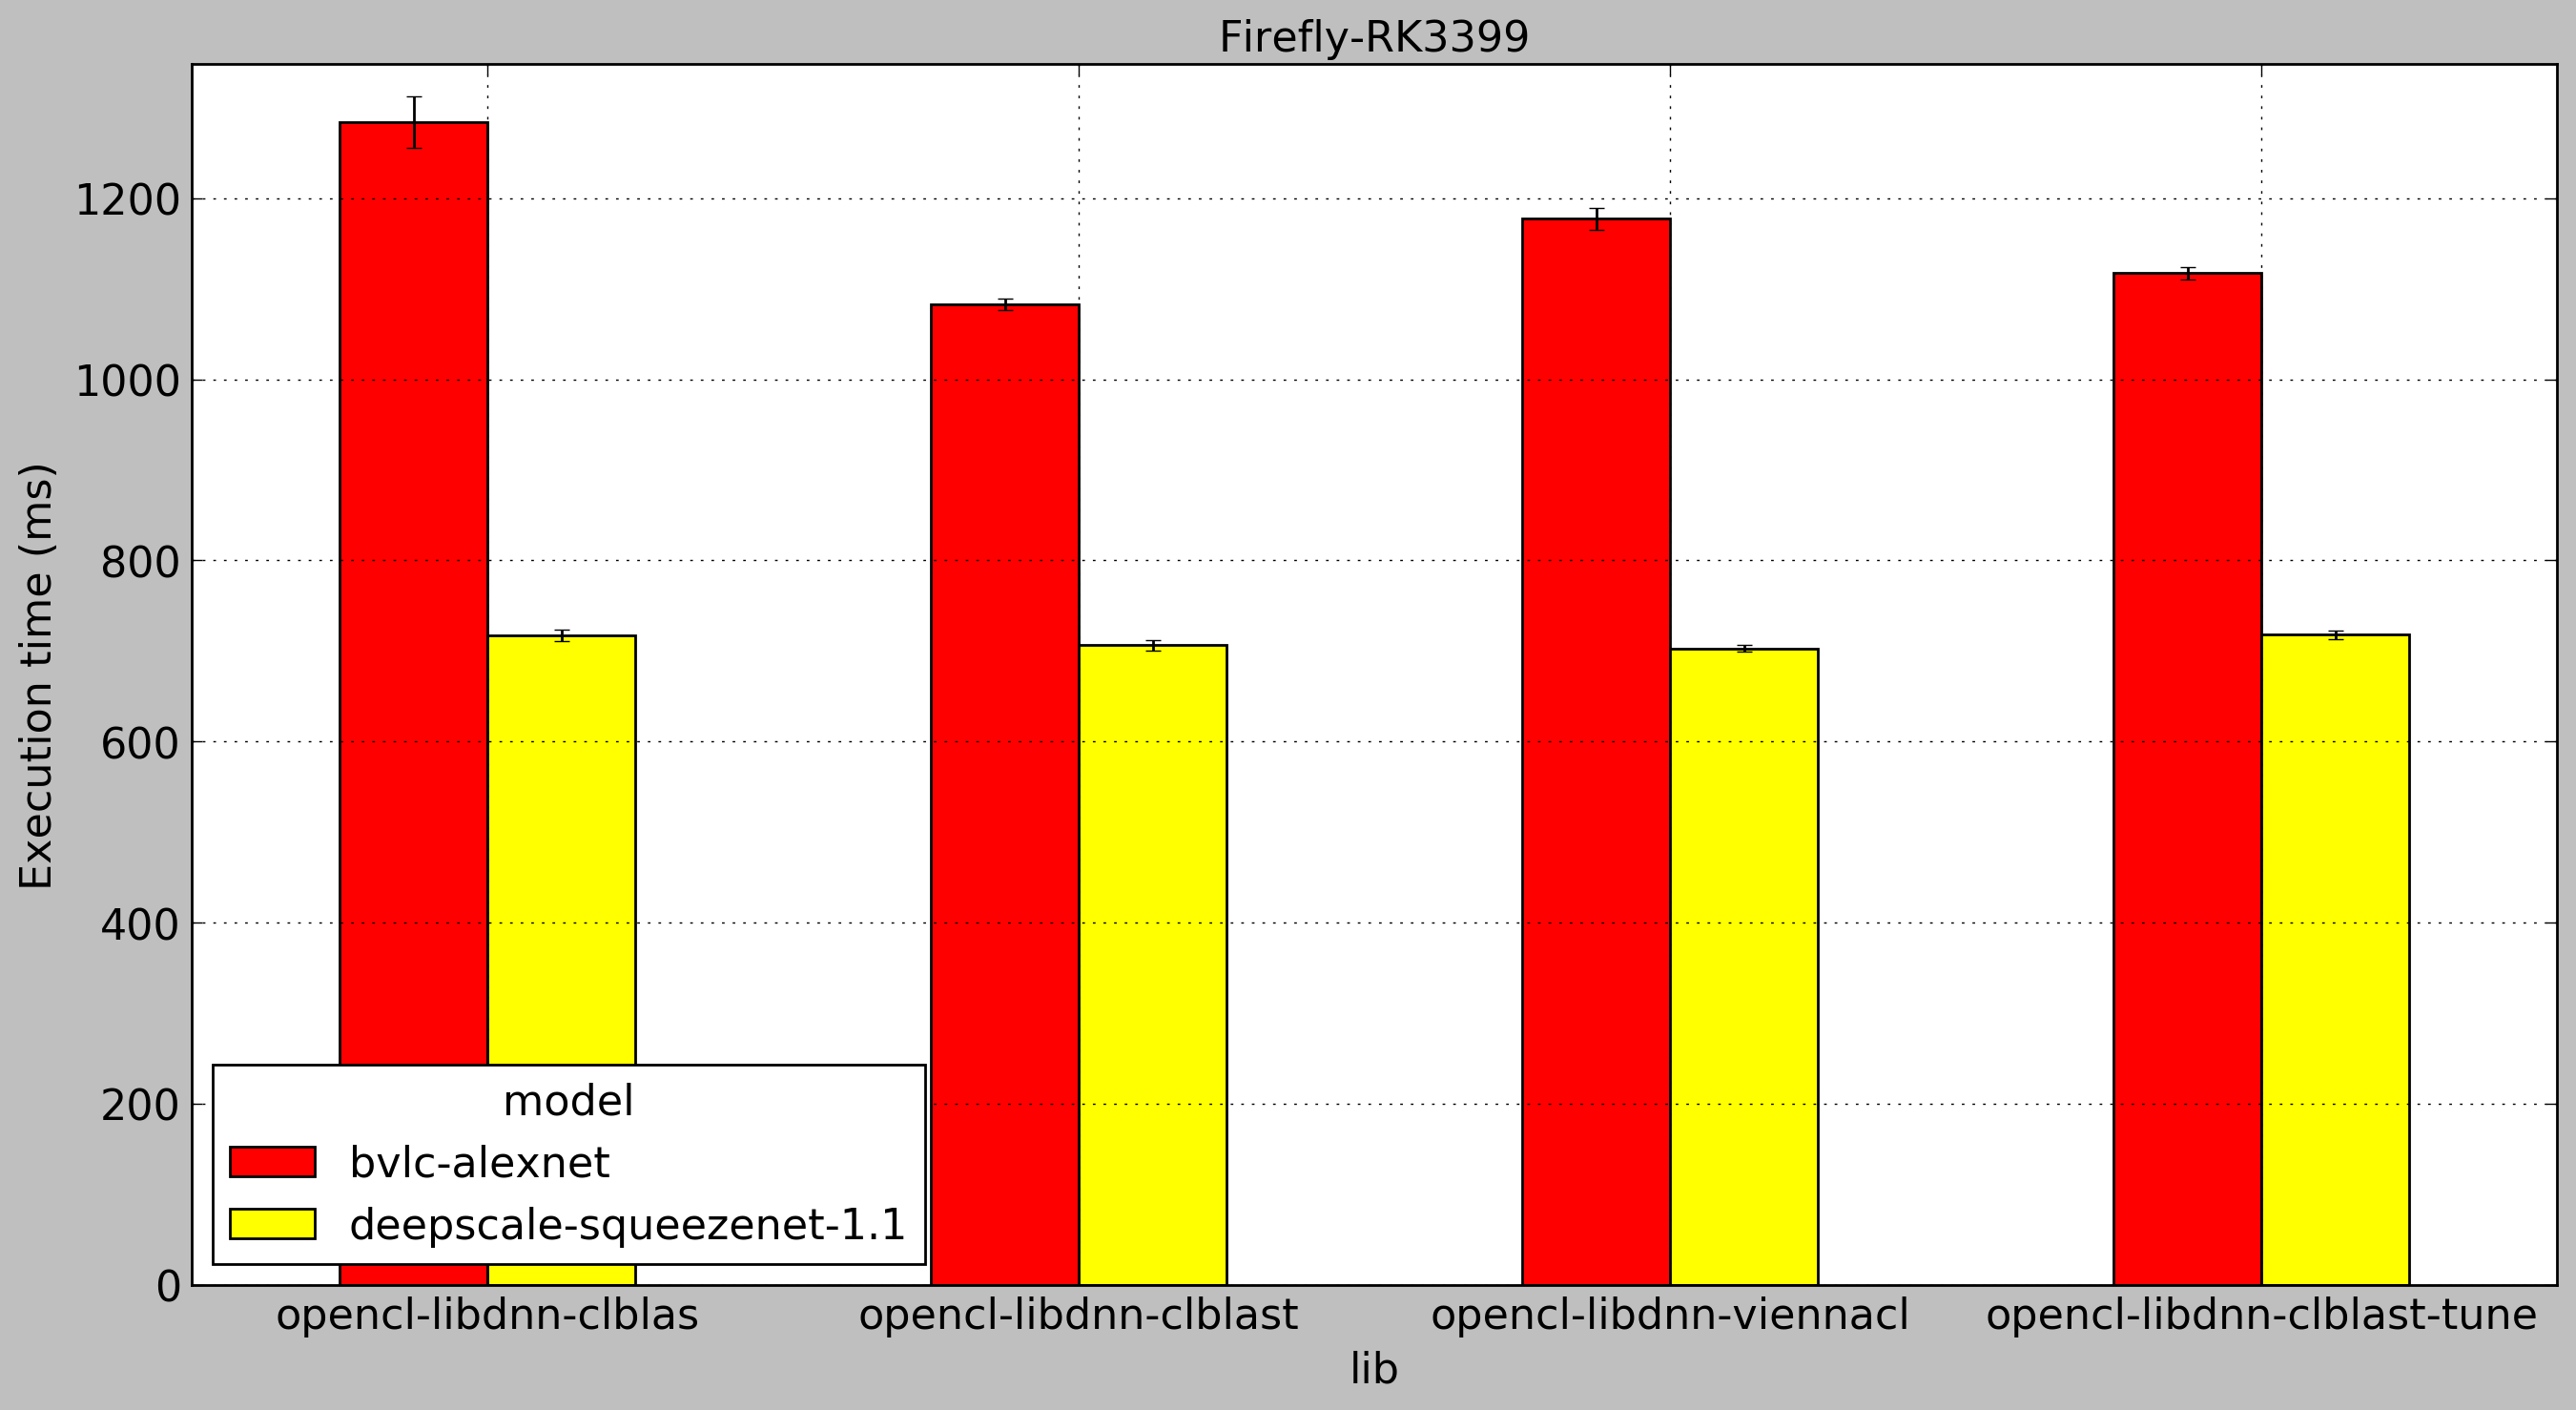

In [51]:
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').loc[libdnn_libs]
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').loc[libdnn_libs]
plot(mean, std)

In [52]:
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
opencl-libdnn-clblas          0.558631
opencl-libdnn-clblast         0.652408
opencl-libdnn-viennacl        0.597233
opencl-libdnn-clblast-tune    0.642682
dtype: float64

<a id="plot_libs_alexnet_cpu"></a>
### Only models with AlexNet-level accuracy, only CPU lib

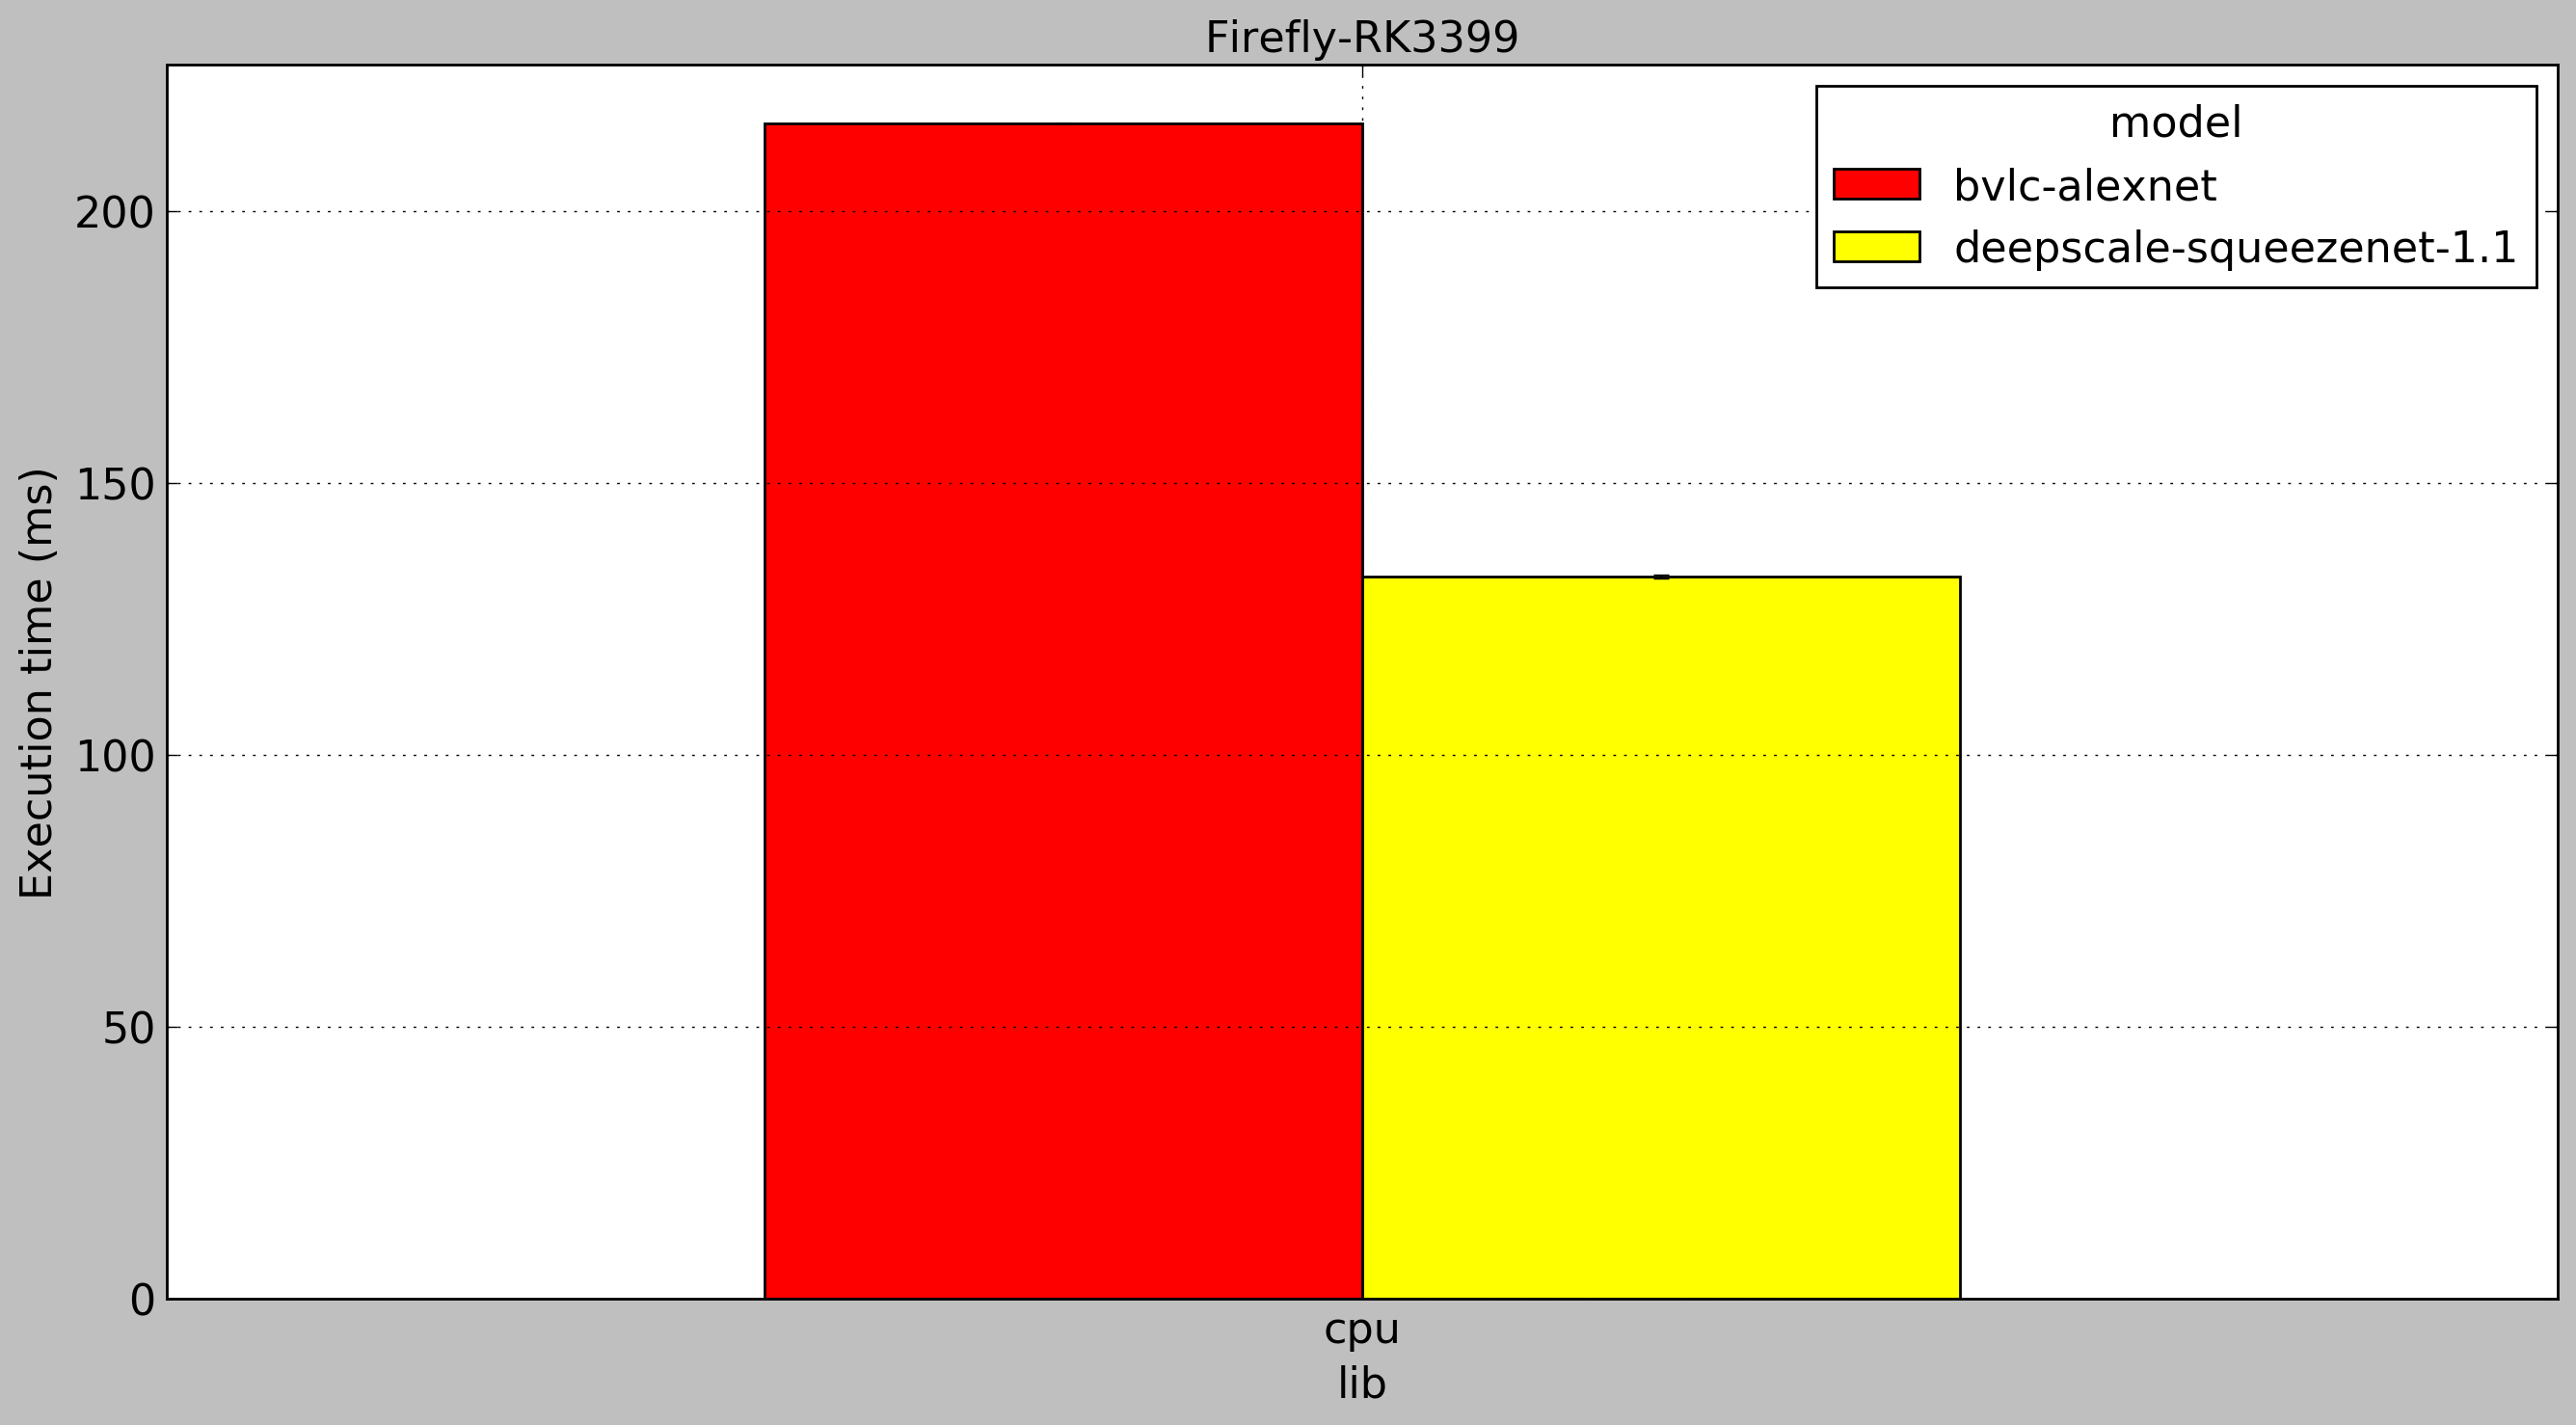

In [53]:
mean = df_model_lib_mean[alexnet_level_accuracy].unstack('model').loc[['cpu']]
std  = df_model_lib_std[alexnet_level_accuracy].unstack('model').loc[['cpu']]
plot(mean, std)

In [54]:
mean['deepscale-squeezenet-1.1'] / mean['bvlc-alexnet']

lib
cpu    0.614685
dtype: float64

<a id="plot_per_layer"></a>
## Plot execution time per image per layer

In [55]:
df_per_layer_info = get_per_layer_info(df_all)

In [56]:
# Transform to keep compatibility. Swap 'model' and 'lib'. Remove 'platform'. Sort index.
df_per_layer_info = df_per_layer_info \
    .reorder_levels(['platform', 'model', 'lib', 'batch_size', 'repetition_id']) \
    .loc[platform_id] \
    .sort_index()

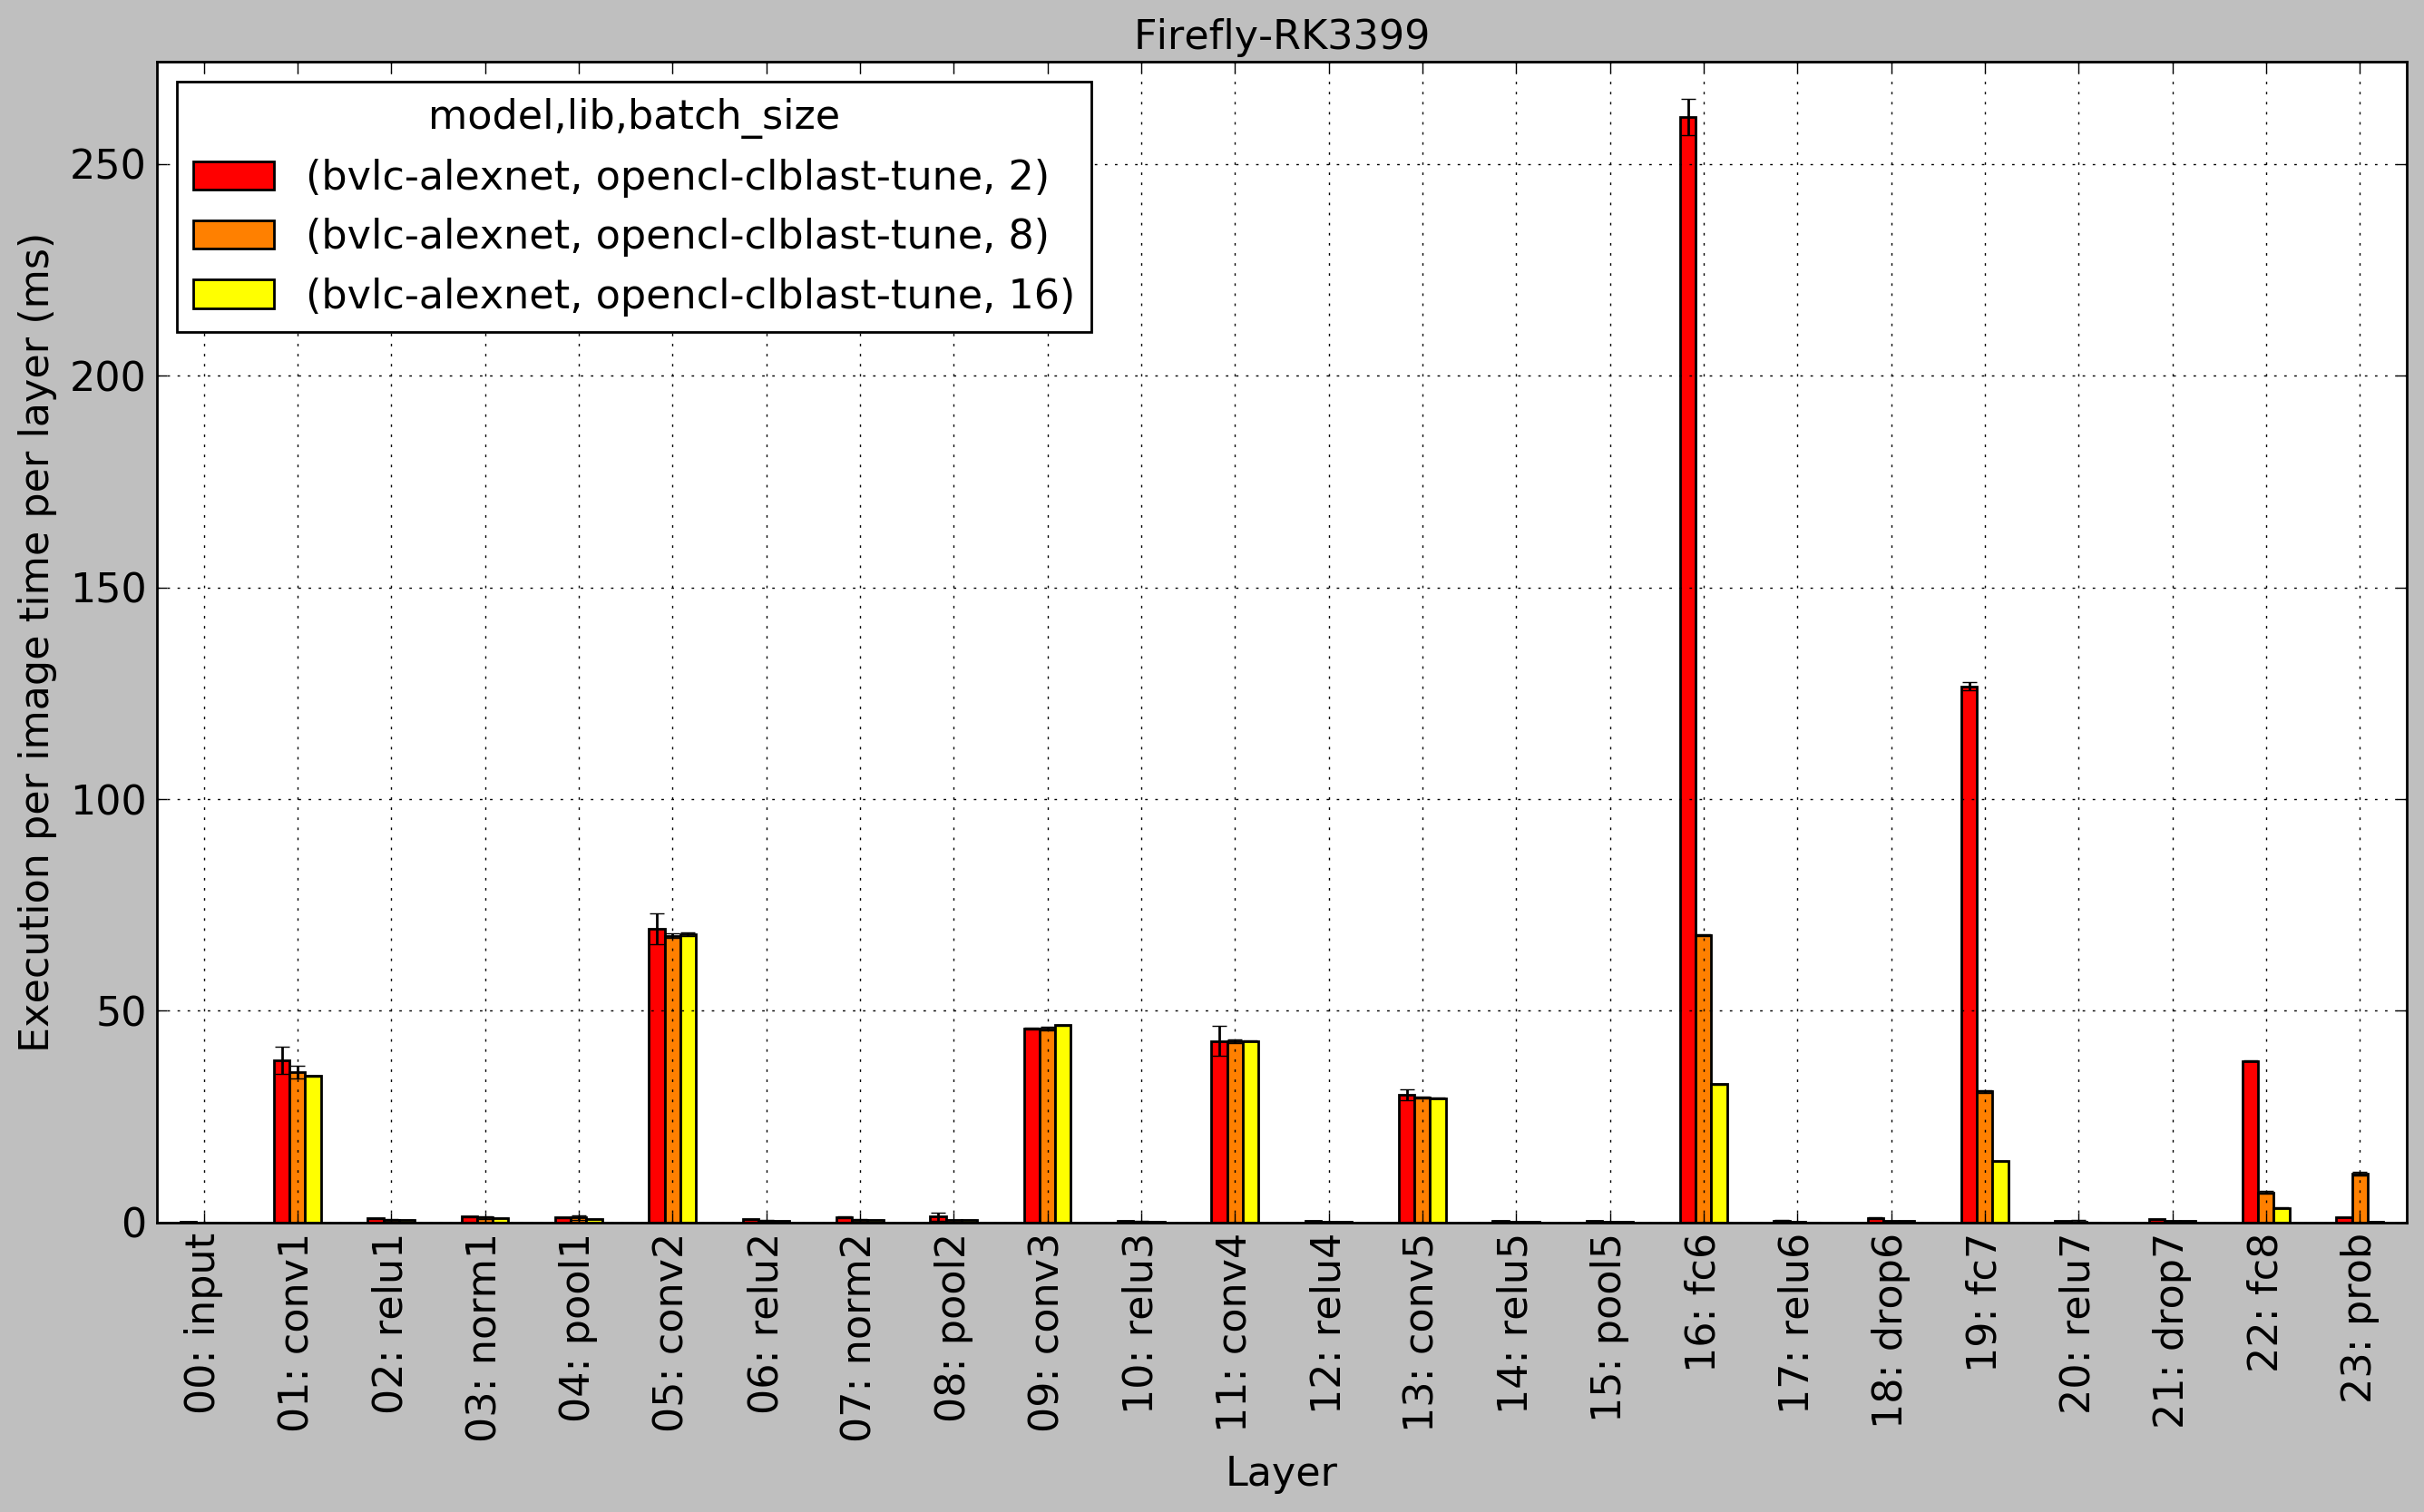

In [57]:
# Plot for a list of batch sizes.
plot_time_per_image_per_layer(
    df_per_layer_info, model='bvlc-alexnet', libs='opencl-clblast-tune', batch_sizes=[2, 8, 16]
)

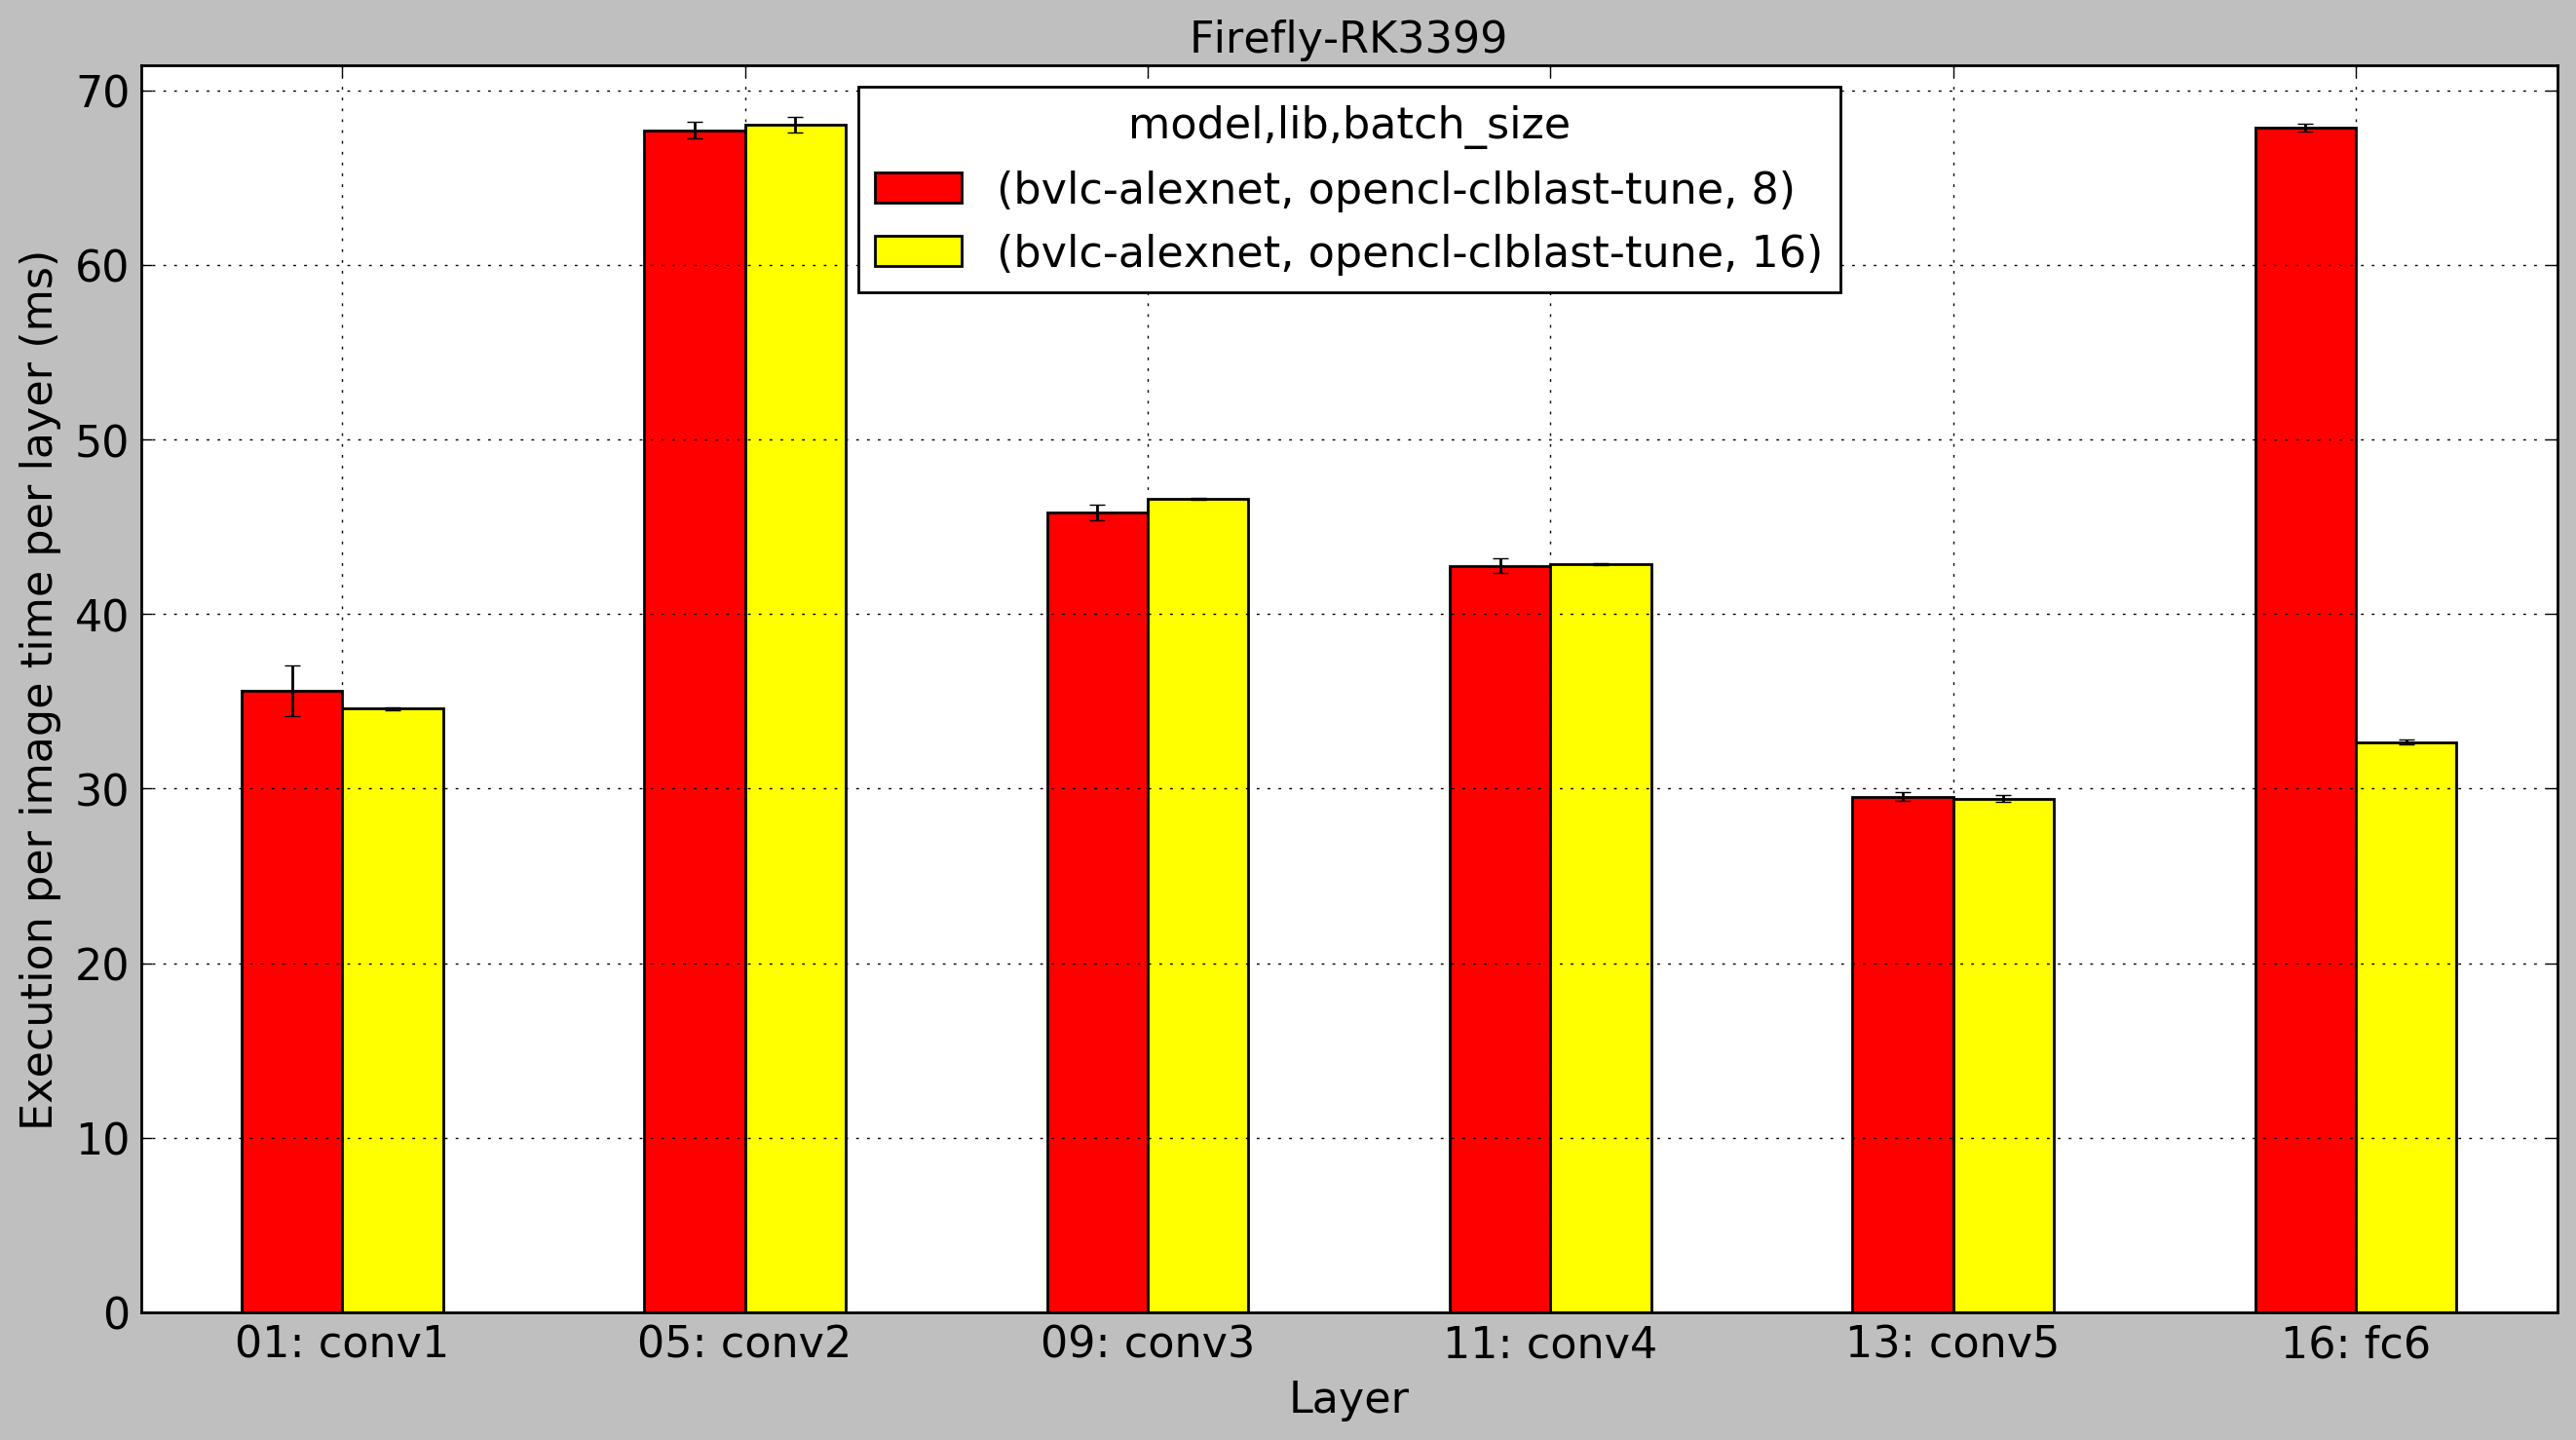

In [58]:
# Plot for a list of batch sizes. Only plot layers that consume at least 10% of the total execution time.
plot_time_per_image_per_layer(
    df_per_layer_info, model='bvlc-alexnet', libs='opencl-clblast-tune', batch_sizes=[8, 16], lower=0.10, rot=0)

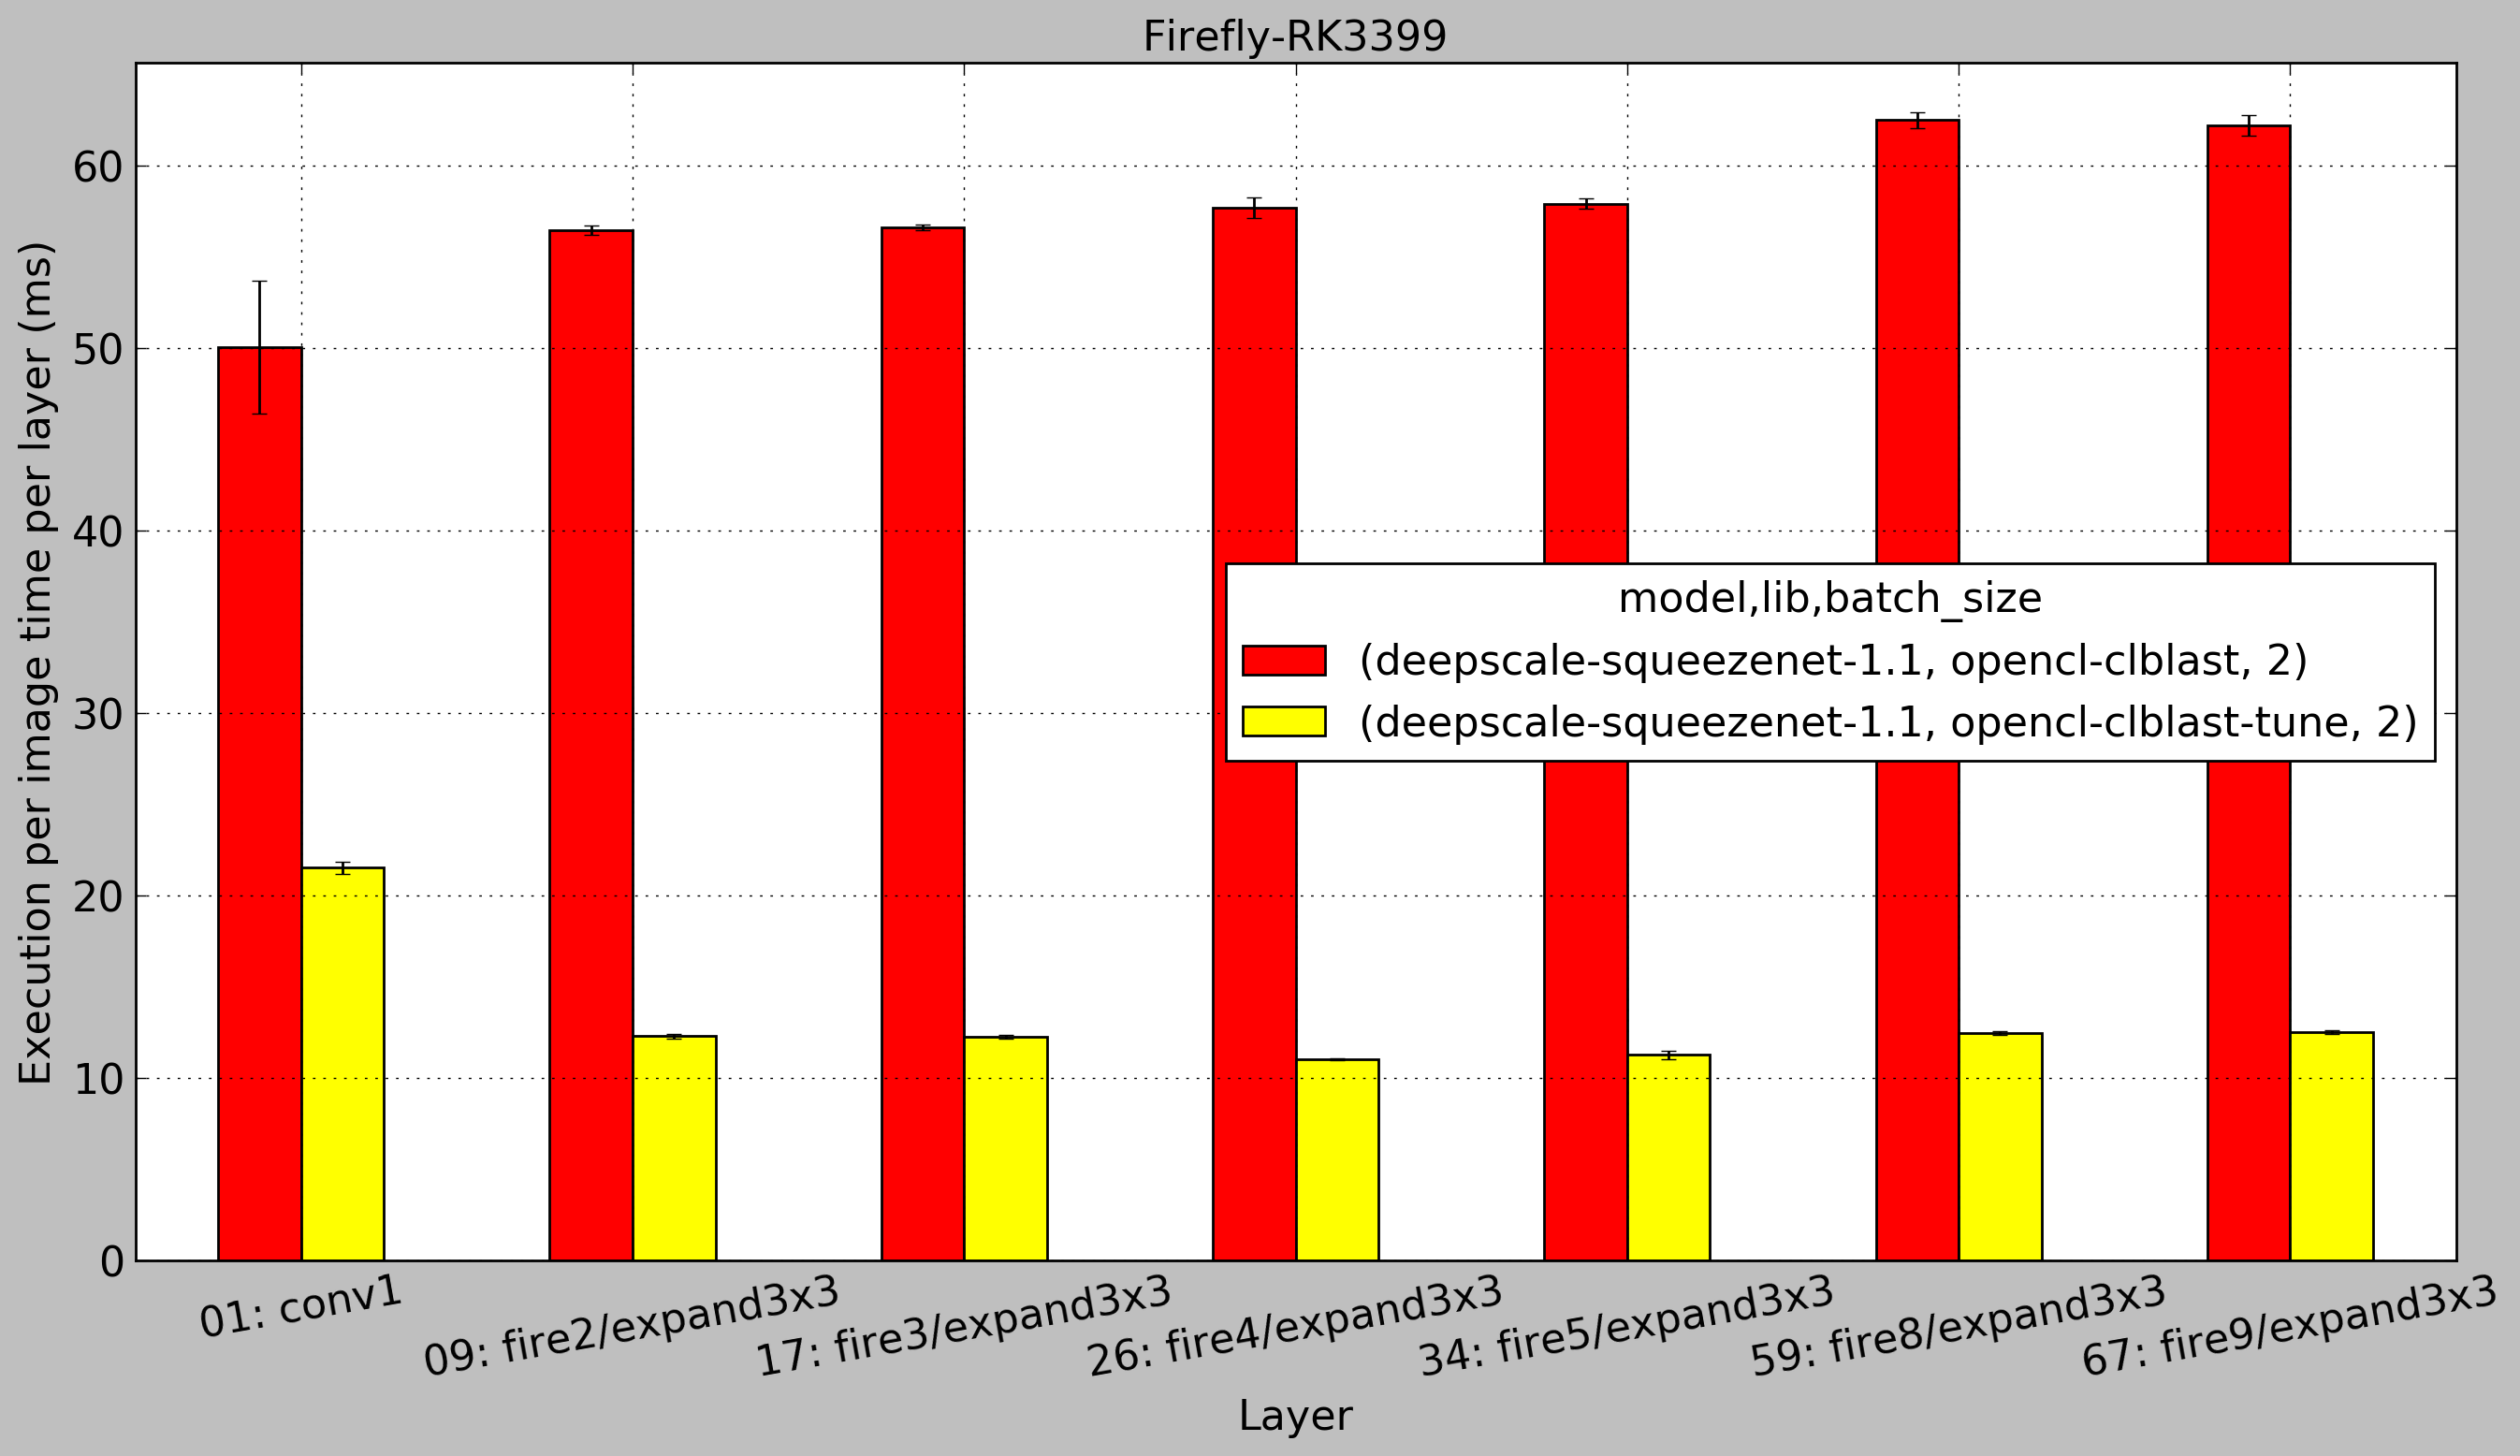

In [59]:
# Plot for a list of libs. Only plot layers that consume between 5% and 10% of the total execution time.
plot_time_per_image_per_layer(
    df_per_layer_info, model='deepscale-squeezenet-1.1',
    libs=['opencl-clblast','opencl-clblast-tune'], batch_sizes=2, lower=0.05, upper=0.10, rot=10)

<a id="plot_ideal"></a>
## Plot the ideal adaptive solution

<a id="plot_ideal_all"></a>
### Using all reasonable libs for adaptation

In [60]:
libs_for_adaptation = df_per_layer_info.index.get_level_values('lib') \
    .drop_duplicates() \
    .drop(libdnn_libs_to_drop, errors='ignore') \
    .values
libs_for_adaptation

array([u'cpu', u'opencl-clblas', u'opencl-clblast', u'opencl-clblast-tune',
       u'opencl-libdnn-clblast-tune', u'opencl-viennacl'], dtype=object)

Each row specifies an ideal adaptive solution for a model. Each column specifies the execution time (in ms per image) that the ideal adaptive solution would cumulatively spend using a particular library.

In [61]:
df_ideal_all = get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation)
display_in_full(df_ideal_all)

lib                              cpu  opencl-clblas  opencl-clblast  \
model                                                                 
deepscale-squeezenet-1.1   93.940726       0.376138        3.122149   
bvlc-alexnet              160.115089            NaN        1.992067   
bvlc-googlenet            340.283439       2.704021        2.276630   

lib                       opencl-clblast-tune  opencl-libdnn-clblast-tune  \
model                                                                       
deepscale-squeezenet-1.1             0.525758                    3.861399   
bvlc-alexnet                         0.383155                    1.490998   
bvlc-googlenet                       1.461891                   13.097949   

lib                       opencl-viennacl  
model                                      
deepscale-squeezenet-1.1         0.928074  
bvlc-alexnet                          NaN  
bvlc-googlenet                   0.829874

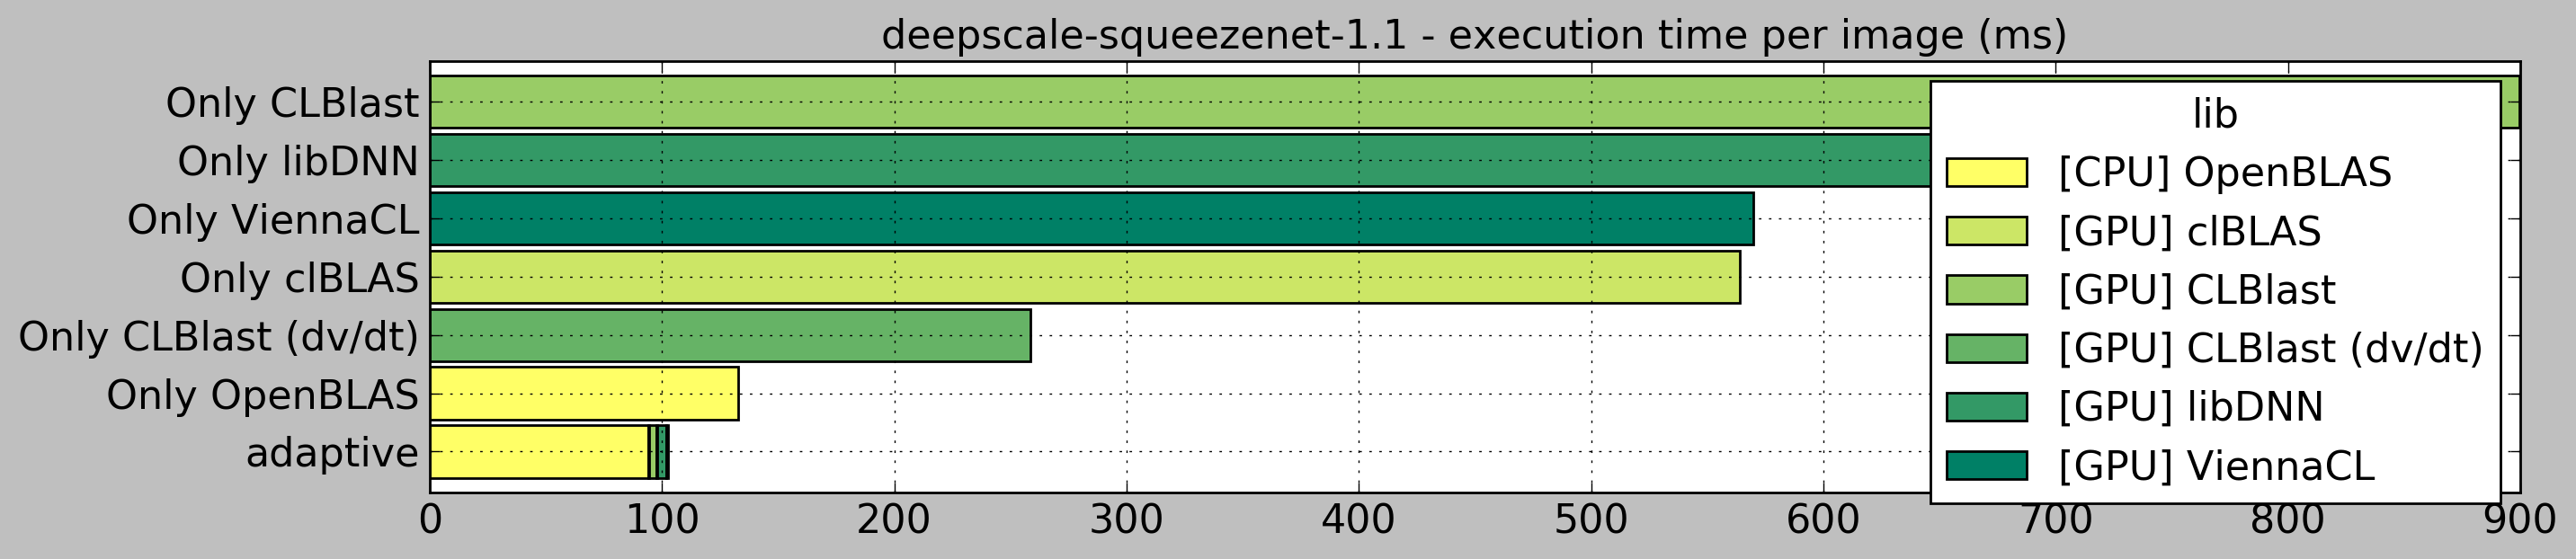

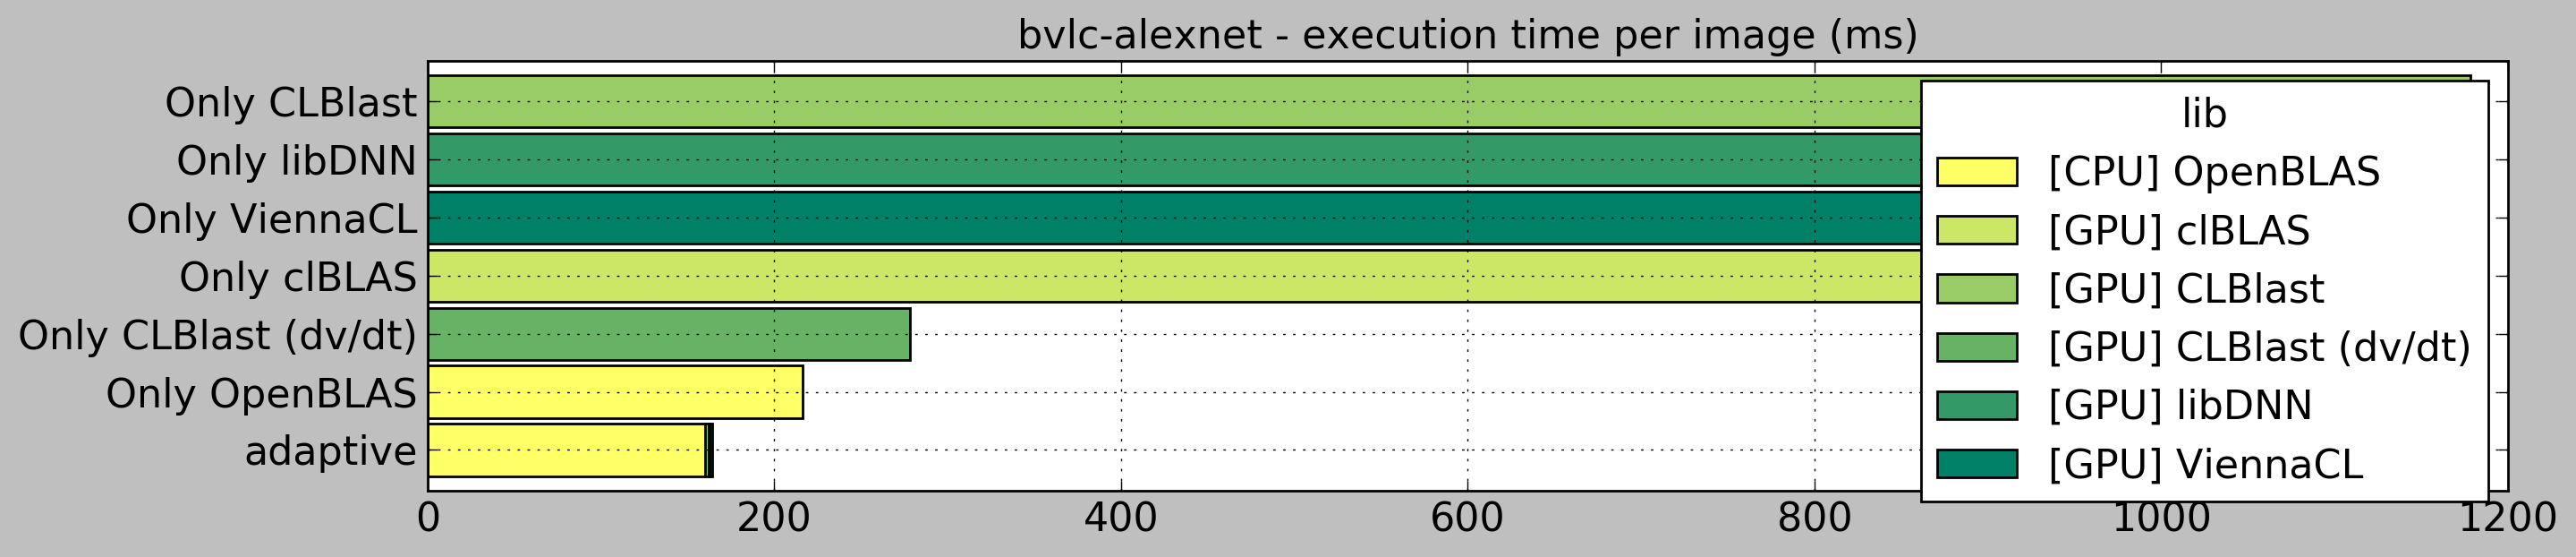

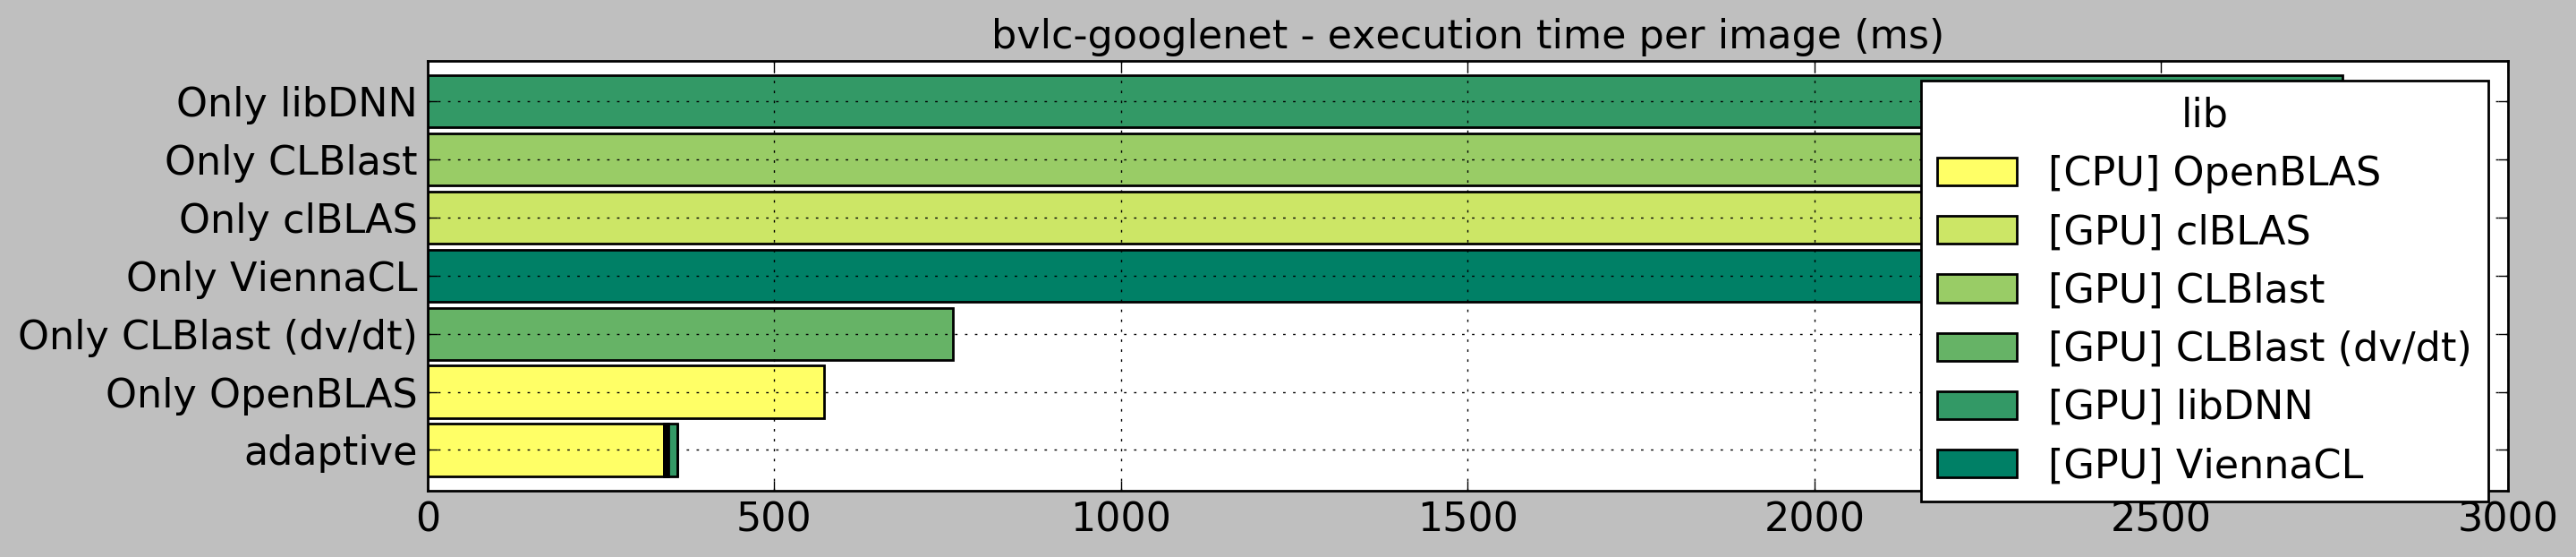

In [62]:
plot_ideal_adaptive_solution(df_ideal_all, df_model_lib_mean)

In [63]:
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model']).unstack('lib')
df_ideal_all.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.758800
bvlc-googlenet              0.630758
deepscale-squeezenet-1.1    0.773536
dtype: float64

<a id="plot_ideal_cpu_libdnn"></a>
### Using OpenBLAS and libDNN for adaptation

In [64]:
libs_for_adaptation = ['cpu', 'opencl-libdnn-clblast-tune']
df_ideal_cpu_libdnn = get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation)
display_in_full(df_ideal_cpu_libdnn)

lib                              cpu  opencl-libdnn-clblast-tune
model                                                           
deepscale-squeezenet-1.1   94.114626                    9.033633
bvlc-alexnet              160.115089                    3.968121
bvlc-googlenet            340.545372                   20.347888

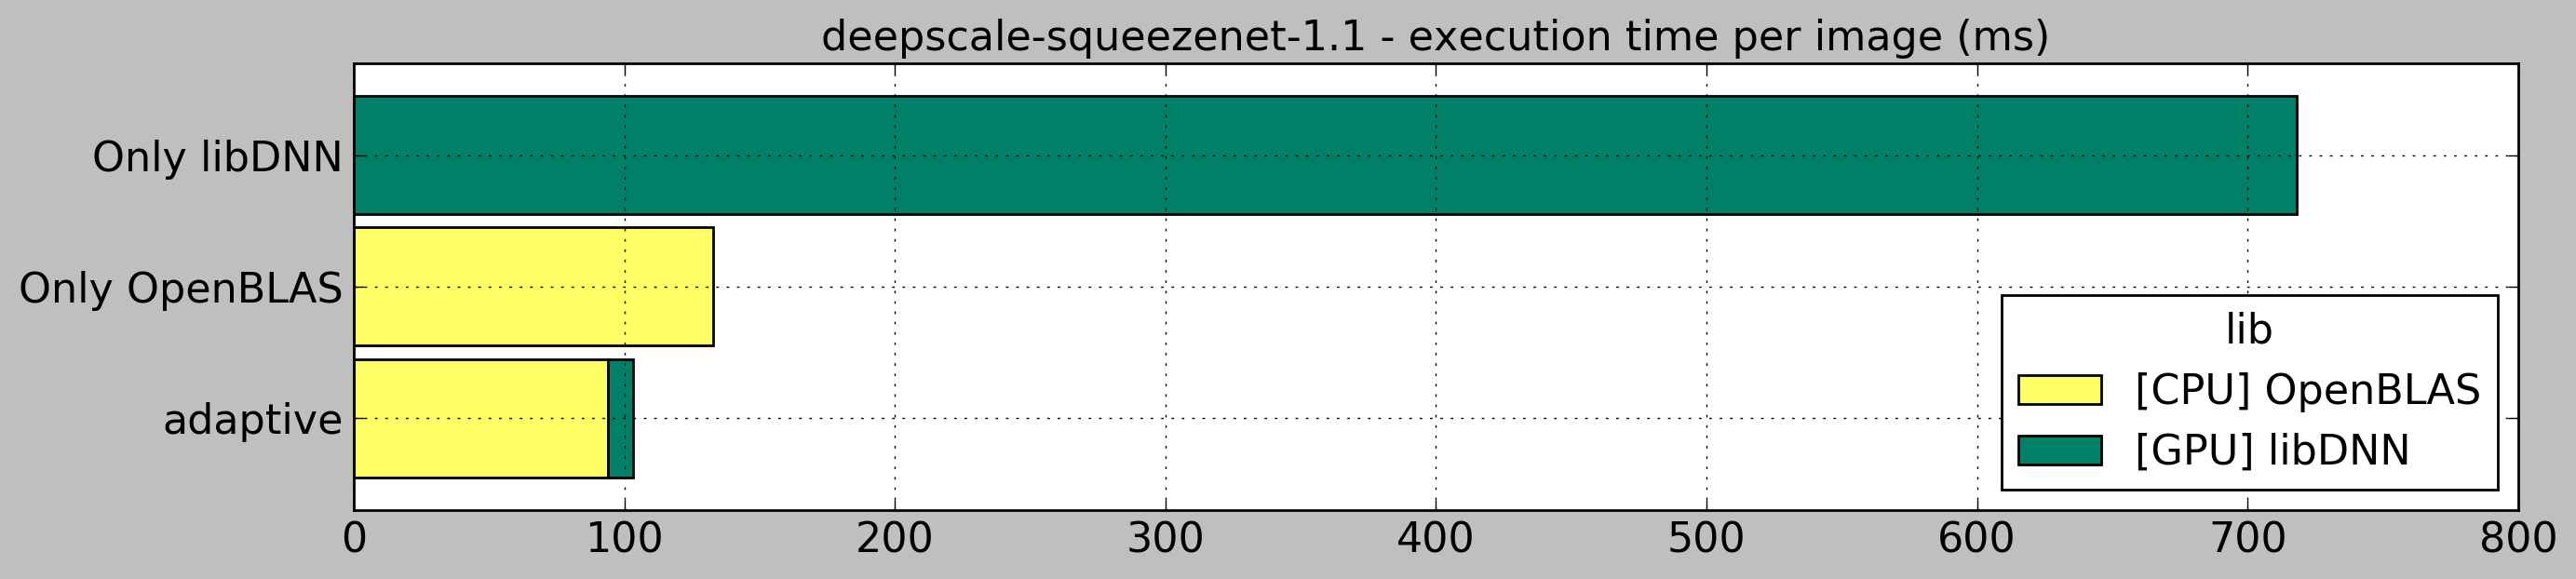

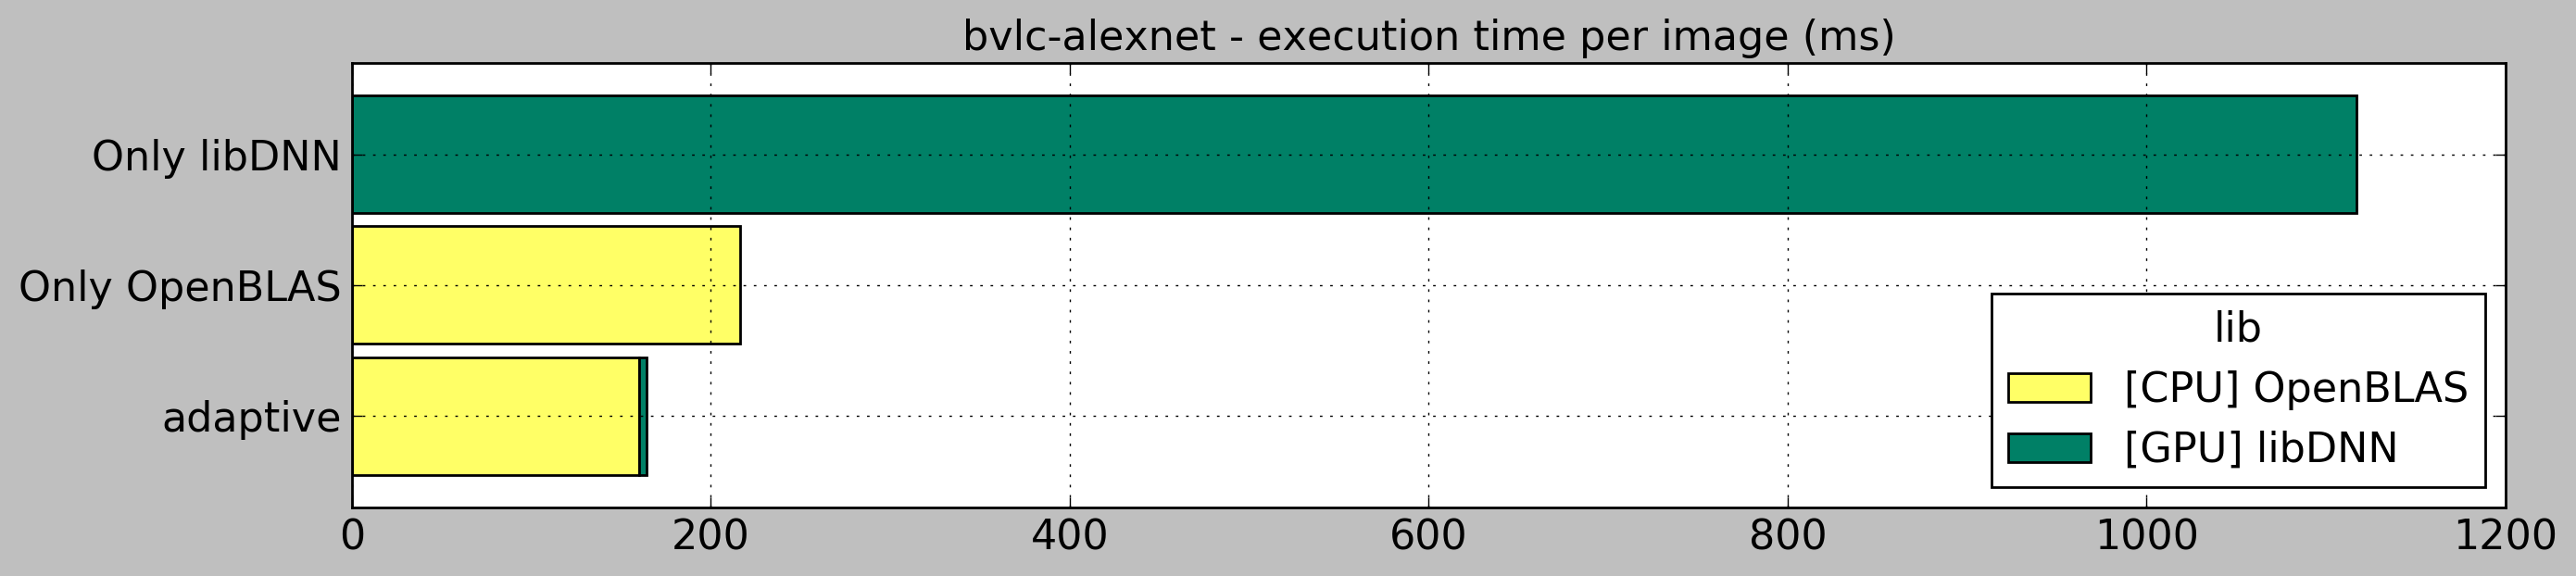

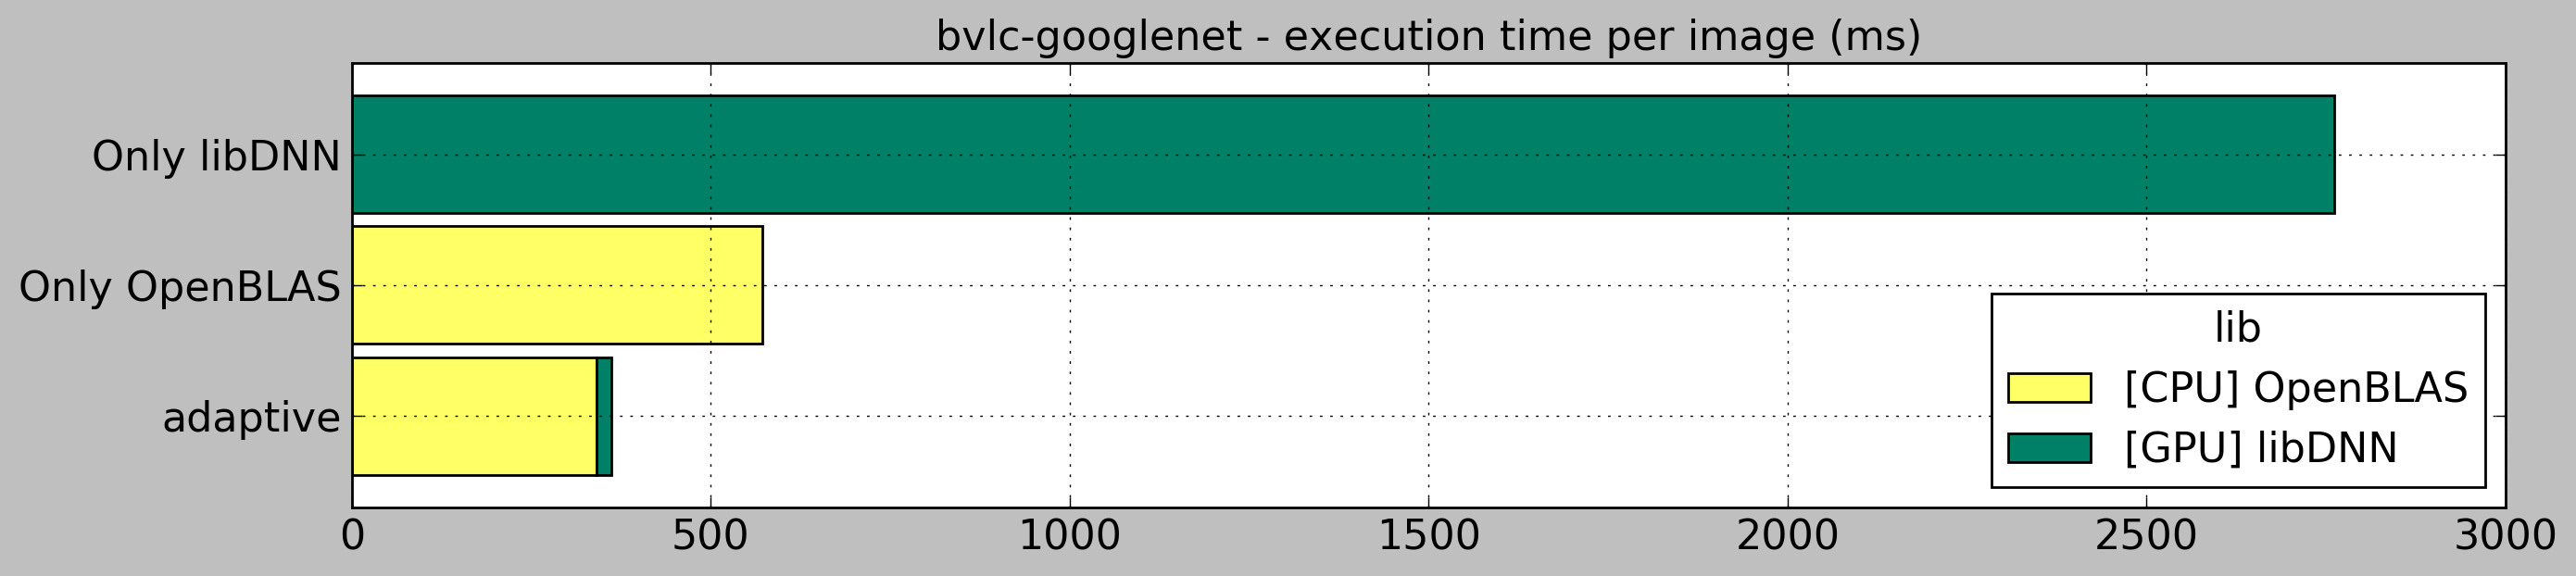

In [65]:
plot_ideal_adaptive_solution(df_ideal_cpu_libdnn, df_model_lib_mean)

In [66]:
# By how much is the execution time reduced compared to the best non-adaptive solution?
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model']).sort_index()[libs_for_adaptation].unstack('lib')
df_ideal_cpu_libdnn.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.759272
bvlc-googlenet              0.631177
deepscale-squeezenet-1.1    0.776502
dtype: float64

In [67]:
# By how much is the execution time increased compared to the best adaptive solution?
df_ideal_cpu_libdnn.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.003835
bvlc-alexnet                1.000621
bvlc-googlenet              1.000664
dtype: float64

<a id="plot_ideal_cpu_clblast"></a>
### Using OpenBLAS and CLBlast for adaptation

In [68]:
libs_for_adaptation = ['cpu', 'opencl-clblast-tune']
df_ideal_cpu_clblast = get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation)
display_in_full(df_ideal_cpu_clblast)

lib                              cpu  opencl-clblast-tune
model                                                    
deepscale-squeezenet-1.1   93.940726            11.079719
bvlc-alexnet              160.115089             4.573013
bvlc-googlenet            340.632272            25.176269

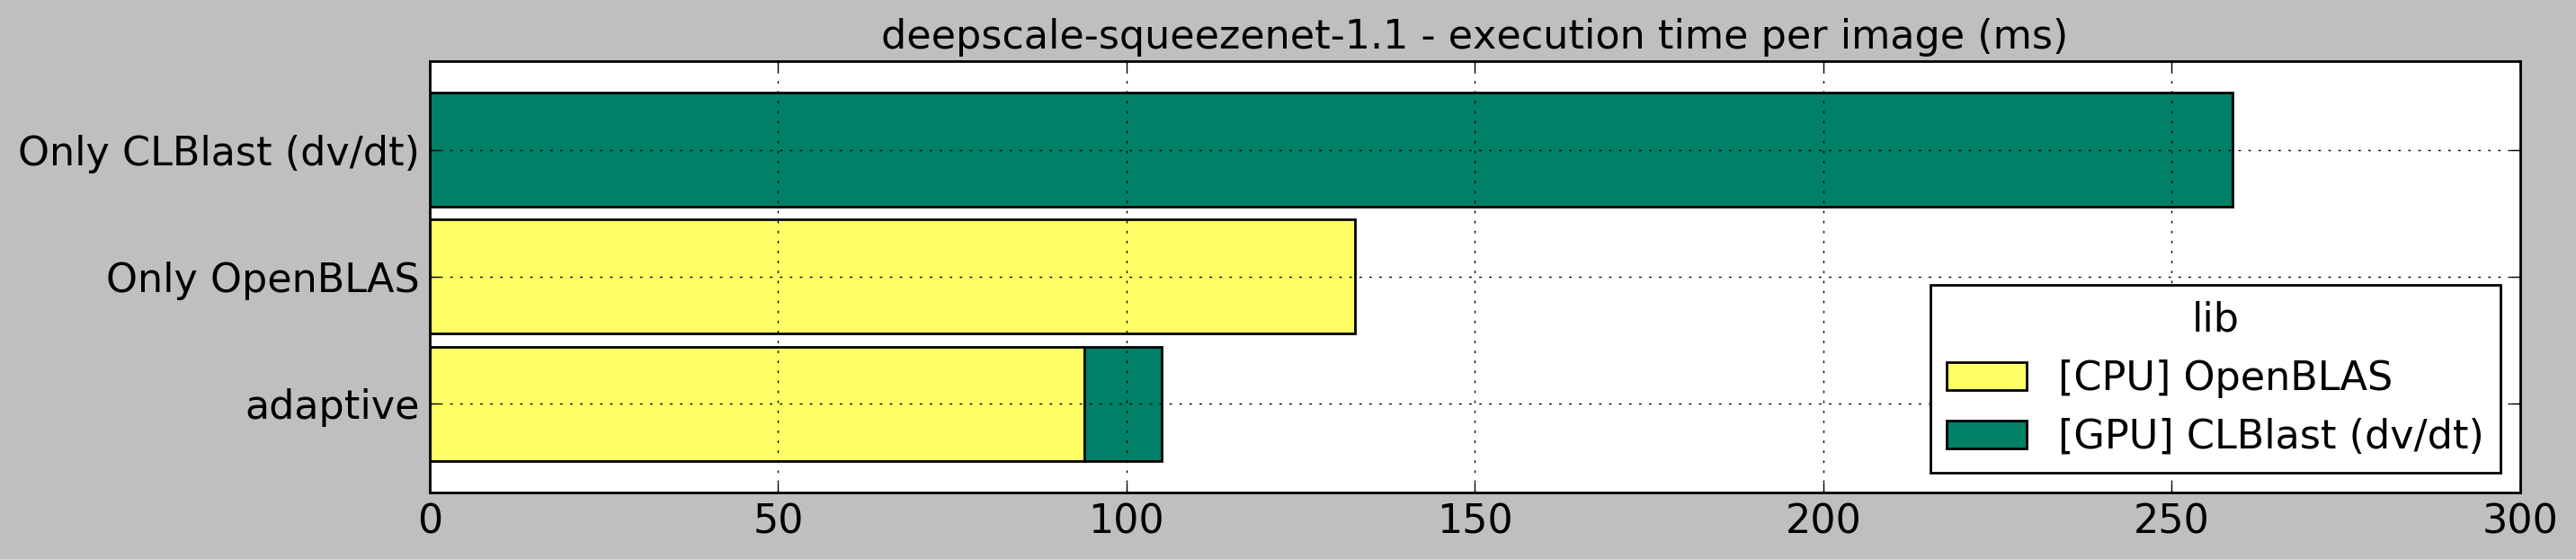

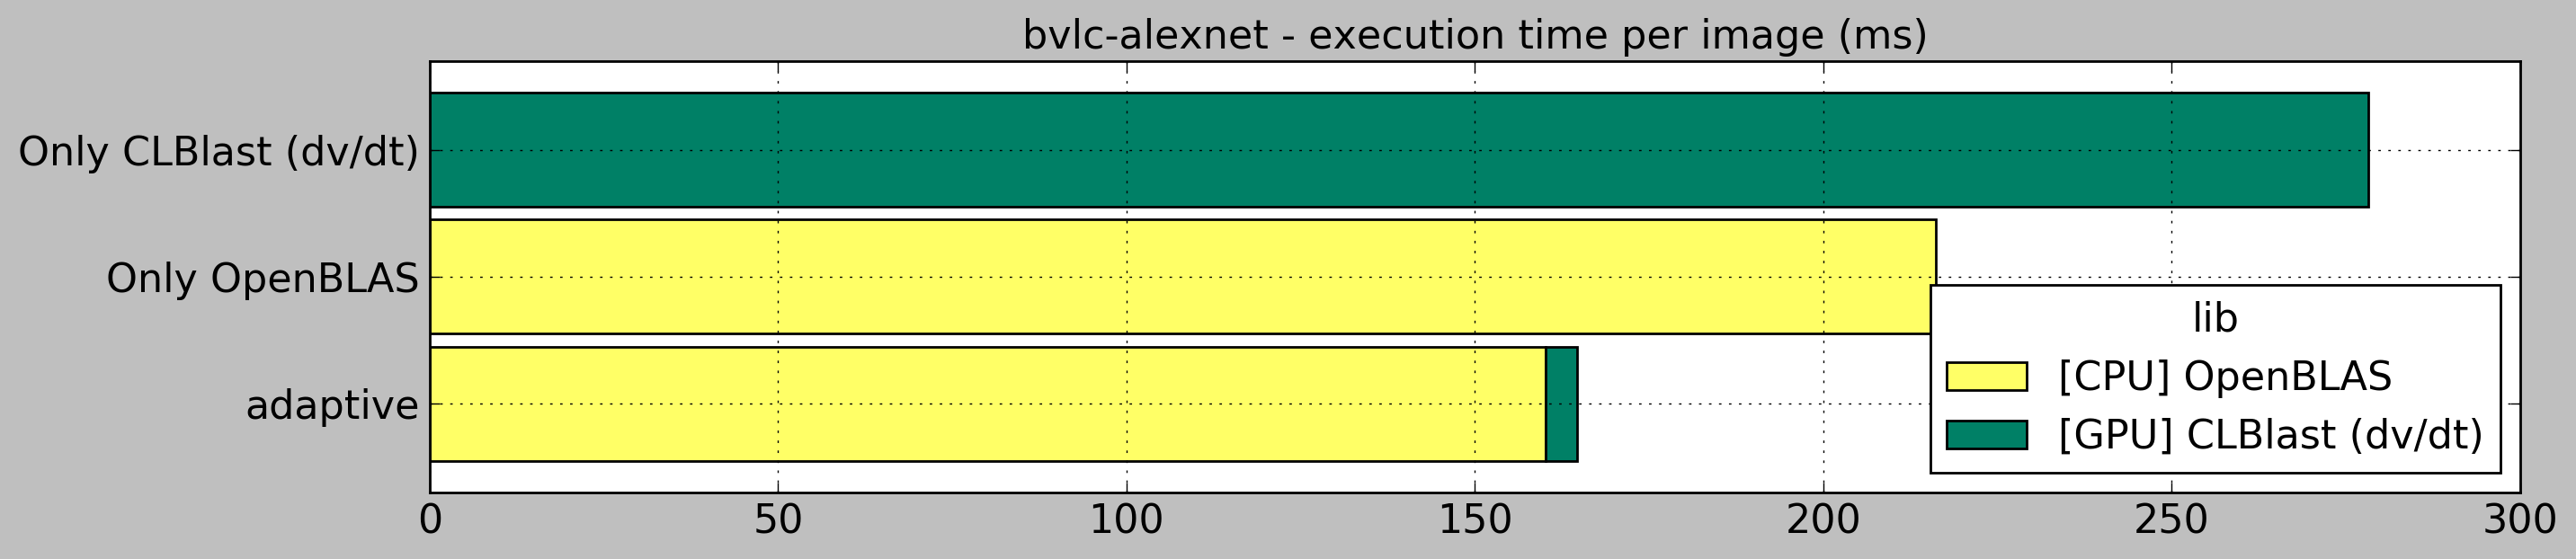

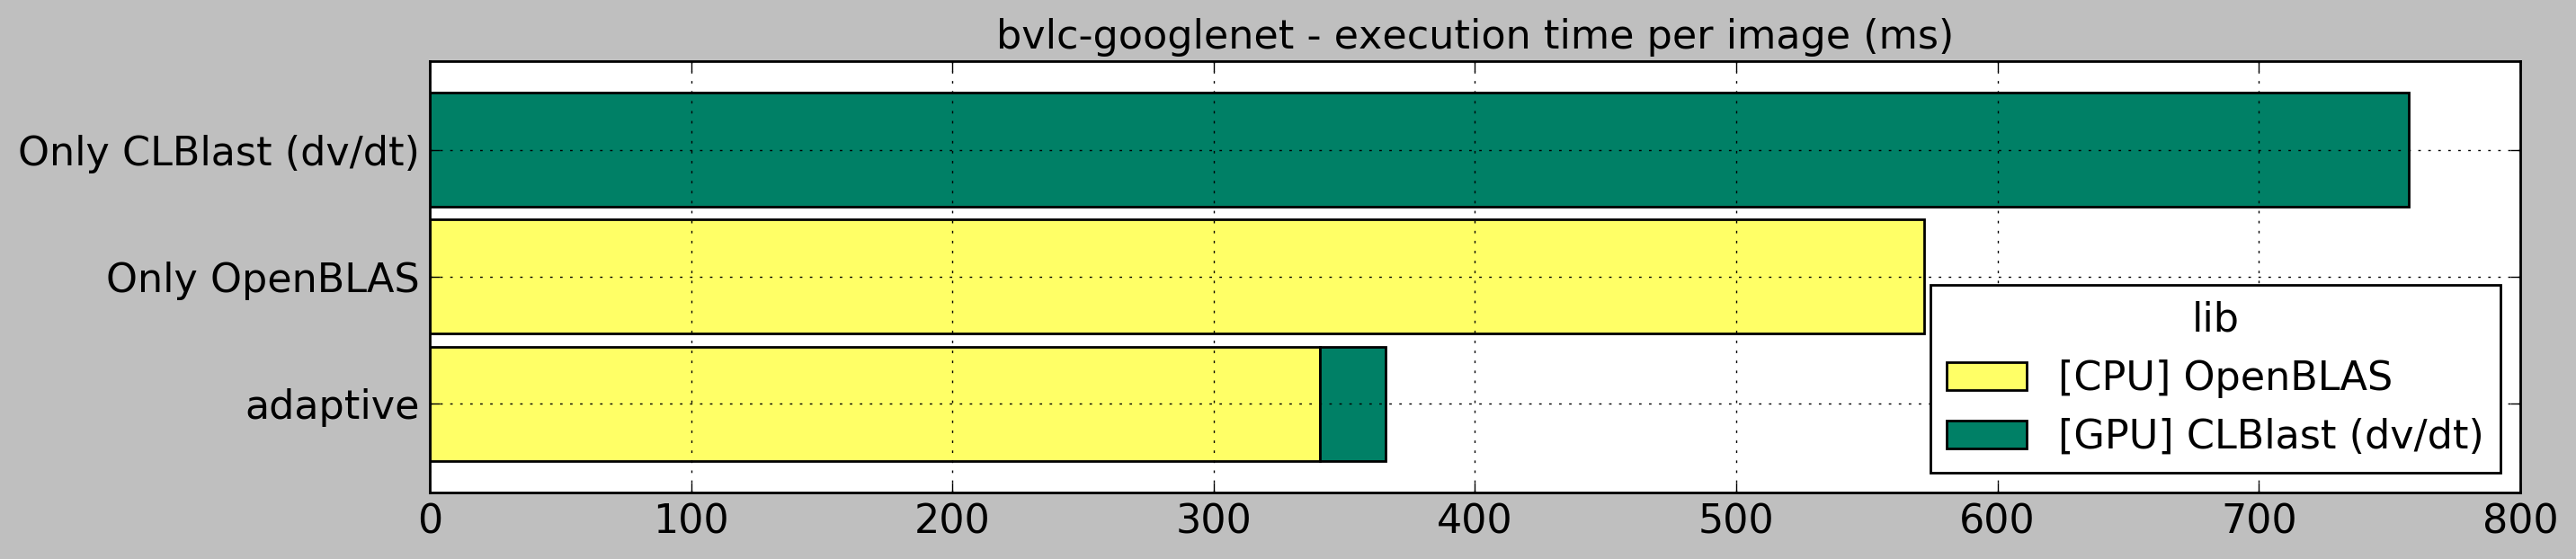

In [69]:
plot_ideal_adaptive_solution(df_ideal_cpu_clblast, df_model_lib_mean)

In [70]:
# By how much is the execution time reduced compared to the best non-adaptive solution?
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model']).sort_index()[libs_for_adaptation].unstack('lib')
df_ideal_cpu_clblast.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.762071
bvlc-googlenet              0.639773
deepscale-squeezenet-1.1    0.790596
dtype: float64

In [71]:
# By how much is the execution time increased compared to the best adaptive solution?
df_ideal_cpu_clblast.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.022055
bvlc-alexnet                1.004310
bvlc-googlenet              1.014293
dtype: float64

<a id="plot_ideal_cpu_viennacl"></a>
### Using OpenBLAS and ViennaCL for adaptation

In [72]:
libs_for_adaptation = ['cpu', 'opencl-viennacl']
df_ideal_cpu_viennacl = get_ideal_adaptive_solution(df_per_layer_info, libs_for_adaptation)
display_in_full(df_ideal_cpu_viennacl)

lib                              cpu  opencl-viennacl
model                                                
deepscale-squeezenet-1.1  113.102143         6.054215
bvlc-alexnet              160.115089         4.579071
bvlc-googlenet            385.555939        20.314342

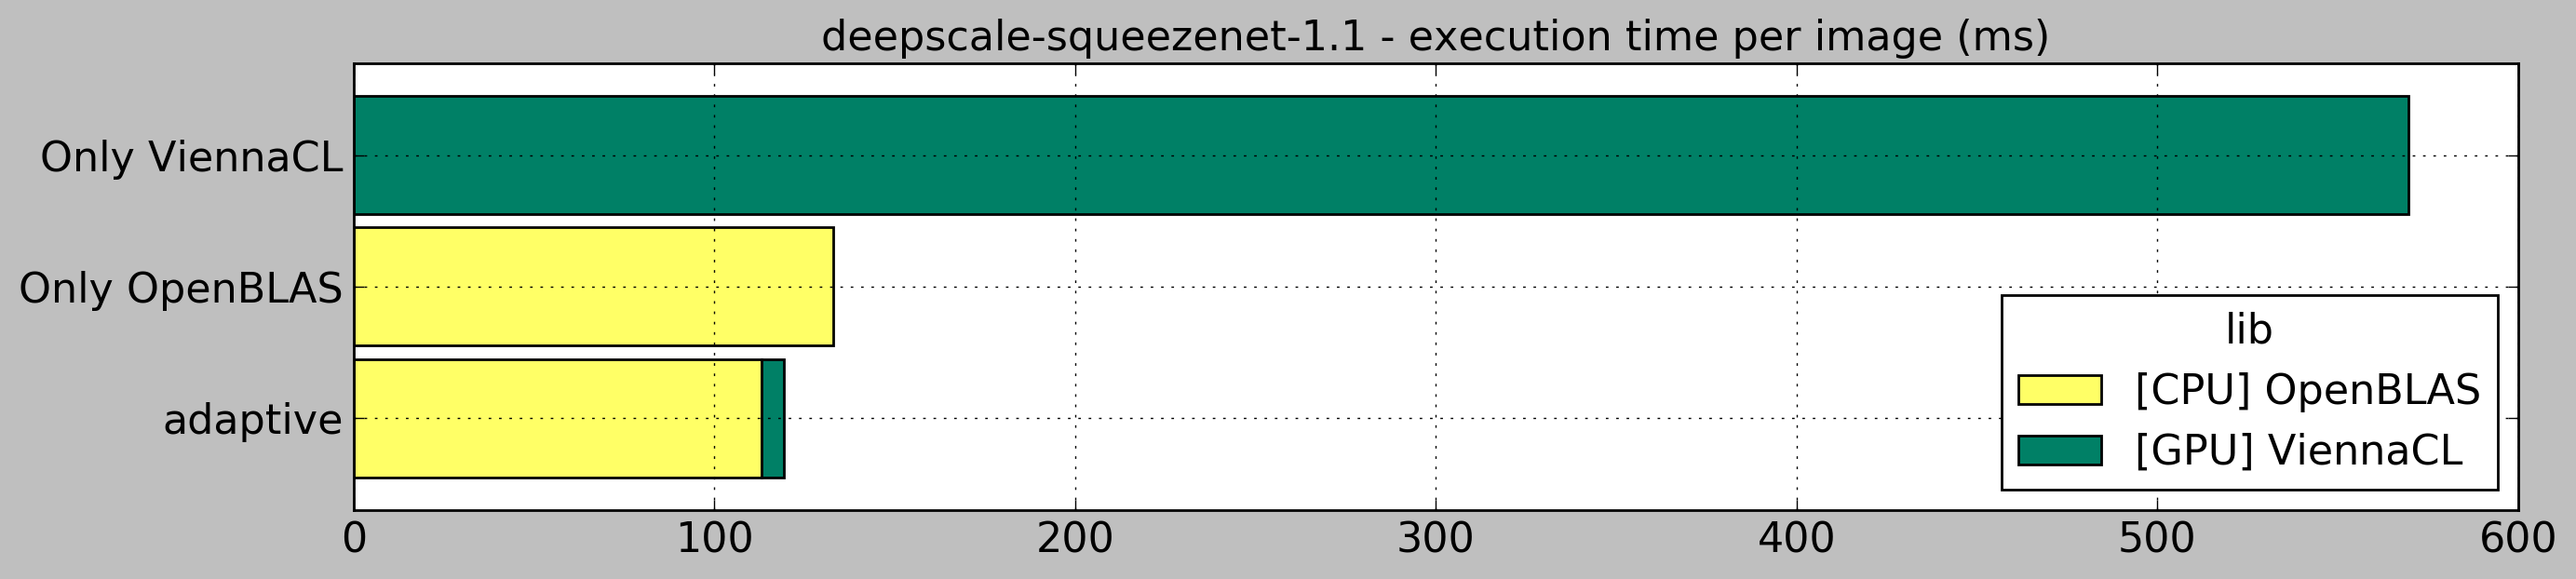

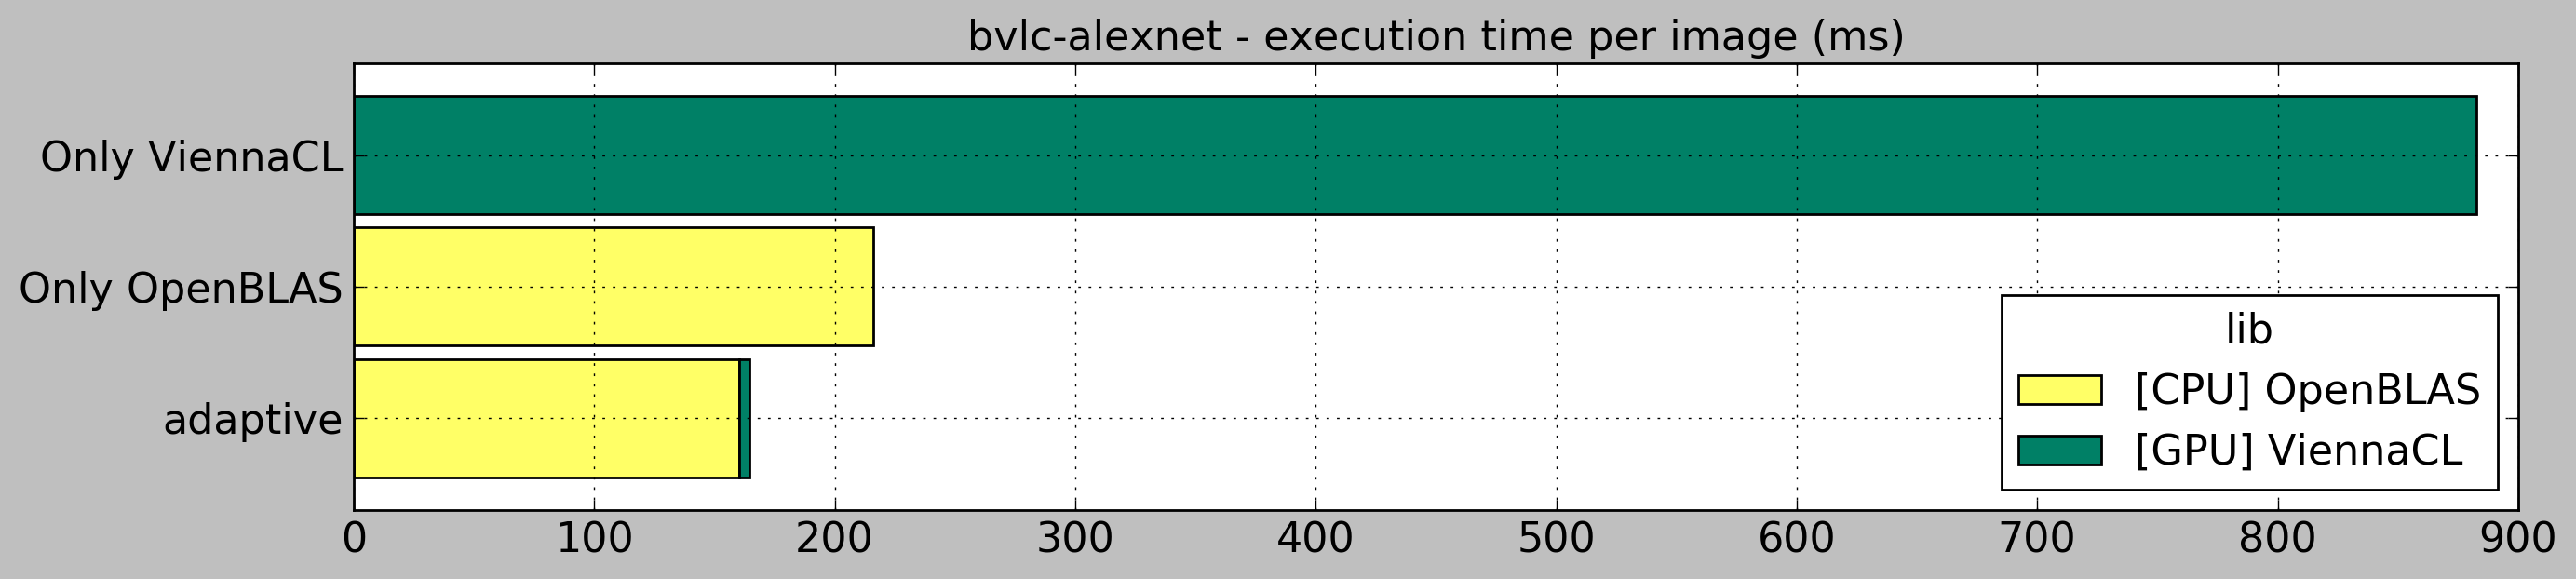

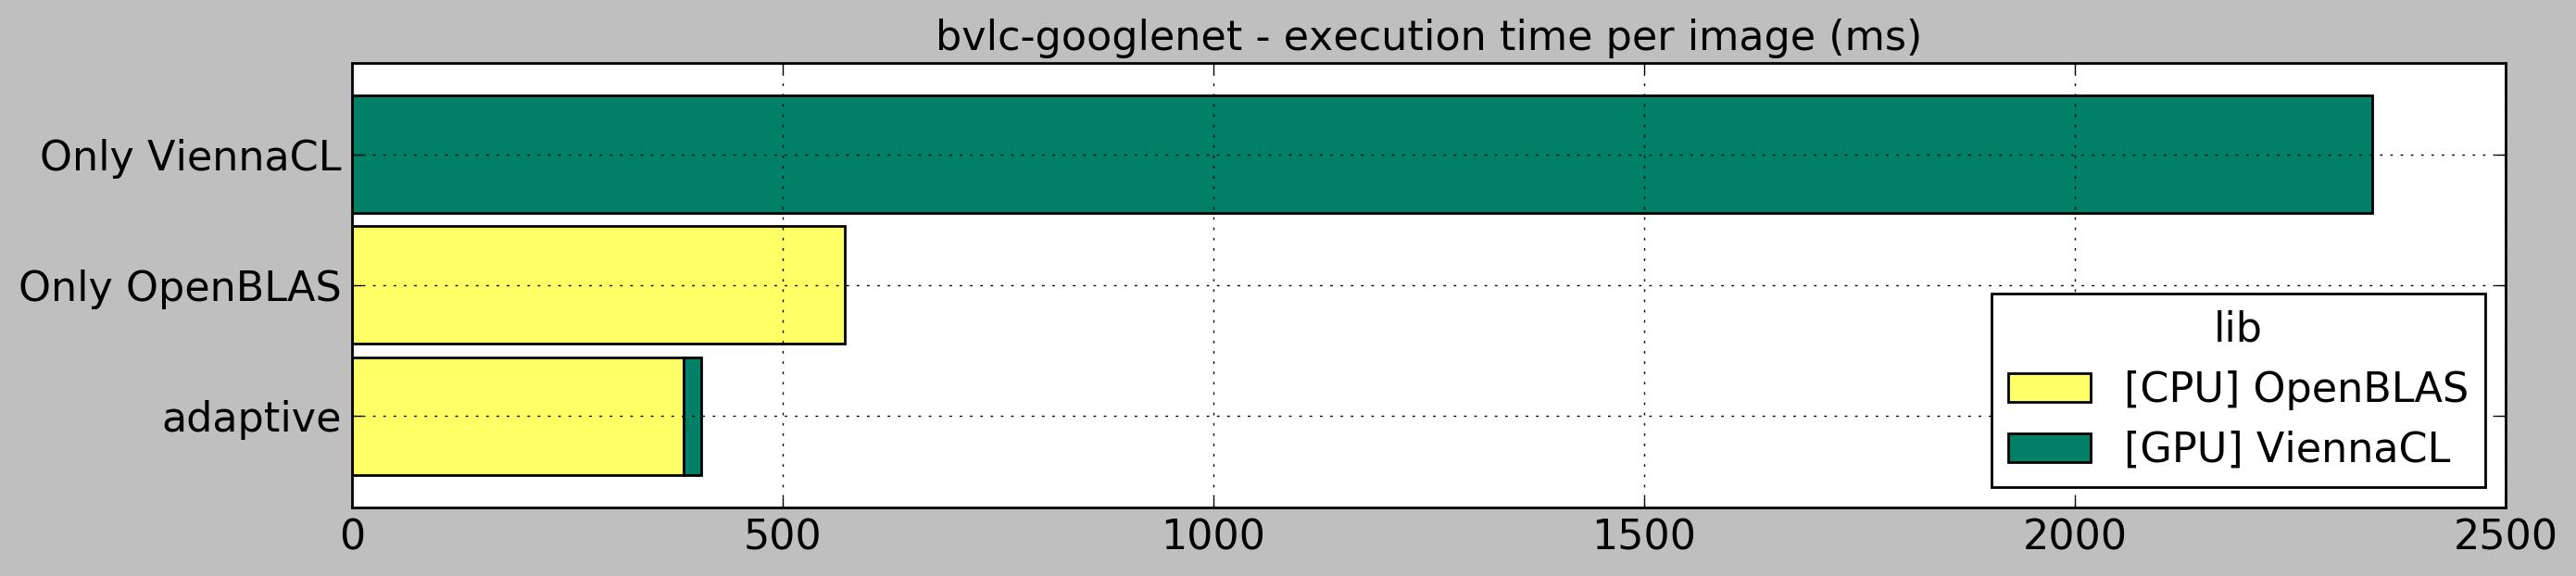

In [73]:
plot_ideal_adaptive_solution(df_ideal_cpu_viennacl, df_model_lib_mean)

In [74]:
# By how much is the execution time reduced compared to the best non-adaptive solution?
df_best_lib = df_model_lib_mean.reorder_levels(['lib', 'model']).sort_index()[libs_for_adaptation].unstack('lib')
df_ideal_cpu_viennacl.sum(axis=1) / df_best_lib.min(axis=1)

model
bvlc-alexnet                0.762099
bvlc-googlenet              0.709839
deepscale-squeezenet-1.1    0.897011
dtype: float64

In [75]:
# By how much is the execution time increased compared to the best adaptive solution?
df_ideal_cpu_viennacl.sum(axis=1) / df_ideal_all.sum(axis=1)

model
deepscale-squeezenet-1.1    1.159625
bvlc-alexnet                1.004347
bvlc-googlenet              1.125374
dtype: float64

<a id="plot_memory"></a>
## Plot memory consumption

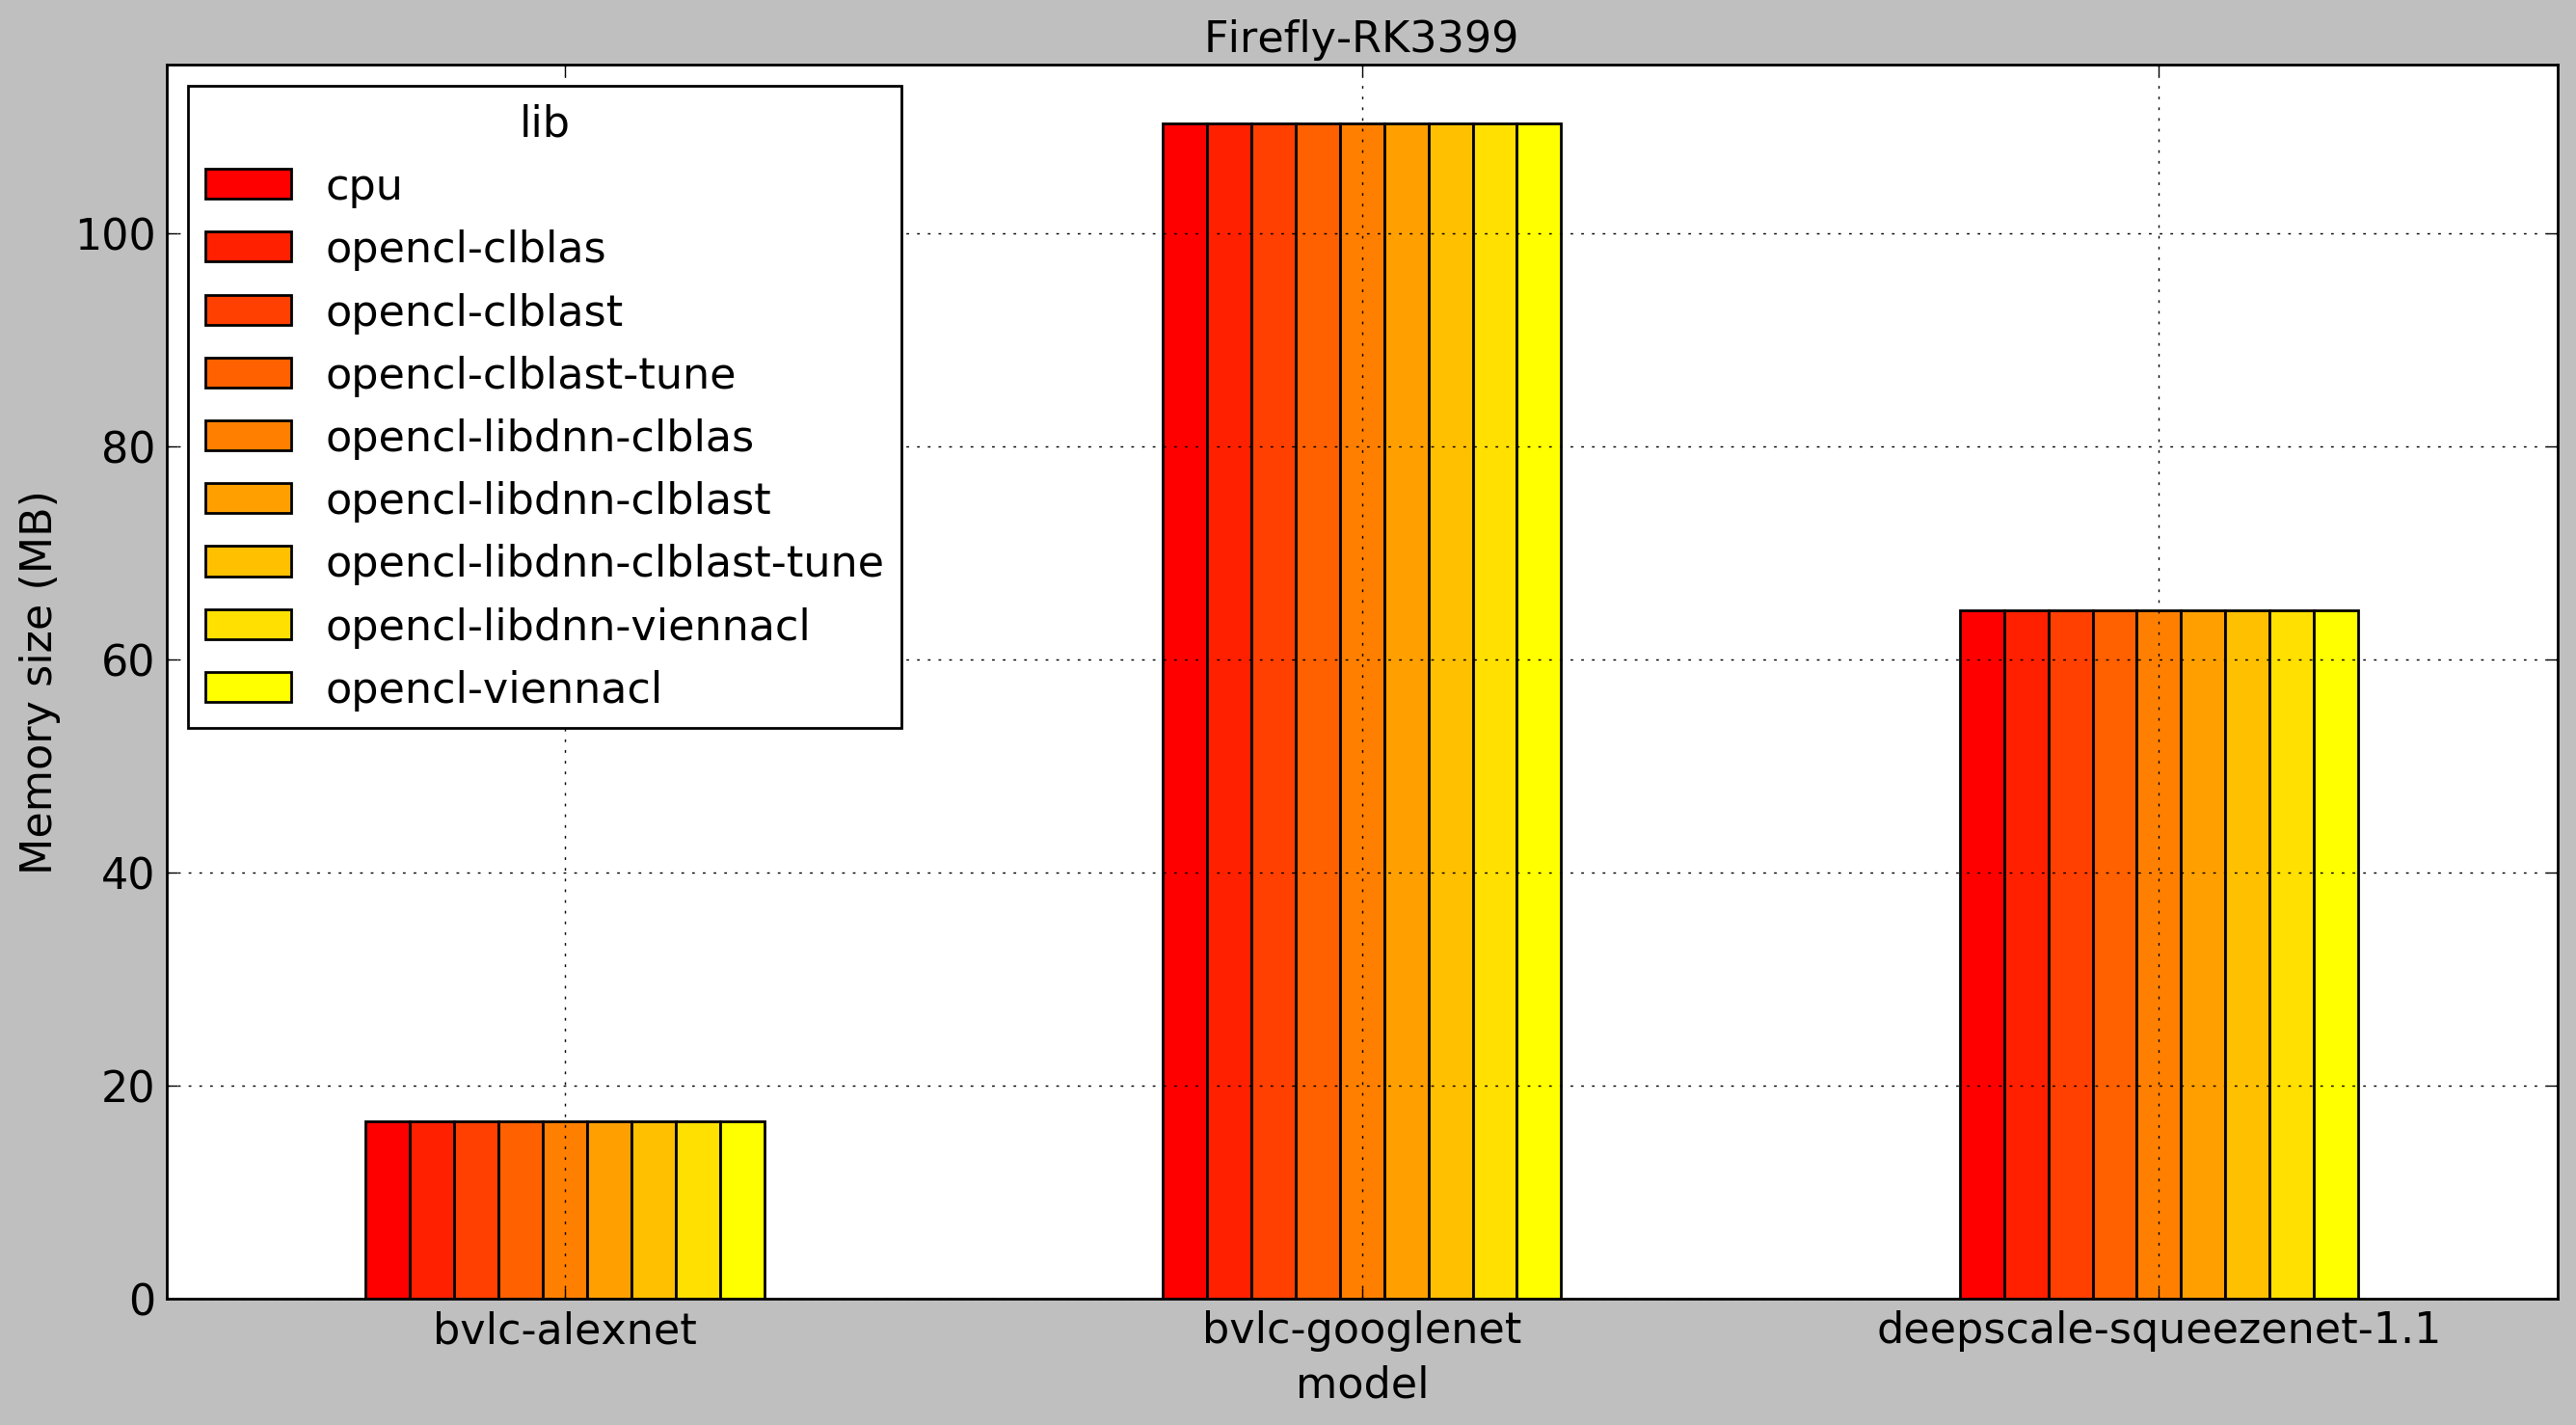

In [76]:
df_memory = df_all['memory (MB)'].loc[platform_id]
# Batch size of 2; repetition 0 (should always be available).
df_memory = df_memory.unstack(['model','lib']).loc[2].loc[0].unstack('lib')
plot(mean=df_memory, std=pd.DataFrame(), ylabel='Memory size (MB)')

<a id="balance_memory_time"></a>
### Balance memory consumption and execution time per image

The above, however, does not tell the full story. The memory consumption, as reported by Caffe, increases linearly with the batch size. In other words, the memory consumption per image is constant. (Note that extra memory may be required e.g. for GPU buffers in host memory.)

The execution time per image, however, decreases asymptotically. Since minimizing the execution time almost always should be balanced with minimizing the memory consumption, we should select the batch size that results in "good enough" performance.

We give several examples below. Note that the execution time per batch is omitted to make the execution time per image more pronounced.

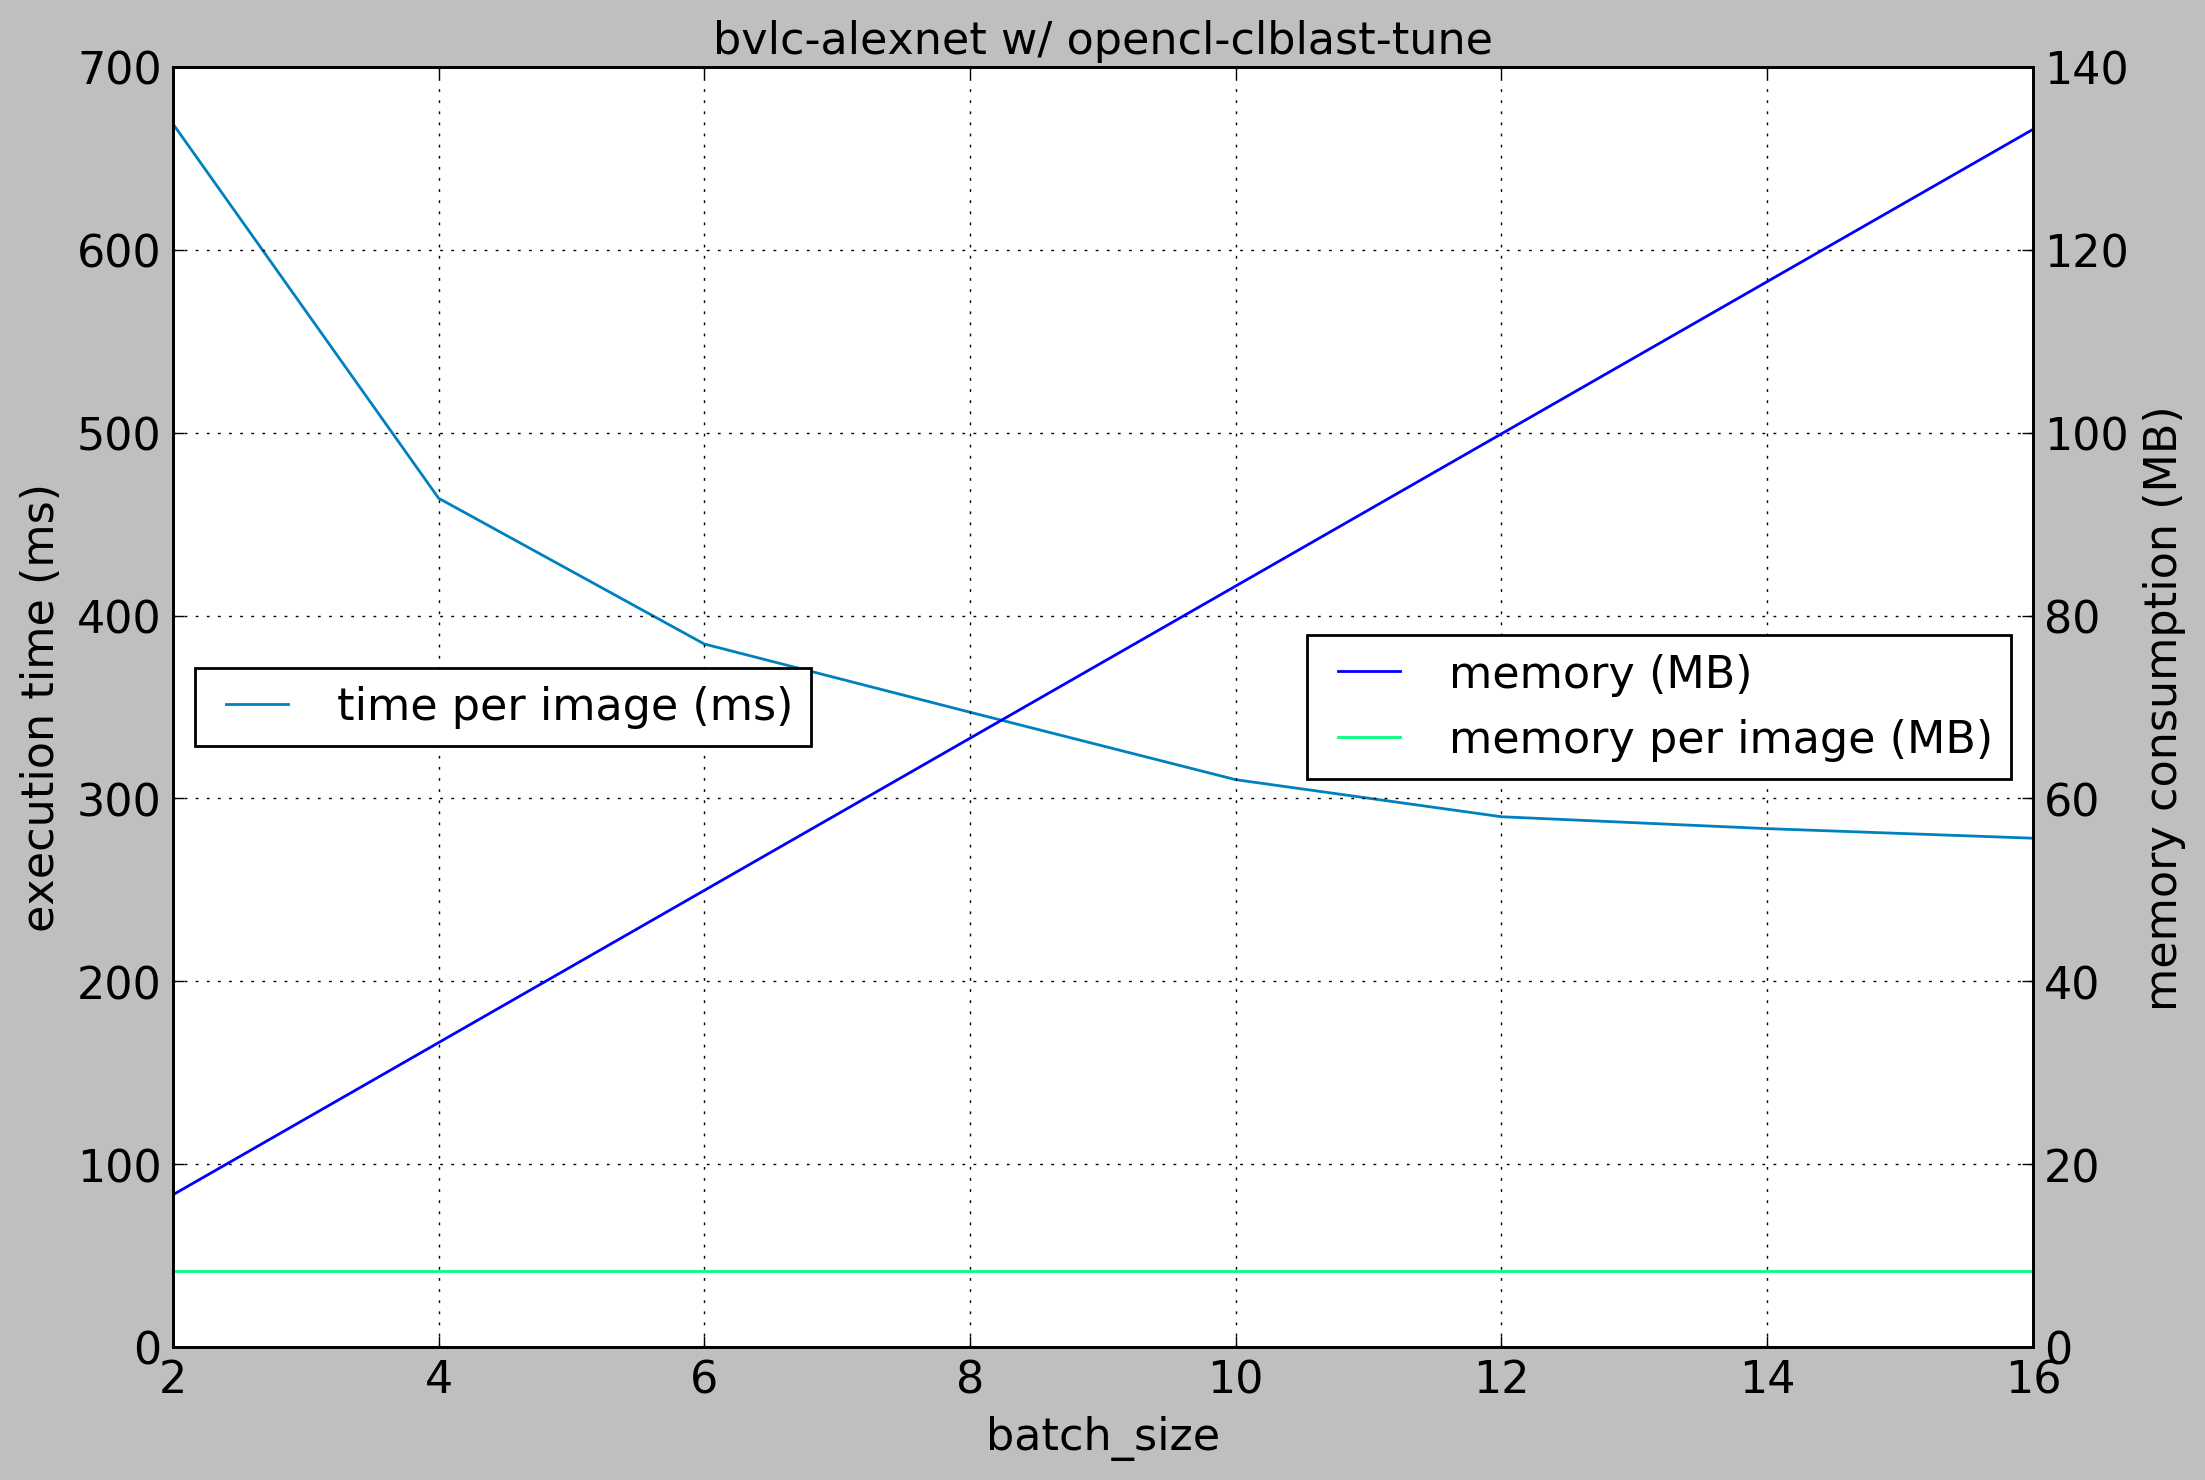

In [77]:
plot_time_per_image_and_memory_consumption(df_all.loc[platform_id], model='bvlc-alexnet', lib='opencl-clblast-tune')

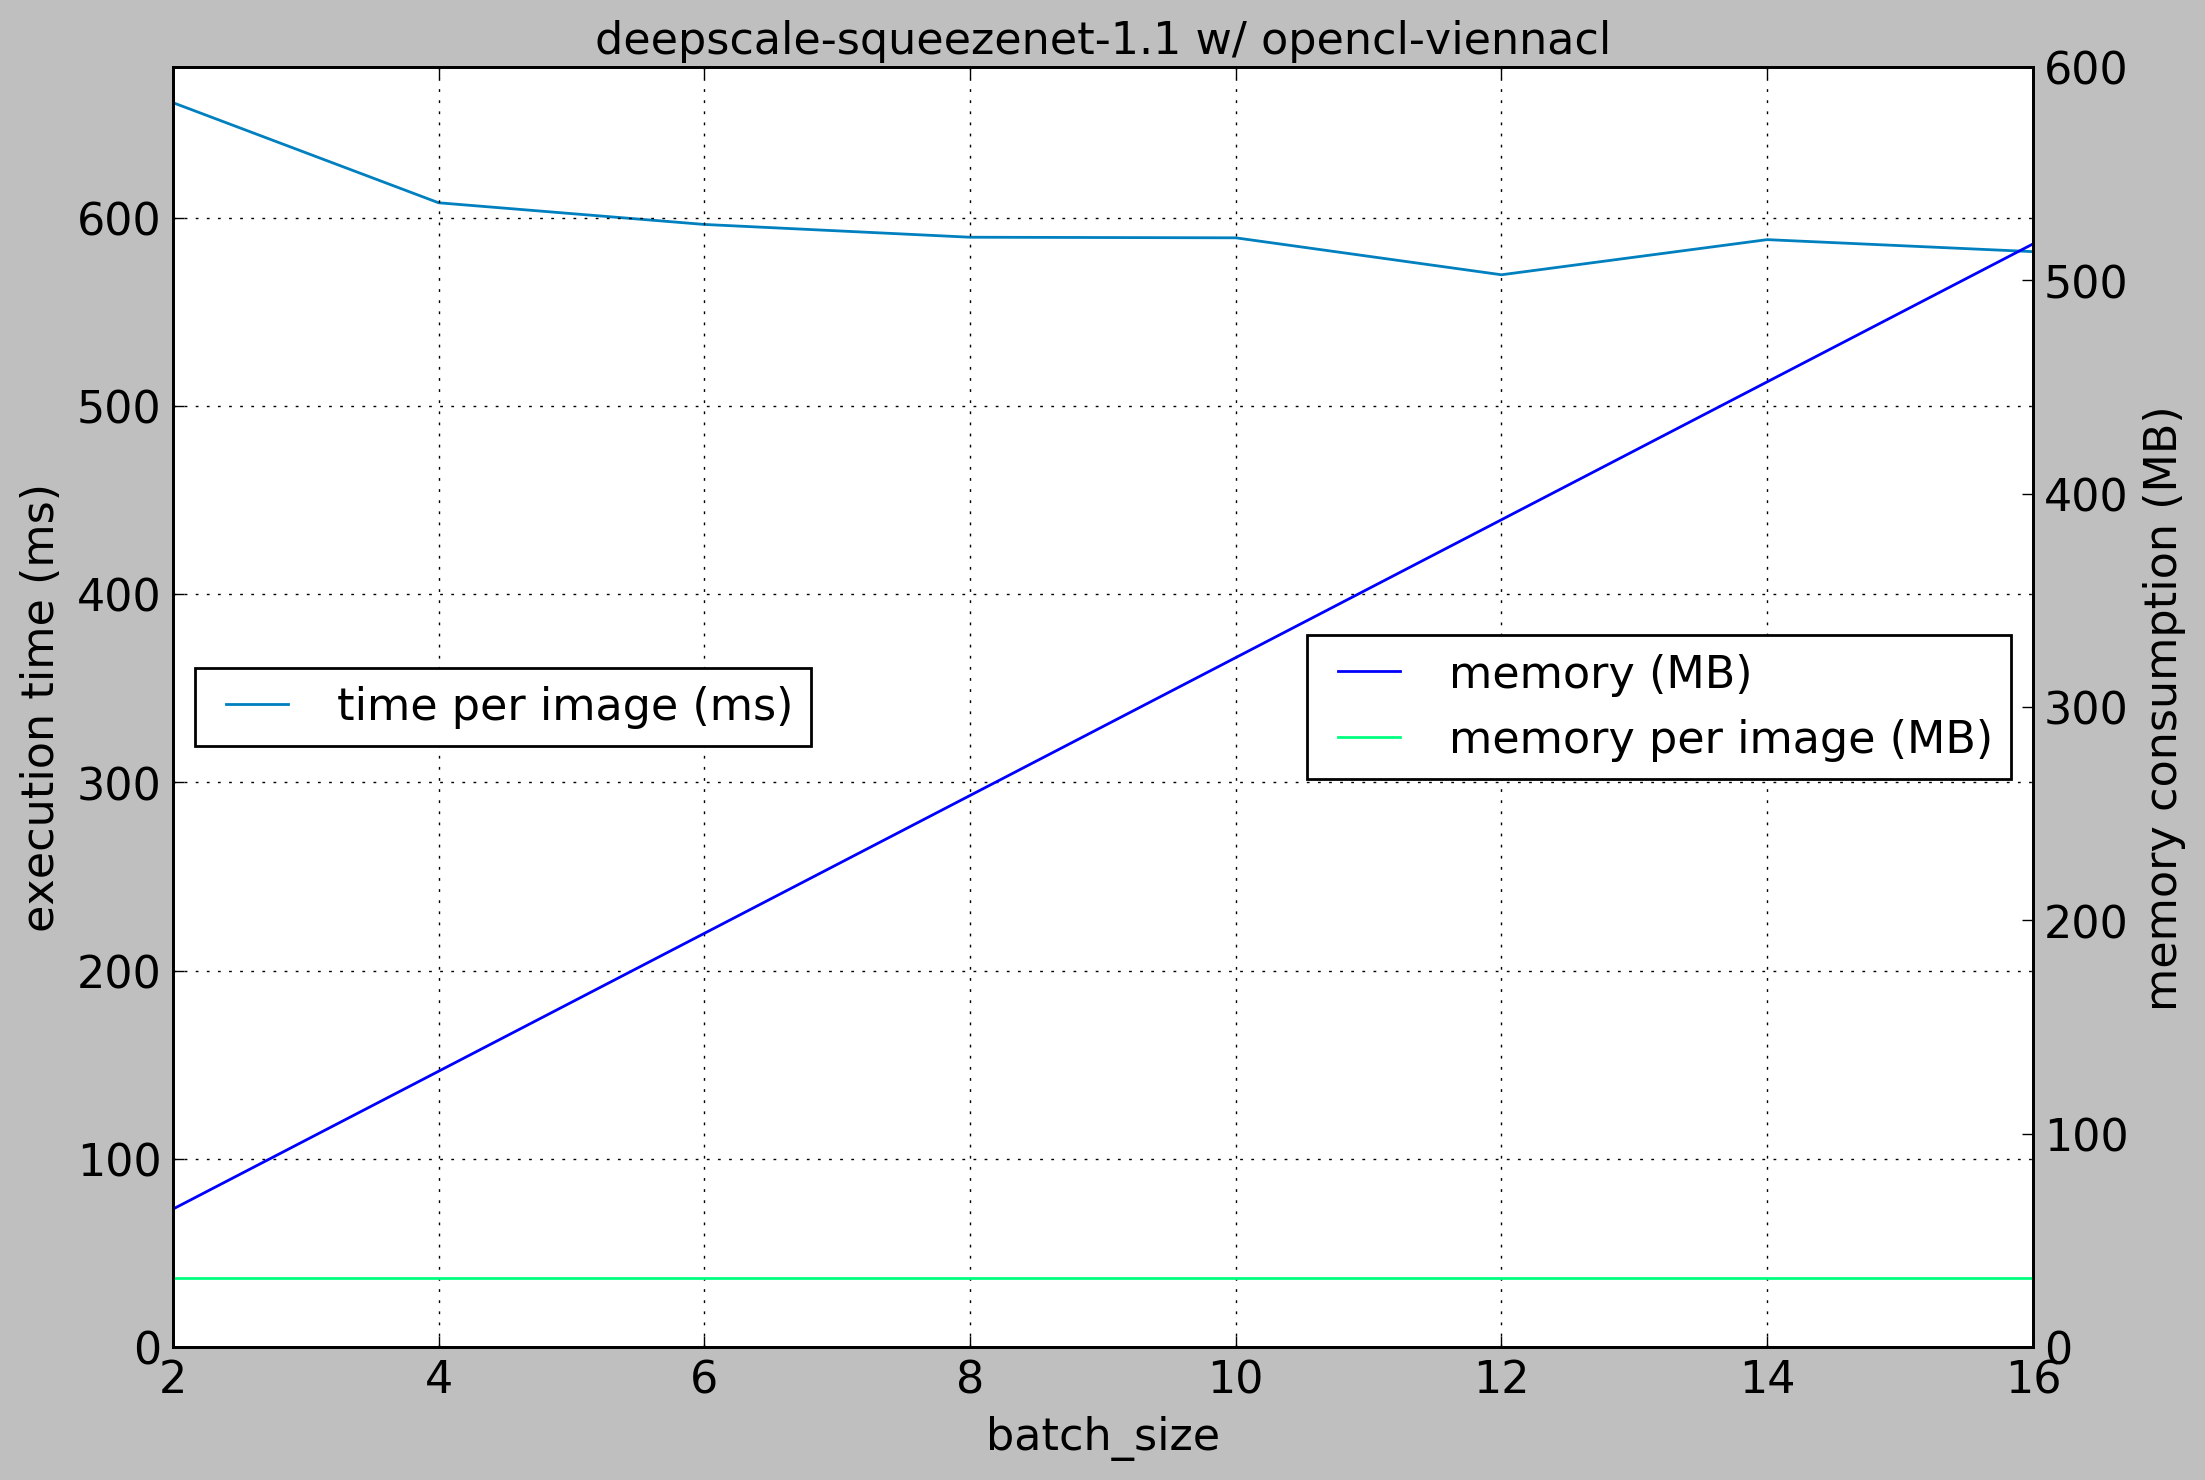

In [78]:
plot_time_per_image_and_memory_consumption(df_all.loc[platform_id], model='deepscale-squeezenet-1.1', lib='opencl-viennacl')

<a id="alexnet_vs_squeezenet"></a>
## Compare AlexNet and SqueezeNet

<a id="alexnet_vs_squeezenet_memory"></a>
### Memory consumption

In [79]:
# SqueezeNet consumes ~4 times more activation memory than AlexNet.
df_memory.loc[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].iloc[1] / \
df_memory.loc[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].iloc[0]

lib
cpu                3.882476
                     ...   
opencl-viennacl    3.882476
Length: 9, dtype: float64

<a id="alexnet_vs_squeezenet_time"></a>
### Execution time

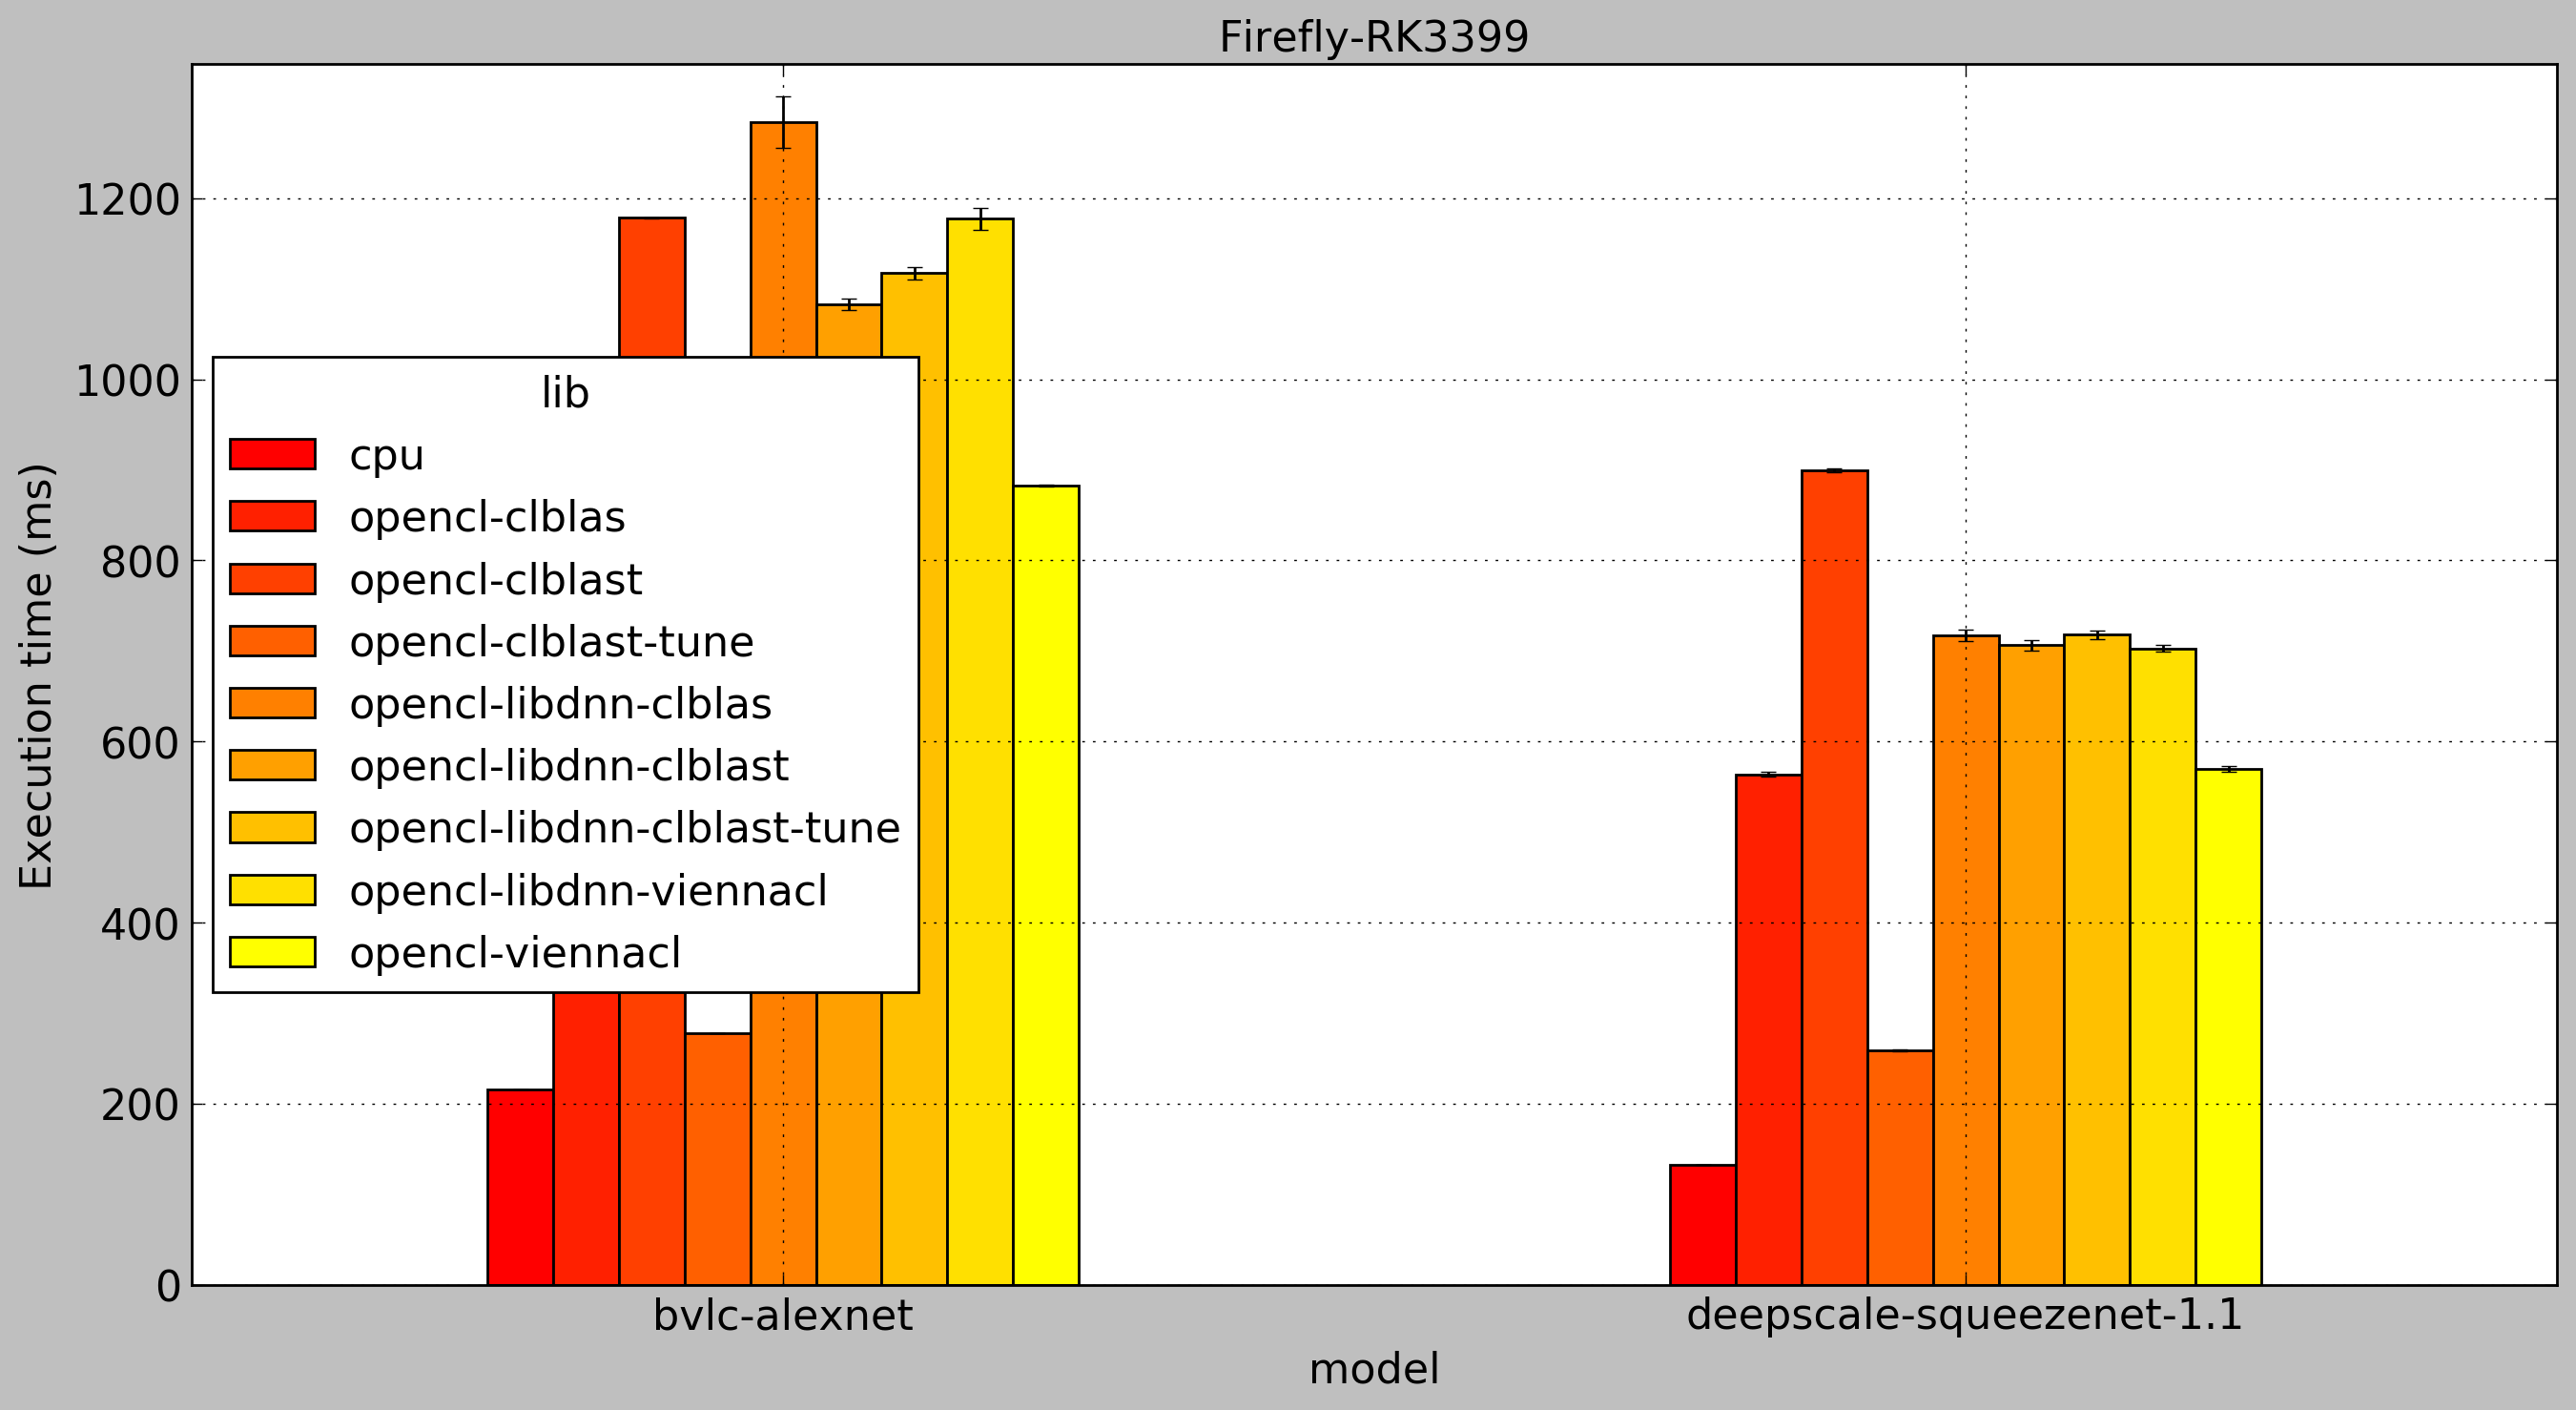

In [80]:
mean = df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib')
std  = df_model_lib_std[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib')
plot(mean, std)

In [81]:
df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib').iloc[1] / \
df_model_lib_mean[['bvlc-alexnet', 'deepscale-squeezenet-1.1']].unstack('lib').iloc[0]

lib
cpu                0.614685
                     ...   
opencl-viennacl    0.645296
Length: 9, dtype: float64

<a id="summary"></a>
## Summary

<a id="performance_absolute"></a>
### What's the absolute performance?

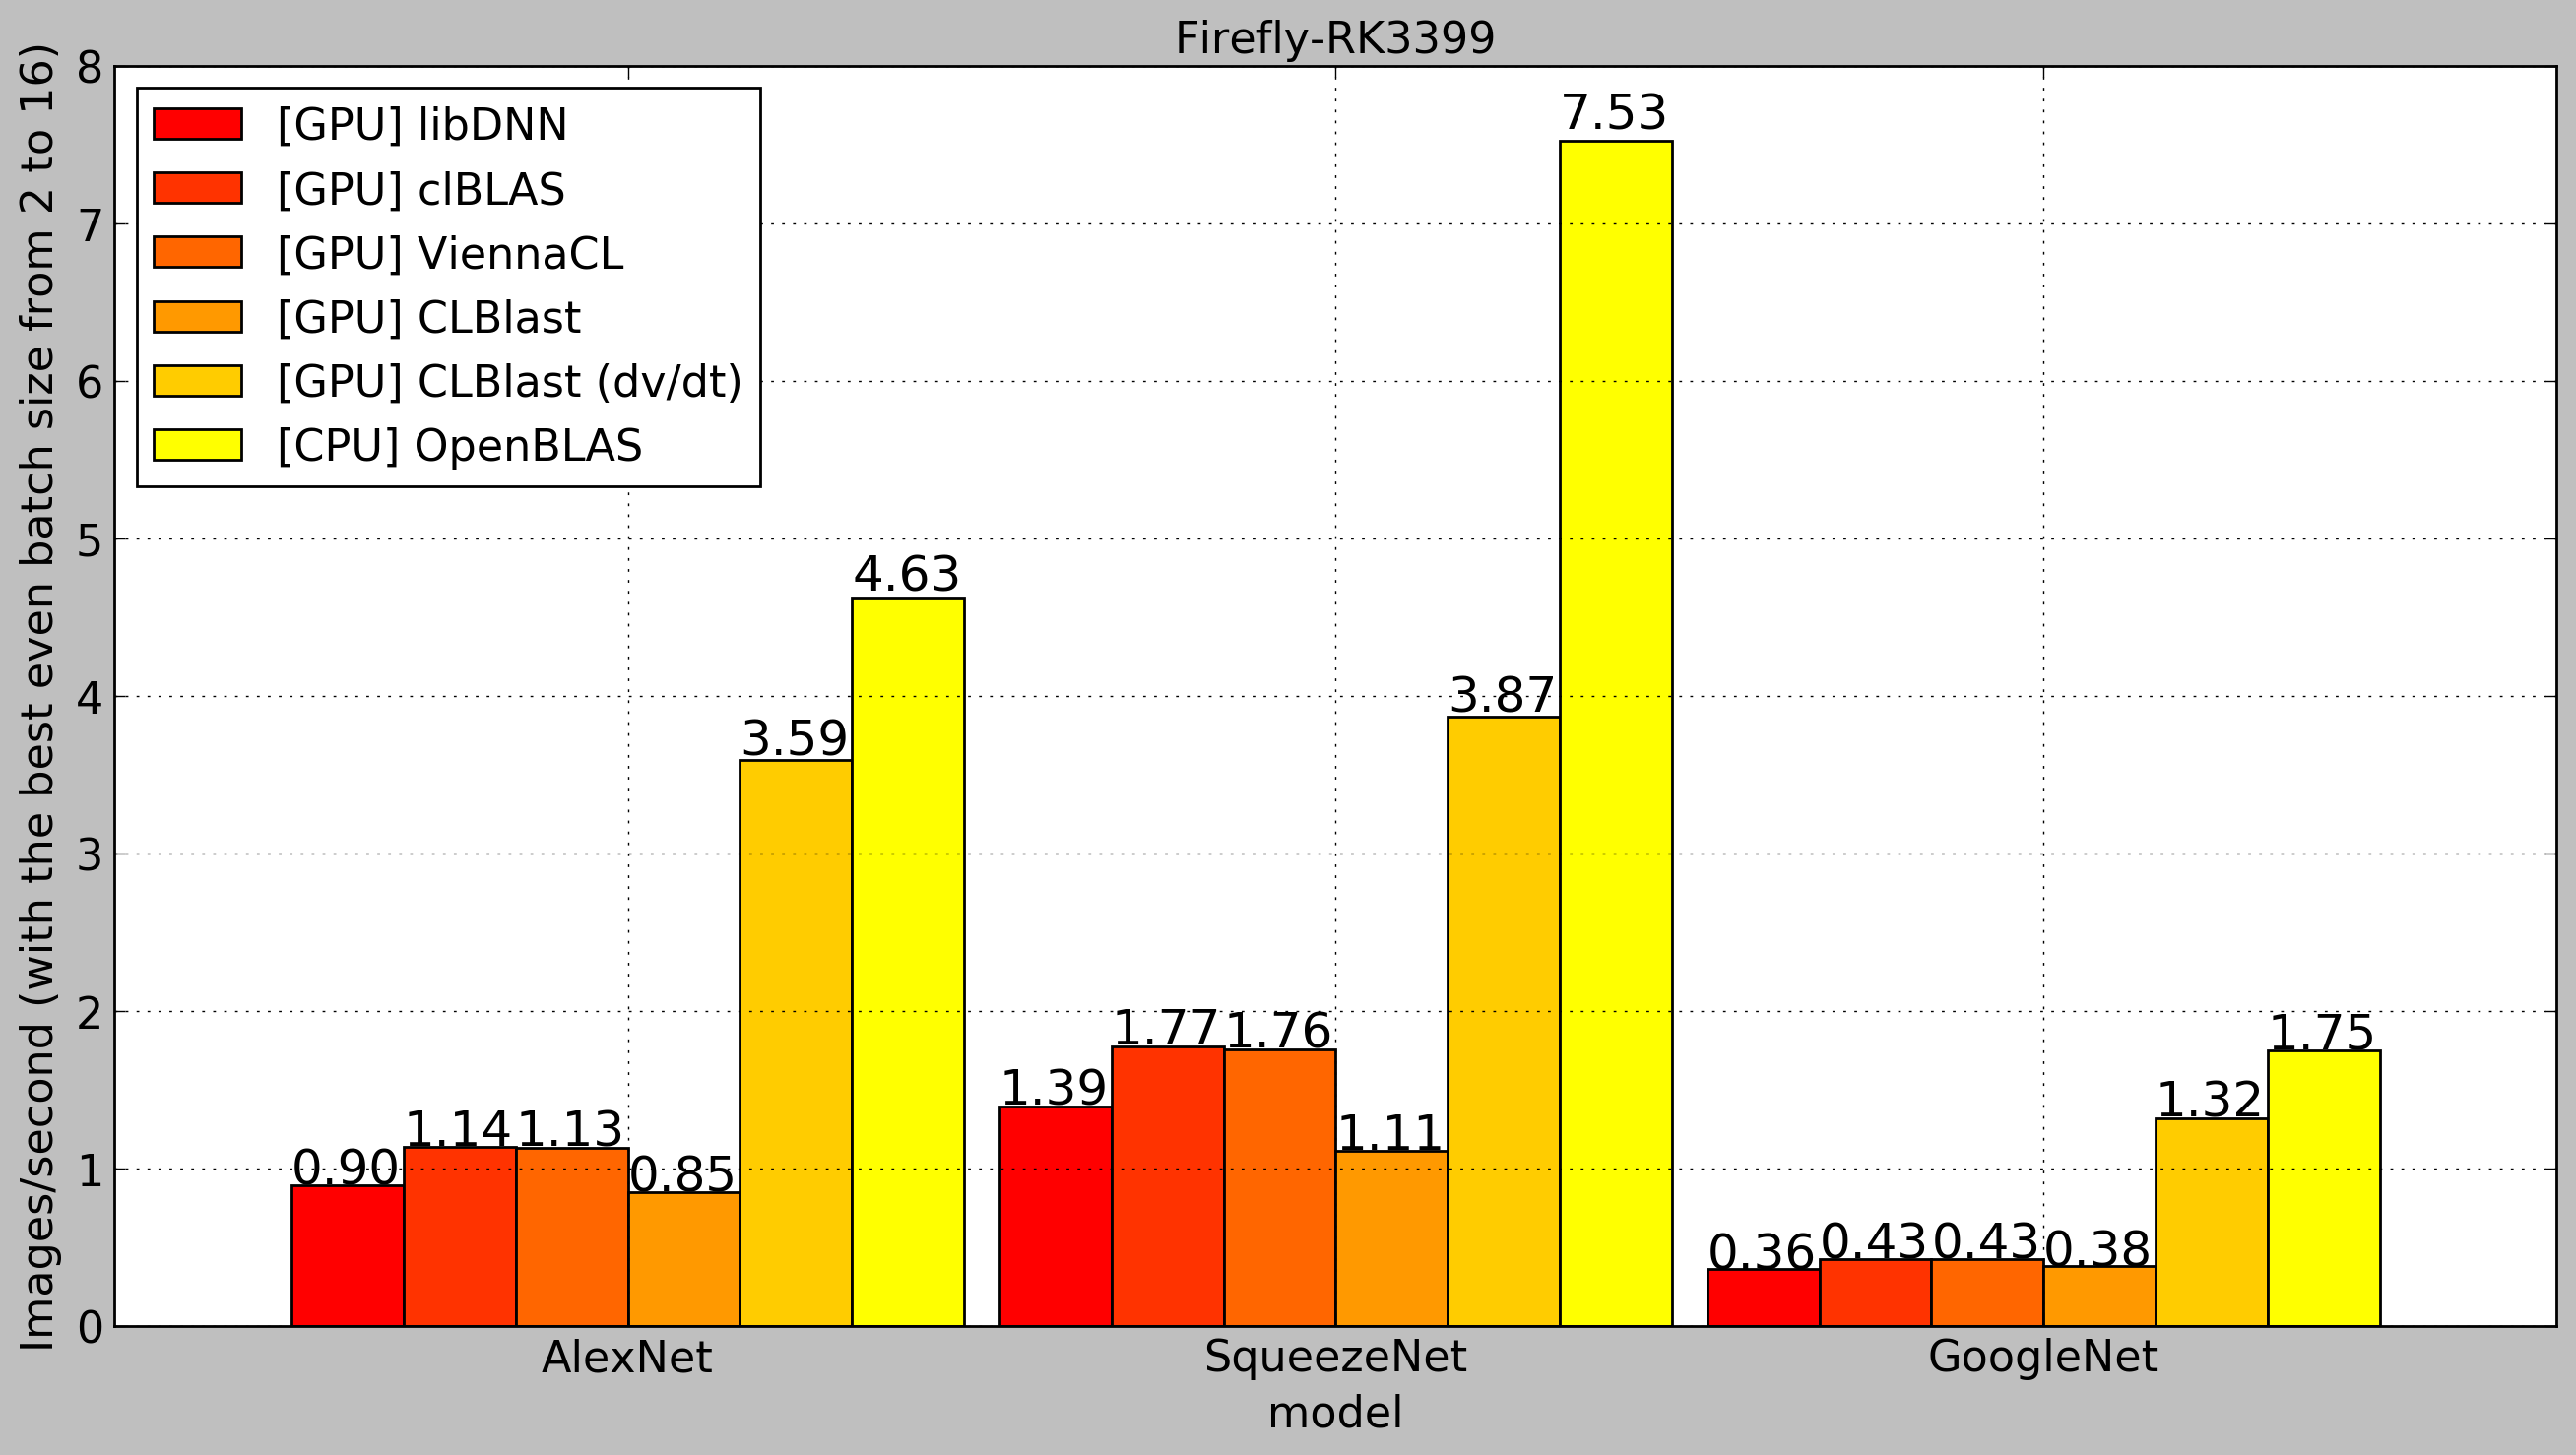

In [82]:
plot_max_num_images_per_second(
    df_mean_time_per_image,
    fontsize=18
)

<a id="performance_relative"></a>
### What's the relative performance?

#### ... over OpenBLAS?

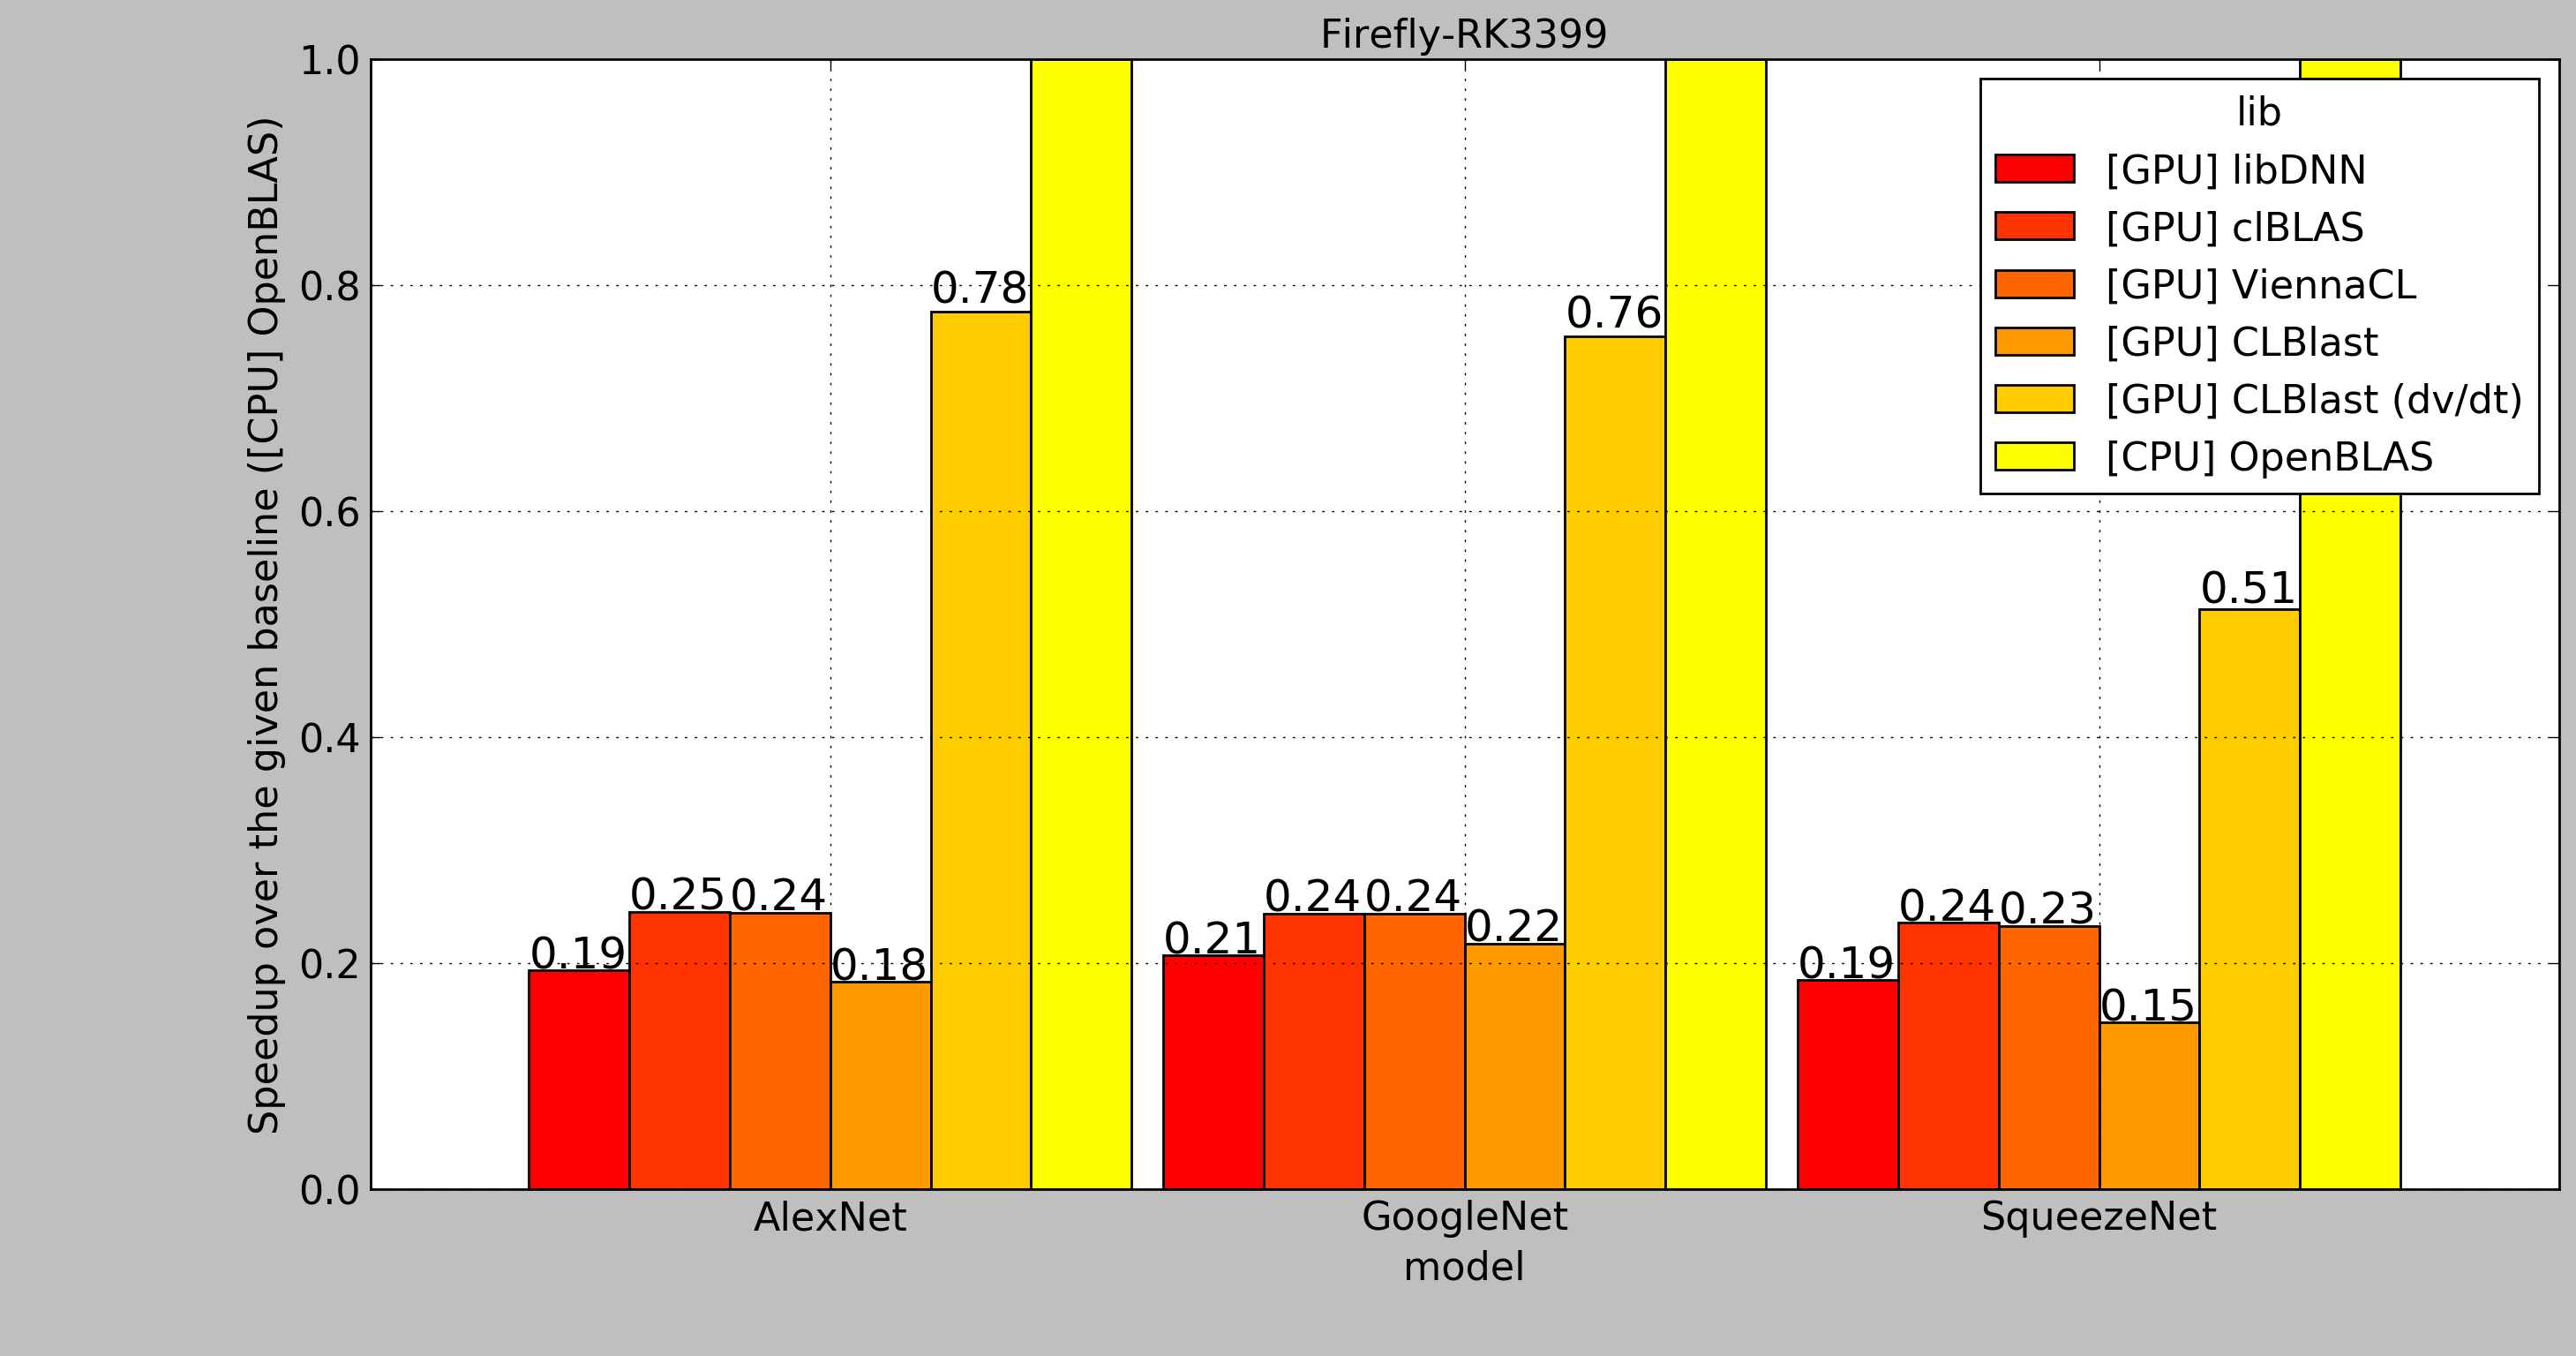

In [83]:
plot_speedup_over_baseline(
    df_mean_time_per_image,
    baseline='cpu',
    fontsize=18
)

#### ... over CLBlast (dv/dt)?

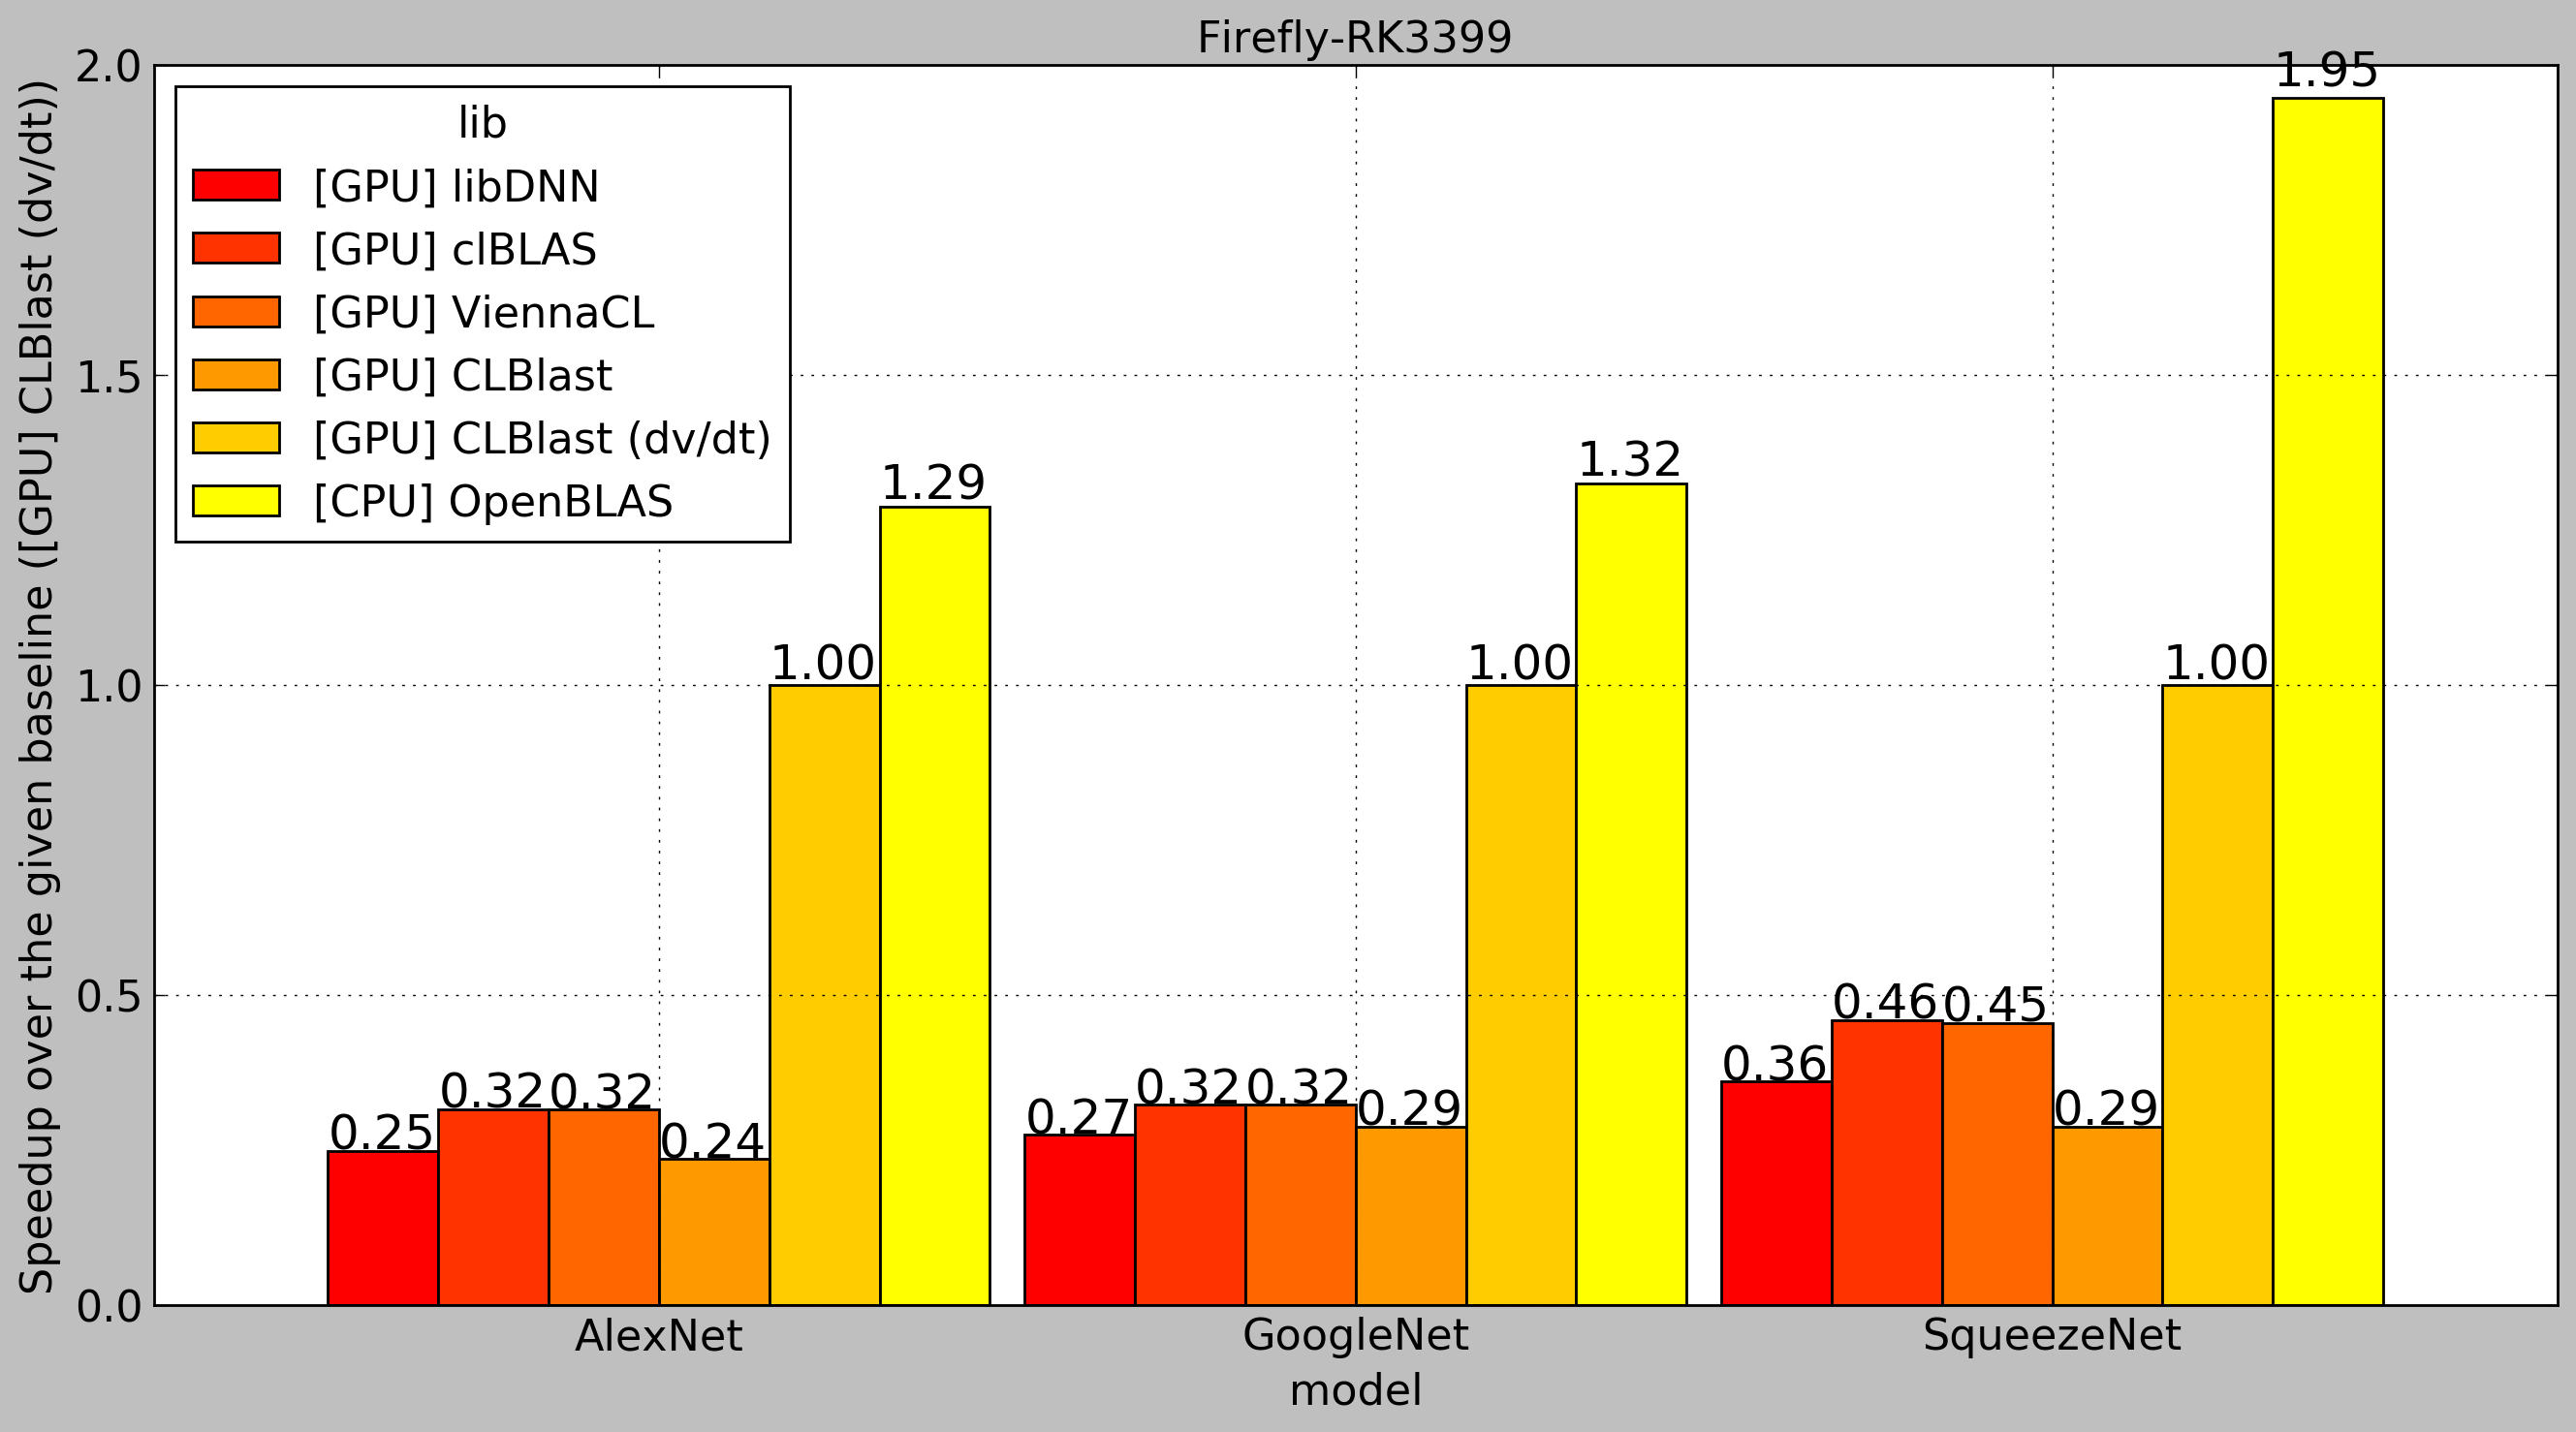

In [84]:
plot_speedup_over_baseline(
    df_mean_time_per_image,
    baseline='opencl-clblast-tune',
    fontsize=18
)

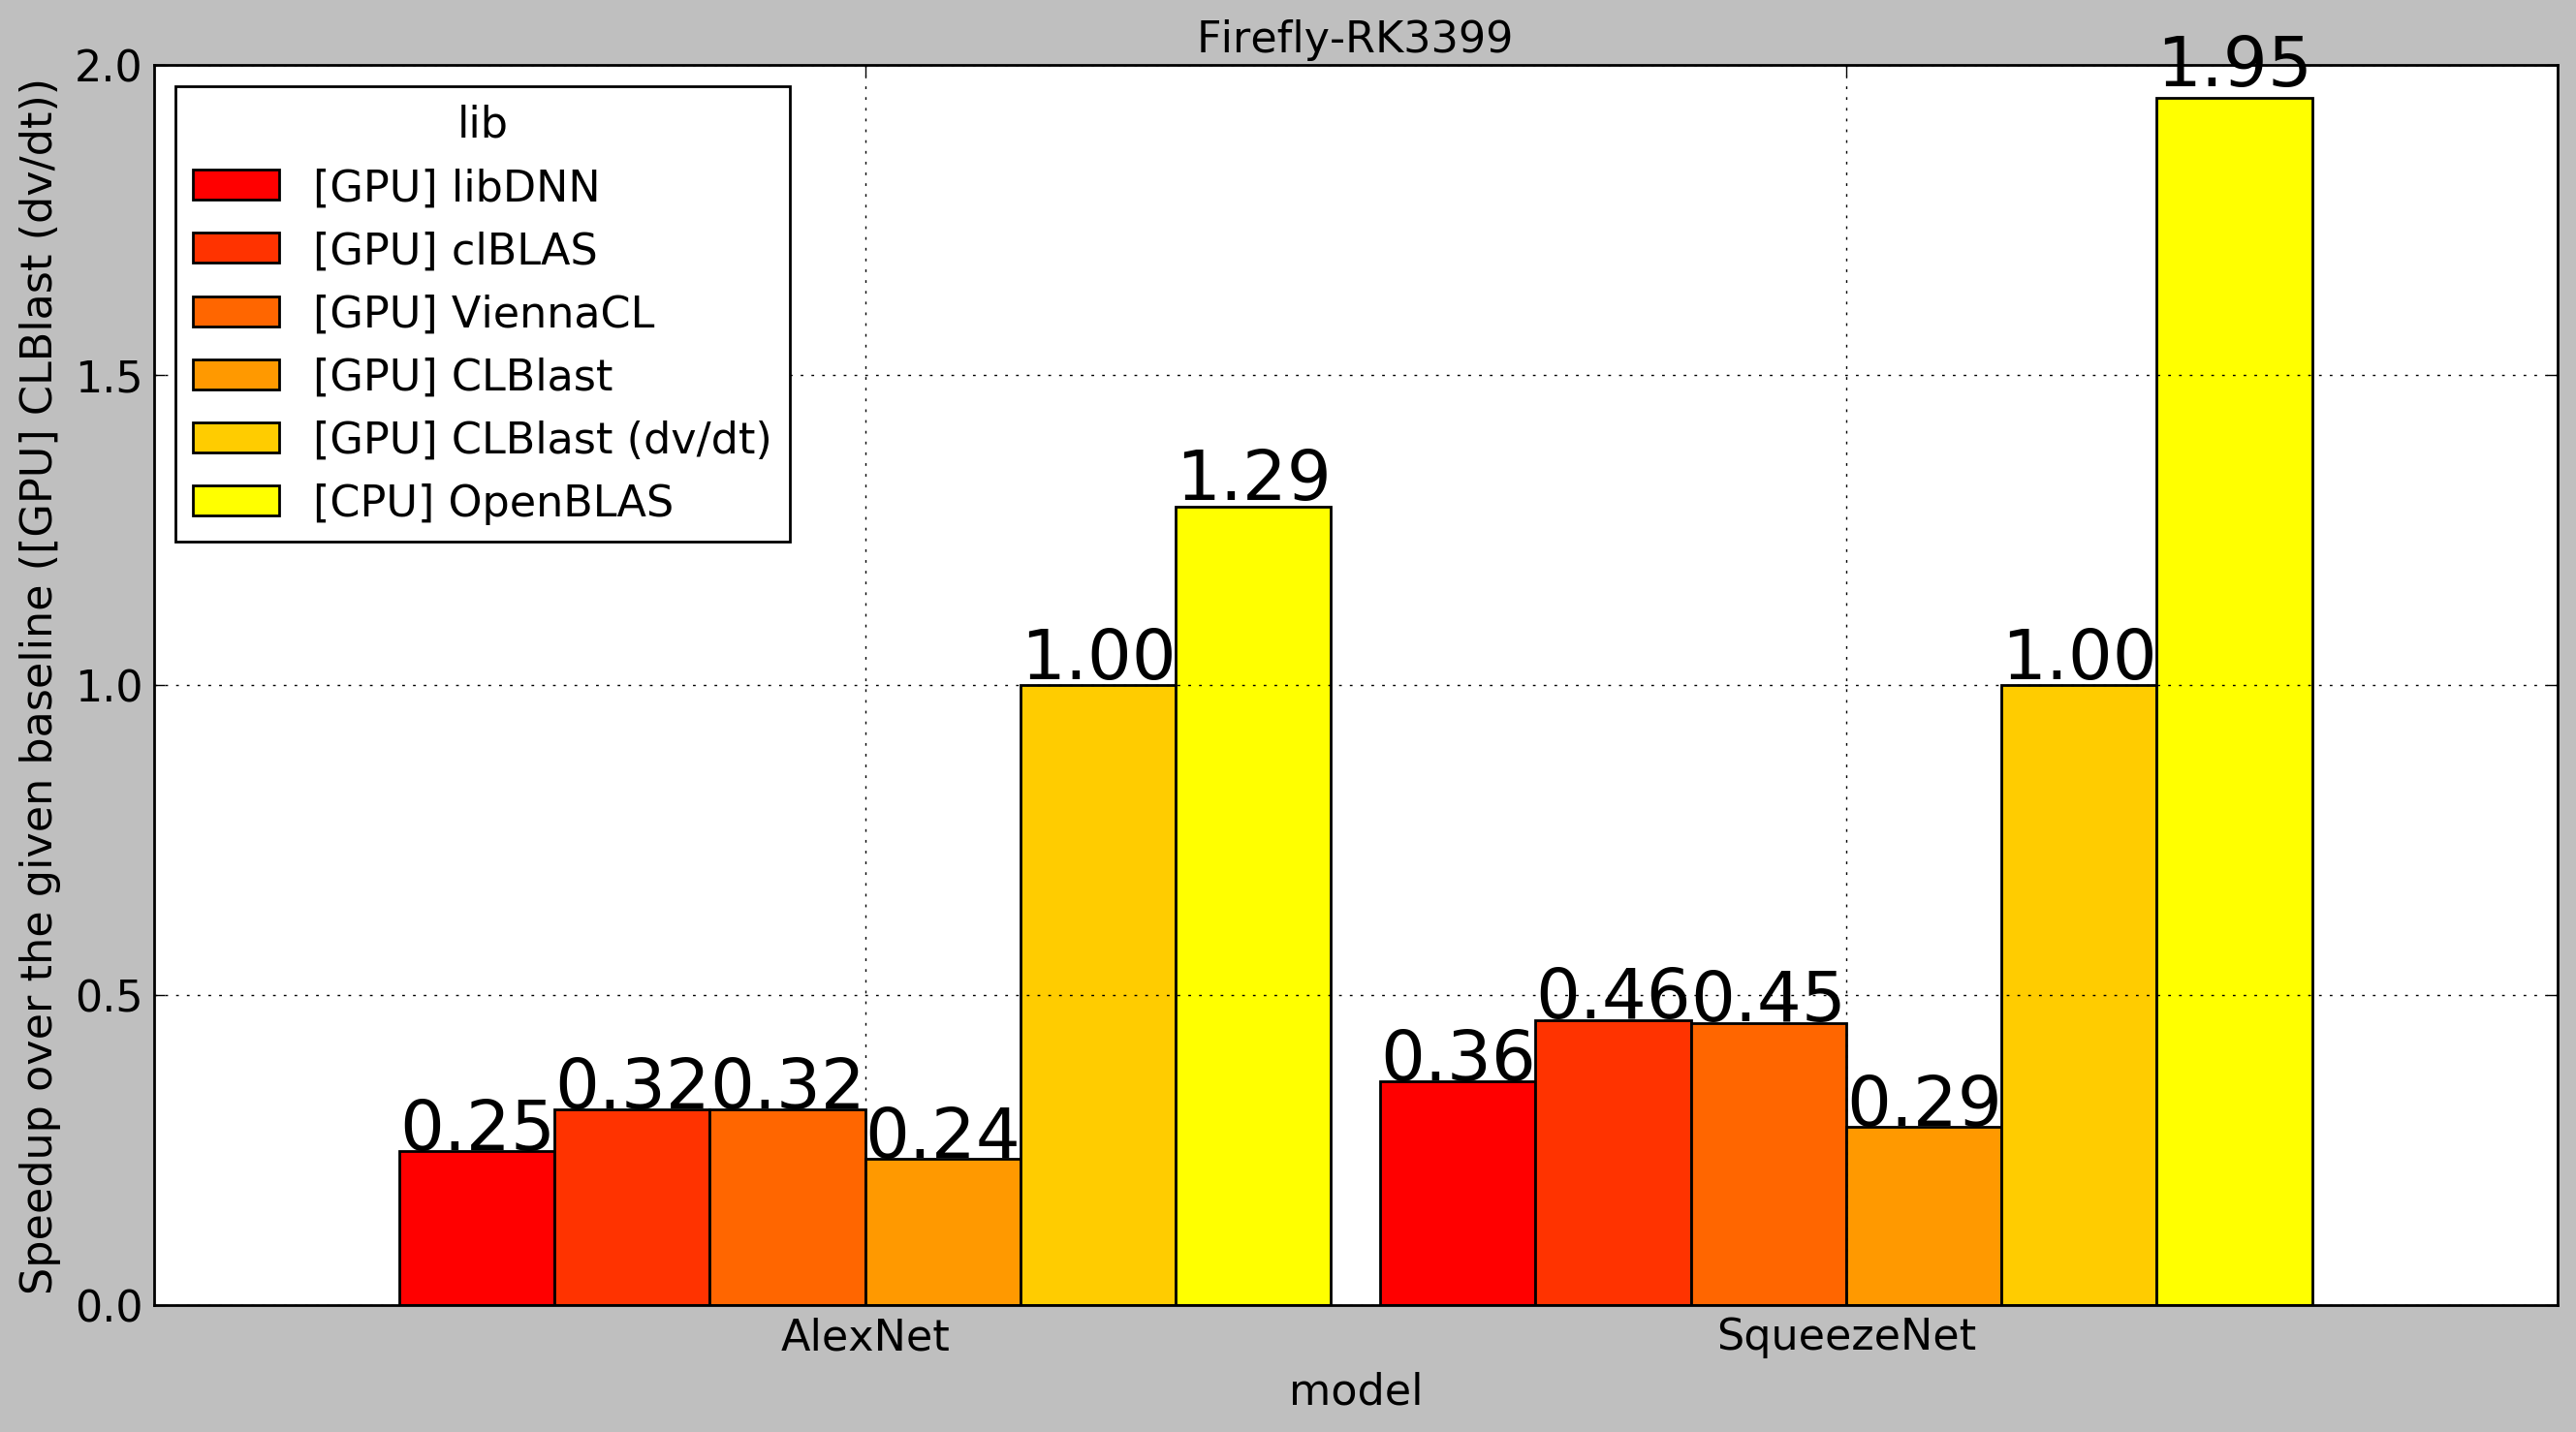

In [85]:
plot_speedup_over_baseline(
    df_mean_time_per_image.loc[['bvlc-alexnet', 'deepscale-squeezenet-1.1']],
    baseline='opencl-clblast-tune',
    fontsize=26
)